# Star Ratings for Medicare Plans

In [167]:
import pandas as pd
import numpy as np
import os
from typing import Optional, List, Tuple
import re

class StarRatings:
    """
    Class to read, clean, and process Medicare Star Ratings data files.
    
    Args:
        file_paths: List of CSV file paths with single-row headers
        multirow_header_files: List of CSV file paths with 3-row headers (Measure Data, Measure Stars, Cut Points)
        pqa_excel_files: List of PQA Excel file paths to process
        fast_clean: If True (default), automatically run clean_dfs() on initialization.
                   If False, you must manually call clean_dfs() later.
        fast_process_pqa: If True (default), automatically process PQA Excel files on initialization.
                         If False, you must manually call process_pqa_files() later.
                           
    Example:
        # Auto-clean CSV files and auto-process PQA files (default)
        SR = StarRatings(file_paths=['...'], multirow_header_files=['...'], pqa_excel_files=['...'])
        
        # Manual cleaning and processing
        SR = StarRatings(file_paths=['...'], pqa_excel_files=['...'], fast_clean=False, fast_process_pqa=False)
        SR.clean_dfs()  # Call manually when ready
        SR.process_pqa_files(SR.pqa_excel_files)  # Call manually when ready
    """
    def __init__(self, file_paths: Optional[List[str]] = [], 
                 multirow_header_files: Optional[List[str]] = [],
                 cutpoint_files: Optional[List[str]] = [],
                 pqa_excel_files: Optional[List[str]] = [],
                 output_dir: Optional[str] = None,
                 output_cleaned: bool = True,
                 fast_clean: bool = True,
                 add_year: bool = True,
                 manual_year: Optional[int] = None,
                 process_cutpoints: bool = True,
                 merge_cutpoints: bool = True,
                 fast_process_pqa: bool = True):
                 
        self.file_paths = file_paths
        self.multirow_header_files = multirow_header_files + cutpoint_files
        self.cutpoint_files = cutpoint_files
        self.pqa_excel_files = pqa_excel_files
        self.output_dir = output_dir
        self.output_cleaned = output_cleaned
        self.add_year = add_year
        self.manual_year = manual_year
        self.process_cutpoints = process_cutpoints
        self.merge_cutpoints = merge_cutpoints
        self.dfs = {}  # Changed to dict to store by filename
        self.pqa_dfs = {}  # Store PQA dataframes
        
        # Automatically clean if fast_clean is True
        if fast_clean and (file_paths or multirow_header_files):
            self.clean_dfs()
        
        # Automatically process PQA files if fast_process_pqa is True
        if fast_process_pqa and pqa_excel_files:
            cleaned_pqa_dfs, saved_files = self.process_pqa_files(pqa_excel_files)
            self.pqa_dfs = cleaned_pqa_dfs
            
        if output_cleaned:
            self.save_cleaned_files()

    def read_files(self):
        """Read simple CSV files with single header row"""
        dfs = {}
        for path in self.file_paths:
            df = pd.read_csv(path, encoding='windows-1252', skiprows=1)
            filename = path.split('/')[-1].replace('.csv', '')
            dfs[filename] = df
        return dfs
    
    def read_multirow_header_files(self):
        """Read files with 3-row headers (Measure Data, Measure Stars, Cut Points)"""
        dfs = {}
        for path in self.multirow_header_files:
            df = self.read_3row_header_file(path)
            filename = path.split('/')[-1].replace('.csv', '')
            dfs[filename] = df
        return dfs
    
    def read_3row_header_file(self, path: str) -> pd.DataFrame:
        """Read file with 3-row headers and combine them into single column names"""
        # Read the three header rows
        header_row1 = pd.read_csv(path, encoding='windows-1252', skiprows=1, nrows=1, header=None)
        header_row2 = pd.read_csv(path, encoding='windows-1252', skiprows=2, nrows=1, header=None)
        header_row3 = pd.read_csv(path, encoding='windows-1252', skiprows=3, nrows=1, header=None)
        
        # Forward-fill the domain headers (row 1) so each column gets the correct domain
        # Domains span multiple columns until the next domain appears
        current_domain = ""
        domains_filled = []
        for i in range(len(header_row1.columns)):
            domain = str(header_row1.iloc[0, i]).strip() if pd.notna(header_row1.iloc[0, i]) else ""
            # Update current_domain only if we find a valid domain header (starts with HD or DD)
            if domain and domain != 'nan' and (domain.startswith('HD') or domain.startswith('DD')):
                current_domain = domain
            domains_filled.append(current_domain)
        
        # Combine the headers
        combined_headers = []
        seen_names = {}  # Track duplicate names
        
        for i in range(len(header_row1.columns)):
            domain = domains_filled[i]
            original_header = str(header_row1.iloc[0, i]).strip() if pd.notna(header_row1.iloc[0, i]) else ""
            measure = str(header_row2.iloc[0, i]).strip() if pd.notna(header_row2.iloc[0, i]) else ""
            date_range = str(header_row3.iloc[0, i]).strip() if pd.notna(header_row3.iloc[0, i]) else ""
            
            # Replace the en-dash character with colon in date range
            date_range = date_range.replace('–', ':').replace('�', ':')
            
            # Build column name based on what's available
            # Determine if this is a measure column (starts with C or D followed by number)
            is_measure_column = measure and (measure.startswith('C') or measure.startswith('D')) and len(measure) > 1 and measure[1:3].split(':')[0].isdigit()
            
            # For Part D files, first column might be Org Type
            if i == 0 and 'Org Type' in original_header:
                col_name = 'Org Type'
            elif is_measure_column:
                # For measure columns (C01, C02, D01, etc.)
                # Descriptive: combine all three pieces: domain; measure; date
                parts = []
                if domain:
                    parts.append(domain)
                if measure:
                    parts.append(measure)
                # if date_range and date_range != 'nan':
                    # parts.append(date_range)
                col_name = '; '.join(parts) if parts else f"Column_{i}"

            else:
                # For metadata columns, use the original header from row 1
                # These are columns like CONTRACT_ID, Organization Type, etc.
                col_name = original_header if original_header and original_header != 'nan' else measure if measure else f"Column_{i}"
            
            # Handle duplicate column names by adding a suffix
            if col_name in seen_names:
                seen_names[col_name] += 1
                col_name = f"{col_name}_dup{seen_names[col_name]}"
            else:
                seen_names[col_name] = 0
            
            combined_headers.append(col_name)
        
        # Read the actual data starting from row 5 (index 4)
        df = pd.read_csv(path, encoding='windows-1252', skiprows=4, header=None, names=combined_headers)
        
        return df
    
    def read_all_files(self):
        """Read all files (both simple and multi-row header)"""
        simple_dfs = self.read_files()
        multi_dfs = self.read_multirow_header_files()
        self.dfs = {**simple_dfs, **multi_dfs}
        return self.dfs
    
    def clean_dfs(self):
        """Clean all dataframes by removing empty columns"""
        if not self.dfs:
            self.dfs = self.read_all_files()
        
        for filename, df in self.dfs.items():
            df_cleaned = self.remove_excess_columns(df, filename)
            self.dfs[filename] = df_cleaned
        
        if self.add_year:
            self.add_year_column()
        
        if self.process_cutpoints:
            self._process_cutpoints()
        
        return self.dfs
    
    def add_year_column(self):
        """Add a 'Year' column to each dataframe by extracting the year from the filename
        
        If manual_year is set, uses that value for all dataframes.
        Otherwise, assumes filenames follow the pattern: "{YEAR} Star Ratings Data Table..."
        Returns self.dfs for method chaining.
        """
        if not self.dfs:
            print("No dataframes available. Run clean_dfs() first.")
            return self.dfs
        
        for filename, df in self.dfs.items():
            if self.manual_year is not None:
                # Use manual year if provided
                year = self.manual_year
                df.insert(0, 'Year', year)
            else:
                # Extract year from filename (assumes format like "2025 Star Ratings Data Table...")
                year_match = re.match(r'^(\d{4})', filename)
                if year_match:
                    year = int(year_match.group(1))
                    # Add Year column as the first column
                    df.insert(0, 'Year', year)
                else:
                    print(f"Warning: Could not extract year from filename: {filename}")
        
        return self.dfs
    
    def save_cleaned_files(self, output_dir: str = None):
        """Save cleaned dataframes to CSV files
        
        Args:
            output_dir: Directory to save cleaned files. If None (default), uses 'cleaned-data'
        """
        if not self.dfs:
            print("No dataframes to save. Run clean_dfs() first.")
            return
        
        # Determine output directory based on column mode if not specified
        if self.output_dir is None:
            output_dir = "cleaned-data"
        else:
            output_dir = self.output_dir
        
        os.makedirs(output_dir, exist_ok=True)
        
        suffix = "cleaned"
        
        saved_files = []
        for filename, df in self.dfs.items():
            # Add appropriate suffix before the extension
            output_filename = f"{filename} - {suffix}.csv"
            output_path = os.path.join(output_dir, output_filename)
            
            # Save to CSV
            df.to_csv(output_path, index=False, encoding='utf-8')
            saved_files.append(output_path)
            print(f"Saved: {output_path}")
        
        print(f"\nTotal files saved: {len(saved_files)}")
        return saved_files

    def remove_excess_columns(self, df: pd.DataFrame, filename: str):
        """remove columns that have nothing in them"""
        cols = df.columns.tolist()
        start_len = len(cols)
        cols_to_drop = []
        
        for col in cols:
            # Check if column is entirely empty or has no unique values
            if df[col].isna().all() or (df[col].notna().sum() > 0 and df[col].value_counts().nunique() == 0):
                cols_to_drop.append(col)
        
        df = df.drop(columns=cols_to_drop)
        
        return df

    def _process_cutpoints(self):
        """
        Process cut point files by splitting range columns into separate _MIN and _MAX columns.
        """
        for filename, df in self.dfs.items():
            for file in self.cutpoint_files:
                if filename in file:
                    for col in df.columns.tolist():
                        # find columns with C{n} or D{n} in the name
                        if re.match(r'HD\d+', col) or re.match(r'DD\d+', col):
                            df[[f"{col}; MIN", f"{col}; MAX"]] = df[col].apply(self._parse_range_to_tuple).apply(pd.Series)
                            # remove the original column
                            df.drop(columns=[col], inplace=True)
                        # find columns with Stars in the name
                        elif "stars" in col.lower():
                            df[col] = df[col].apply(self._parse_stars_to_int)
                        else:
                            continue

        if self.merge_cutpoints:
            for filename, df in self.dfs.items():
                if "Measure Data" in filename:
                    pass


    def _parse_stars_to_int(self, stars_str: str) -> int:
        """Parses a string stars and returns an integer."""
        # find all numbers in the string
        numbers = [int(n) for n in re.findall(r'\d+', stars_str)]
        return numbers[0]

    def _parse_range_to_tuple(self, range_str: str) -> pd.Series:
        """Parses a string range and returns a tuple of (lower, upper) bounds."""

        regex_pattern = r'-?\d+\.?\d*'
        numbers = [float(n) for n in re.findall(regex_pattern, range_str)]
        idx = ['MIN', 'MAX']

        # Case 1: Two numbers found -> This is a bounded range like "> 0.76 to <= 1.39"
        if len(numbers) == 2:
            return pd.Series([numbers[0], numbers[1]], index=idx)

        # Case 2: One number found -> This is an open-ended range like "> 1.39" or "<= 0.12"
        elif len(numbers) == 1:
            num = numbers[0]
            # If a "less than" symbol is present, it's an upper bound
            if '<' in range_str:
                return pd.Series([np.nan, num], index=idx)
            # If a "greater than" symbol is present, it's a lower bound
            else:
                return pd.Series([num, np.nan], index=idx)

        # Case 3: No numbers or an unexpected format
        return pd.Series([np.nan, np.nan], index=idx)
    
    # Custom methods for PQA Excel files
    def read_pqa_excel_files(self, excel_file_paths: List[str]):
        """Read PQA Excel files and store each sheet as a separate dataframe
        
        Args:
            excel_file_paths: List of paths to PQA Excel files
            
        Returns:
            dict: Dictionary with keys as 'filename_sheetname' and values as dataframes
        """
        pqa_dfs = {}
        
        for excel_path in excel_file_paths:
            # Get the base filename without extension
            base_filename = excel_path.split('/')[-1].replace('.xlsx', '').replace('.xls', '')
            
            # Read all sheets from the Excel file
            xl_file = pd.ExcelFile(excel_path)
            
            print(f"\nProcessing: {base_filename}")
            print(f"Found {len(xl_file.sheet_names)} sheets: {xl_file.sheet_names}")
            
            for sheet_name in xl_file.sheet_names:
                # Read each sheet
                df = pd.read_excel(xl_file, sheet_name=sheet_name)
                
                # Create a key combining filename and sheet name
                key = f"{base_filename} - {sheet_name}"
                pqa_dfs[key] = df
                
                print(f"  - Loaded sheet '{sheet_name}': {df.shape[0]} rows, {df.shape[1]} columns")
        
        return pqa_dfs
    
    def clean_pqa_dfs(self, pqa_dfs: dict):
        """Clean PQA dataframes by removing empty columns
        
        Args:
            pqa_dfs: Dictionary of PQA dataframes from read_pqa_excel_files()
            
        Returns:
            dict: Cleaned dataframes
        """
        cleaned_pqa_dfs = {}
        
        for key, df in pqa_dfs.items():
            df_cleaned = self.remove_excess_columns(df, key)
            cleaned_pqa_dfs[key] = df_cleaned
            
        return cleaned_pqa_dfs
    
    def save_pqa_files(self, pqa_dfs: dict, output_dir: str = "cleaned-data-excel"):
        """Save PQA dataframes to CSV files
        
        Args:
            pqa_dfs: Dictionary of PQA dataframes
            output_dir: Directory to save the CSV files (default: 'cleaned-data-excel')
            
        Returns:
            list: List of saved file paths
        """
        os.makedirs(output_dir, exist_ok=True)
        
        saved_files = []
        for key, df in pqa_dfs.items():
            # Create output filename with format: filename - pagename.csv
            output_filename = f"{key}.csv"
            output_path = os.path.join(output_dir, output_filename)
            
            # Save to CSV
            df.to_csv(output_path, index=False, encoding='utf-8')
            saved_files.append(output_path)
            print(f"Saved: {output_path}")
        
        print(f"\nTotal PQA files saved: {len(saved_files)}")
        return saved_files
    
    def process_pqa_files(self, excel_file_paths: List[str], output_dir: str = "cleaned-data-excel"):
        """Complete workflow to read, clean, and save PQA Excel files
        
        This is a convenience method that combines read_pqa_excel_files, 
        clean_pqa_dfs, and save_pqa_files into a single call.
        
        Args:
            excel_file_paths: List of paths to PQA Excel files
            output_dir: Directory to save the CSV files (default: 'cleaned-data-excel')
            
        Returns:
            tuple: (cleaned_dataframes_dict, list_of_saved_file_paths)
        """
        print("="*60)
        print("READING PQA EXCEL FILES")
        print("="*60)
        pqa_dfs = self.read_pqa_excel_files(excel_file_paths)
        
        print("\n" + "="*60)
        print("CLEANING PQA DATAFRAMES")
        print("="*60)
        cleaned_pqa_dfs = self.clean_pqa_dfs(pqa_dfs)
        
        print("\n" + "="*60)
        print("SAVING PQA FILES")
        print("="*60)
        saved_files = self.save_pqa_files(cleaned_pqa_dfs, output_dir)
        
        return cleaned_pqa_dfs, saved_files

In [168]:
star_ratings_files = {
    2026: {
        'singlerow_headers': [
            '2026 Star Ratings Data Table - CAI (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Disenrollment Reasons (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Domain Stars (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - High Performing Contracts (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Low Performing Contracts (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Summary Ratings (Oct 8 2025).csv'
        ],
        'multirow_headers': [
            '2026 Star Ratings Data Table - Measure Data (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Measure Stars (Oct 8 2025).csv'
        ],
        'cutpoints': [
            '2026 Star Ratings Data Table - Part C Cut Points (Oct 8 2025).csv',
            '2026 Star Ratings Data Table - Part D Cut Points (Oct 8 2025).csv'
        ],
        'pqa_excel': [
            'PQA_Value_Sets_ADH_YOS2023_Mar_2025.xlsx',
            'PQA_Value_Sets_SUPD_YOS2023_Mar_2025.xlsx'
        ],
        'directory': 'data/2026_data/'
    },
    2025: {
        'singlerow_headers': [
            '2025 Star Ratings Data Table - CAI (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Disenrollment Reasons (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Domain Stars (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - High Performing Contracts (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Low Performing Contracts (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Summary Ratings (Dec 2 2024).csv'
        ],
        'multirow_headers': [
            '2025 Star Ratings Data Table - Measure Data (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Measure Stars (Dec 2 2024).csv'
        ],
        'cutpoints': [
            '2025 Star Ratings Data Table - Part C Cut Points (Dec 2 2024).csv',
            '2025 Star Ratings Data Table - Part D Cut Points (Dec 2 2024).csv'
        ],
        'pqa_excel': [
            'PQA_Value_Sets_ADH_YOS2023_Mar_2024.xlsx',
            'PQA_Value_Sets_SUPD_YOS2023_Mar_2024.xlsx'
        ],
        'directory': 'data/2025_data/'
    },
    2024: {
        'singlerow_headers': [
            '2024 Star Ratings Data Table - CAI (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Disenrollment Reasons (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Domain Stars (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - High Performing Contracts (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Low Performing Contracts (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Summary Rating (Jul 2 2024).csv'
        ],
        'multirow_headers': [
            '2024 Star Ratings Data Table - Measure Data (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Measure Stars (Jul 2 2024).csv'
        ],
        'cutpoints': [
            '2024 Star Ratings Data Table - Part C Cut Points (Jul 2 2024).csv',
            '2024 Star Ratings Data Table - Part D Cut Points (Jul 2 2024).csv'
        ],
        'pqa_excel': [
            'PQA_Value_Sets_ADH_YOS2022_Mar_2023.xlsx',
            'PQA_Value_Sets_SUPD_YOS2022_Mar_2023.xlsx'
        ],
        'directory': 'data/2024_data/'
    }
}

In [169]:
# FULL RUN - Process all files and save cleaned versions
FULL_RUN = True

years = star_ratings_files.keys()

all_singlerow = []
all_multirow = []
all_cutpoints = []
all_pqa = []

for year in years:
    all_singlerow.extend([star_ratings_files[year]['directory'] + f for f in star_ratings_files[year]['singlerow_headers']])
    all_multirow.extend([star_ratings_files[year]['directory'] + f for f in star_ratings_files[year]['multirow_headers']])
    all_cutpoints.extend([star_ratings_files[year]['directory'] + f for f in star_ratings_files[year]['cutpoints']])
    all_pqa.extend([star_ratings_files[year]['directory'] + f for f in star_ratings_files[year]['pqa_excel']])

    

# SIMPLE version
if FULL_RUN:
        
    print("="*60)
    print("FULL RUN - Processing all files for year:", year)
    print("="*60)

    # Create instance with SIMPLE column names (auto-processes everything)
    SR = StarRatings(
        file_paths=all_singlerow,
        multirow_header_files=all_multirow,
        output_cleaned=False,
        cutpoint_files=all_cutpoints,
        pqa_excel_files=all_pqa,
        fast_clean=True,
        process_cutpoints=True,
        fast_process_pqa=False
    )

    # Save the cleaned CSV files
    # SR.save_cleaned_files()

    print("\n" + "="*60)
    print("FULL RUN SUMMARY (Simple)")
    print("="*60)
    print(f"CSV files processed: {len(SR.dfs)}")

FULL RUN - Processing all files for year: 2024

FULL RUN SUMMARY (Simple)
CSV files processed: 30


In [170]:
# Access cleaned dataframes directly from SR.dfs (no file I/O needed)
cai_24 = SR.dfs['2024 Star Ratings Data Table - CAI (Jul 2 2024)']
cai_25 = SR.dfs['2025 Star Ratings Data Table - CAI (Dec 2 2024)']
cai_26 = SR.dfs['2026 Star Ratings Data Table - CAI (Oct 8 2025)']
cai_dfs = [cai_24, cai_25, cai_26]

measure_data_24 = SR.dfs['2024 Star Ratings Data Table - Measure Data (Jul 2 2024)']
measure_data_25 = SR.dfs['2025 Star Ratings Data Table - Measure Data (Dec 2 2024)']
measure_data_26 = SR.dfs['2026 Star Ratings Data Table - Measure Data (Oct 8 2025)']
measure_data_dfs = [measure_data_24, measure_data_25, measure_data_26]

measure_stars_24 = SR.dfs['2024 Star Ratings Data Table - Measure Stars (Jul 2 2024)']
measure_stars_25 = SR.dfs['2025 Star Ratings Data Table - Measure Stars (Dec 2 2024)']
measure_stars_26 = SR.dfs['2026 Star Ratings Data Table - Measure Stars (Oct 8 2025)']
measure_stars_dfs = [measure_stars_24, measure_stars_25, measure_stars_26]

partc_cutpoints_24 = SR.dfs['2024 Star Ratings Data Table - Part C Cut Points (Jul 2 2024)']
partc_cutpoints_25 = SR.dfs['2025 Star Ratings Data Table - Part C Cut Points (Dec 2 2024)']
partc_cutpoints_26 = SR.dfs['2026 Star Ratings Data Table - Part C Cut Points (Oct 8 2025)']
partc_cutpoints_dfs = [partc_cutpoints_24, partc_cutpoints_25, partc_cutpoints_26]

partd_cutpoints_24 = SR.dfs['2024 Star Ratings Data Table - Part D Cut Points (Jul 2 2024)']
partd_cutpoints_25 = SR.dfs['2025 Star Ratings Data Table - Part D Cut Points (Dec 2 2024)']
partd_cutpoints_26 = SR.dfs['2026 Star Ratings Data Table - Part D Cut Points (Oct 8 2025)']
partd_cutpoints_dfs = [partd_cutpoints_24, partd_cutpoints_25, partd_cutpoints_26]

summary_24 = SR.dfs['2024 Star Ratings Data Table - Summary Rating (Jul 2 2024)']
summary_25 = SR.dfs['2025 Star Ratings Data Table - Summary Ratings (Dec 2 2024)']
summary_26 = SR.dfs['2026 Star Ratings Data Table - Summary Ratings (Oct 8 2025)']
summary_df = pd.concat([summary_24, summary_25, summary_26], ignore_index=True)

In [171]:
# Measure Weights
measure_weights_df = pd.read_csv("data/other_data/Measure Weights Union.csv")

# rename Category ID to measure_code
measure_weights_df = measure_weights_df.rename(columns={"Category ID": "measure_code", "Weight": "Non PR Weight"})
measure_weights_df["Year"] = measure_weights_df["Year"].astype(int)
measure_weights_df["SNP Measure"] = measure_weights_df["SNP Measure"].astype(bool)


measure_weights_df.head(3)

,Year,measure_code,Weighting Category,Non PR Weight,PR Weight,SNP Measure
0,2025,D05,Patients' Experience and Complaints Measure,4.0,4.0,False
1,2025,C02,Process Measure,1.0,1.0,False
2,2025,D06,Patients' Experience and Complaints Measure,4.0,4.0,False


In [172]:
cai_mappings = pd.read_csv("data/other_data/CAI value map.csv")

# rename to Year
cai_mappings = cai_mappings.rename(columns={"year": "Year"})

print("CAI Mappings columns:")
print(cai_mappings.columns.tolist())
print(f"\nShape: {cai_mappings.shape}")
print(f"\nSample data:")
 
cai_mappings.head(10)

CAI Mappings columns:
['Year', 'scope', 'FAC', 'cai_value']

Shape: (75, 4)

Sample data:


,Year,scope,FAC,cai_value
0,2025,Overall,1,-0.058127
1,2025,Overall,2,-0.033597
2,2025,Overall,3,-0.014802
3,2025,Overall,4,0.002506
4,2025,Overall,5,0.045230
5,2025,Overall,6,0.064707
6,2025,Overall,7,0.112056
7,2025,Overall,8,0.134761
8,2025,Part C Summary,1,-0.037897
9,2025,Part C Summary,2,-0.025930


In [173]:
# Pivot CAI mappings: each scope becomes a column with cai_value
cai_mappings_pivot = cai_mappings.pivot_table(
    index=['Year', 'FAC'],
    columns='scope',
    values='cai_value',
    aggfunc='first'
).reset_index()

# Flatten column index if needed (remove 'scope' level)
cai_mappings_pivot.columns.name = None

# Add suffix " CAI Mapped Value" to the scope columns
scope_cols = [col for col in cai_mappings_pivot.columns if col not in ['Year', 'FAC']]
rename_map = {col: col + ' CAI Mapped Value' for col in scope_cols}
cai_mappings_pivot = cai_mappings_pivot.rename(columns=rename_map)

print(f"Pivoted CAI mappings:")
print(f"  Shape: {cai_mappings_pivot.shape}")
print(f"  Columns: {cai_mappings_pivot.columns.tolist()}")
print(f"\nSample data:")
cai_mappings_pivot.head(10)

Pivoted CAI mappings:
  Shape: (24, 6)
  Columns: ['Year', 'FAC', 'MA-PD Part D Summary CAI Mapped Value', 'Overall CAI Mapped Value', 'PDP Part D Summary CAI Mapped Value', 'Part C Summary CAI Mapped Value']

Sample data:


,Year,FAC,MA-PD Part D Summary CAI Mapped Value,Overall CAI Mapped Value,PDP Part D Summary CAI Mapped Value,Part C Summary CAI Mapped Value
0,2024,1,-0.035219,-0.024917,-0.317950,-0.003487
1,2024,2,-0.018599,-0.001531,-0.172794,0.006987
2,2024,3,0.009901,0.016703,-0.139296,0.022797
3,2024,4,0.034454,0.036199,-0.067530,0.044588
4,2024,5,0.079744,0.067616,0.043919,0.066880
5,2024,6,0.110538,0.087672,NaN,NaN
6,2024,7,0.124667,0.133273,NaN,NaN
7,2025,1,-0.048532,-0.058127,-0.230036,-0.037897
8,2025,2,-0.031119,-0.033597,-0.081240,-0.025930
9,2025,3,-0.002424,-0.014802,0.004293,-0.013018


In [174]:
def pivot_cutpoints_step1(cutpoints_dfs, rating_category):
    """
    Step 1: Pivot columns to get measure names and ranges.
    Creates a long format with full_measures and ranges columns.
    """
    all_data = []
    
    for df in cutpoints_dfs:
        year = df['Year'].iloc[0]
        
        # Get organizational identifier columns
        id_cols = ['Year', 'Number of Stars Displayed on the Plan Finder Tool']
        if 'Org Type' in df.columns:
            id_cols.append('Org Type')
        
        # Identify measure columns (those with MIN/MAX)
        measure_cols = [col for col in df.columns if col not in id_cols]
        
        # Extract measure information from column names
        measures_dict = {}
        for col in measure_cols:
            if '; MIN' in col or '; MAX' in col:
                # Parse: "Domain; MeasureCode: Name; MIN/MAX"
                parts = col.split('; ')
                if len(parts) >= 3:
                    domain = parts[0]
                    measure_part = parts[1]
                    direction = parts[2].strip()
                    
                    # Extract measure code
                    if ':' in measure_part:
                        measure_code = measure_part.split(':')[0].strip()
                        measure_name = ':'.join(measure_part.split(':')[1:]).strip()
                    else:
                        measure_code = measure_part.strip()
                        measure_name = ''
                    
                    # Create full measure identifier
                    full_measure = f"{domain}; {measure_code}: {measure_name}"
                    
                    if full_measure not in measures_dict:
                        measures_dict[full_measure] = {
                            'measure_code': measure_code,
                            'min_col': None,
                            'max_col': None
                        }
                    
                    if direction == 'MIN':
                        measures_dict[full_measure]['min_col'] = col
                    elif direction == 'MAX':
                        measures_dict[full_measure]['max_col'] = col
        
        # Create long format
        for _, row in df.iterrows():
            star = row['Number of Stars Displayed on the Plan Finder Tool']
            org_type = row['Org Type'] if 'Org Type' in df.columns else 'MA'
            
            for full_measure, info in measures_dict.items():
                if info['min_col'] and info['max_col']:
                    min_val = row[info['min_col']]
                    max_val = row[info['max_col']]
                    
                    # Create range string
                    if pd.notna(min_val) and pd.notna(max_val):
                        ranges = f"{min_val}-{max_val}"
                    elif pd.notna(max_val):
                        ranges = f"≤{max_val}"
                    elif pd.notna(min_val):
                        ranges = f"≥{min_val}"
                    else:
                        ranges = None
                    
                    all_data.append({
                        'year': year,
                        'rating_category': rating_category,
                        'org_type': org_type,
                        'star': star,
                        'full_measures': full_measure,
                        'measure_code': info['measure_code'],
                        'ranges': ranges
                    })
    
    return pd.DataFrame(all_data)

# Process Part C cutpoints
print("Step 1: Pivoting Part C cutpoints...")
partc_cutpoints_step1 = pivot_cutpoints_step1(partc_cutpoints_dfs, 'Part C')
print(f"✓ Shape: {partc_cutpoints_step1.shape}")
print(f"  Years: {sorted(partc_cutpoints_step1['year'].unique())}")
print(f"  Measures: {partc_cutpoints_step1['measure_code'].nunique()}")

# Process Part D cutpoints
print("\nStep 1: Pivoting Part D cutpoints...")
partd_cutpoints_step1 = pivot_cutpoints_step1(partd_cutpoints_dfs, 'Part D')
print(f"✓ Shape: {partd_cutpoints_step1.shape}")
print(f"  Years: {sorted(partd_cutpoints_step1['year'].unique())}")
print(f"  Measures: {partd_cutpoints_step1['measure_code'].nunique()}")
print(f"  Org Types: {sorted(partd_cutpoints_step1['org_type'].unique())}")

# Combine
cutpoints_step1 = pd.concat([partc_cutpoints_step1, partd_cutpoints_step1], ignore_index=True)
print(f"\n✓ Combined shape: {cutpoints_step1.shape}")

# Show sample
print("\nSample (first 10 rows):")
cutpoints_step1.head(10)


Step 1: Pivoting Part C cutpoints...
✓ Shape: (465, 7)
  Years: [np.int64(2024), np.int64(2025), np.int64(2026)]
  Measures: 33

Step 1: Pivoting Part D cutpoints...
✓ Shape: (360, 7)
  Years: [np.int64(2024), np.int64(2025), np.int64(2026)]
  Measures: 12
  Org Types: ['MA-PD ', 'PDP ']

✓ Combined shape: (825, 7)

Sample (first 10 rows):


,year,rating_category,org_type,star,full_measures,measure_code,ranges
0,2024,Part C,MA,1.0,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,≤48.0
1,2024,Part C,MA,1.0,"HD1: Staying Healthy: Screenings, Tests and Va...",C02,≤48.0
2,2024,Part C,MA,1.0,"HD1: Staying Healthy: Screenings, Tests and Va...",C03,≤63.0
3,2024,Part C,MA,1.0,"HD1: Staying Healthy: Screenings, Tests and Va...",C04,≤42.0
4,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C05,≤42.0
5,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C06,≤48.0
6,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C07,≤55.0
7,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C08,≤28.0
8,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C09,≤52.0
9,2024,Part C,MA,1.0,HD2: Managing Chronic (Long Term) Conditions; ...,C10,≤44.0


In [175]:
def pivot_cutpoints_step2(cutpoints_df):
    """
    Step 2: Unpivot on star values to create one column per star rating.
    Each row will represent a measure, with columns for each star (1-5).
    """
    # Pivot to create one column per star rating
    pivoted = cutpoints_df.pivot_table(
        index=['year', 'rating_category', 'org_type', 'measure_code', 'full_measures'],
        columns='star',
        values='ranges',
        aggfunc='first'
    ).reset_index()
    
    # Rename star columns to be more descriptive
    star_cols = [col for col in pivoted.columns if isinstance(col, float)]
    rename_dict = {col: f'star_{int(col)}' for col in star_cols}
    pivoted = pivoted.rename(columns=rename_dict)
    
    # Clean up column names
    pivoted.columns.name = None
    
    return pivoted

# Apply step 2
print("Step 2: Unpivoting on star values (creating star_1 through star_5 columns)...")
cutpoints_step2 = pivot_cutpoints_step2(cutpoints_step1)
print(f"✓ Shape: {cutpoints_step2.shape}")
print(f"  Columns: {list(cutpoints_step2.columns)}")
print(f"  Years: {sorted(cutpoints_step2['year'].unique())}")
print(f"  Measures: {cutpoints_step2['measure_code'].nunique()}")

# Show sample
print("\nSample (first 10 rows):")
cutpoints_step2.head(10)


Step 2: Unpivoting on star values (creating star_1 through star_5 columns)...
✓ Shape: (165, 10)
  Columns: ['year', 'rating_category', 'org_type', 'measure_code', 'full_measures', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5']
  Years: [np.int64(2024), np.int64(2025), np.int64(2026)]
  Measures: 45

Sample (first 10 rows):


,year,rating_category,org_type,measure_code,full_measures,star_1,star_2,star_3,star_4,star_5
0,2024,Part C,MA,C01,"HD1: Staying Healthy: Screenings, Tests and Va...",≤48.0,48.0-63.0,63.0-71.0,71.0-79.0,≥79.0
1,2024,Part C,MA,C02,"HD1: Staying Healthy: Screenings, Tests and Va...",≤48.0,48.0-60.0,60.0-71.0,71.0-80.0,≥80.0
2,2024,Part C,MA,C03,"HD1: Staying Healthy: Screenings, Tests and Va...",≤63.0,63.0-67.0,67.0-74.0,74.0-78.0,≥78.0
3,2024,Part C,MA,C04,"HD1: Staying Healthy: Screenings, Tests and Va...",≤42.0,42.0-48.0,48.0-53.0,53.0-58.0,≥58.0
4,2024,Part C,MA,C05,HD2: Managing Chronic (Long Term) Conditions; ...,≤42.0,42.0-57.0,57.0-74.0,74.0-85.0,≥85.0
5,2024,Part C,MA,C06,HD2: Managing Chronic (Long Term) Conditions; ...,≤48.0,48.0-75.0,75.0-87.0,87.0-98.0,≥98.0
6,2024,Part C,MA,C07,HD2: Managing Chronic (Long Term) Conditions; ...,≤55.0,55.0-76.0,76.0-90.0,90.0-96.0,≥96.0
7,2024,Part C,MA,C08,HD2: Managing Chronic (Long Term) Conditions; ...,≤28.0,28.0-40.0,40.0-50.0,50.0-68.0,≥68.0
8,2024,Part C,MA,C09,HD2: Managing Chronic (Long Term) Conditions; ...,≤52.0,52.0-65.0,65.0-73.0,73.0-81.0,≥81.0
9,2024,Part C,MA,C10,HD2: Managing Chronic (Long Term) Conditions; ...,≤44.0,44.0-67.0,67.0-80.0,80.0-87.0,≥87.0


In [176]:
def extract_largest_value(range_str):
    """
    Extract the largest numeric value from a range string.
    Handles ranges like "35.0-69.0", "≤48.0", "≥96.0", "-0.253472-0.0"
    """
    if pd.isna(range_str):
        return None
    
    # Remove inequality symbols
    cleaned = str(range_str).replace('≤', '').replace('≥', '')
    
    # Replace range hyphens (digit-hyphen-digit) with a space
    # This prevents the hyphen from being interpreted as a negative sign
    # Pattern: digit/decimal followed by hyphen followed by digit
    cleaned = re.sub(r'(\d)-(\d)', r'\1 \2', cleaned)
    
    # Now find all numbers (including negative numbers)
    numbers = re.findall(r'-?\d+\.?\d*', cleaned)
    
    if not numbers:
        return None
    
    # Convert to floats and return the maximum
    return max(float(num) for num in numbers)

# Apply to all star columns
print("Extracting largest values from range strings...")
star_cols = [col for col in cutpoints_step2.columns if col.startswith('star_')]

for col in star_cols:
    new_col = f'{col}_max'
    cutpoints_step2[new_col] = cutpoints_step2[col].apply(extract_largest_value)
    print(f"  ✓ {col} -> {new_col}")

# Show sample with original and extracted values
print("\nSample comparison (original ranges vs extracted max values):")
sample_cols = ['year', 'measure_code', 'star_1', 'star_1_max', 'star_2', 'star_2_max', 
               'star_3', 'star_3_max', 'star_4', 'star_4_max', 'star_5', 'star_5_max']
available_cols = [col for col in sample_cols if col in cutpoints_step2.columns]
cutpoints_step2[available_cols].head(10)


Extracting largest values from range strings...
  ✓ star_1 -> star_1_max
  ✓ star_2 -> star_2_max
  ✓ star_3 -> star_3_max
  ✓ star_4 -> star_4_max
  ✓ star_5 -> star_5_max

Sample comparison (original ranges vs extracted max values):


,year,measure_code,star_1,star_1_max,star_2,star_2_max,star_3,star_3_max,star_4,star_4_max,star_5,star_5_max
0,2024,C01,≤48.0,48.0,48.0-63.0,63.0,63.0-71.0,71.0,71.0-79.0,79.0,≥79.0,79.0
1,2024,C02,≤48.0,48.0,48.0-60.0,60.0,60.0-71.0,71.0,71.0-80.0,80.0,≥80.0,80.0
2,2024,C03,≤63.0,63.0,63.0-67.0,67.0,67.0-74.0,74.0,74.0-78.0,78.0,≥78.0,78.0
3,2024,C04,≤42.0,42.0,42.0-48.0,48.0,48.0-53.0,53.0,53.0-58.0,58.0,≥58.0,58.0
4,2024,C05,≤42.0,42.0,42.0-57.0,57.0,57.0-74.0,74.0,74.0-85.0,85.0,≥85.0,85.0
5,2024,C06,≤48.0,48.0,48.0-75.0,75.0,75.0-87.0,87.0,87.0-98.0,98.0,≥98.0,98.0
6,2024,C07,≤55.0,55.0,55.0-76.0,76.0,76.0-90.0,90.0,90.0-96.0,96.0,≥96.0,96.0
7,2024,C08,≤28.0,28.0,28.0-40.0,40.0,40.0-50.0,50.0,50.0-68.0,68.0,≥68.0,68.0
8,2024,C09,≤52.0,52.0,52.0-65.0,65.0,65.0-73.0,73.0,73.0-81.0,81.0,≥81.0,81.0
9,2024,C10,≤44.0,44.0,44.0-67.0,67.0,67.0-80.0,80.0,80.0-87.0,87.0,≥87.0,87.0


In [177]:
# Determine direction: higher values = better performance, or lower values = better
cutpoints_step2['higher_is_better'] = cutpoints_step2['star_3_max'] > cutpoints_step2['star_2_max']

# Show summary
print("Measure direction analysis:")
print(f"Total measures: {len(cutpoints_step2)}")
print(f"\nHigher is better: {cutpoints_step2['higher_is_better'].sum()}")
print(f"Lower is better: {(~cutpoints_step2['higher_is_better']).sum()}")

# Show examples of each type
print("\nExamples where HIGHER is better:")
higher_better = cutpoints_step2[cutpoints_step2['higher_is_better']].head(3)
display_cols = ['year', 'measure_code', 'star_1', 'star_2_max', 'star_3_max', 'star_5_max', 'higher_is_better']
print(higher_better[display_cols].to_string())

print("\nExamples where LOWER is better:")
lower_better = cutpoints_step2[~cutpoints_step2['higher_is_better']].head(3)
print(lower_better[display_cols].to_string())

cutpoints_step2


Measure direction analysis:
Total measures: 165

Higher is better: 144
Lower is better: 21

Examples where HIGHER is better:
   year measure_code star_1  star_2_max  star_3_max  star_5_max  higher_is_better
0  2024          C01  ≤48.0        63.0        71.0        79.0              True
1  2024          C02  ≤48.0        60.0        71.0        80.0              True
2  2024          C03  ≤63.0        67.0        74.0        78.0              True

Examples where LOWER is better:
    year measure_code star_1  star_2_max  star_3_max  star_5_max  higher_is_better
14  2024          C15  ≥13.0       13.00       11.00        8.00             False
24  2024          C25  ≥1.46        1.46        0.83        0.14             False
25  2024          C26  ≥41.0       41.00       29.00       10.00             False


,year,rating_category,org_type,measure_code,full_measures,star_1,star_2,star_3,star_4,star_5,star_1_max,star_2_max,star_3_max,star_4_max,star_5_max,higher_is_better
0,2024,Part C,MA,C01,"HD1: Staying Healthy: Screenings, Tests and Va...",≤48.0,48.0-63.0,63.0-71.0,71.0-79.0,≥79.0,48.0,63.0,71.0,79.0,79.0,True
1,2024,Part C,MA,C02,"HD1: Staying Healthy: Screenings, Tests and Va...",≤48.0,48.0-60.0,60.0-71.0,71.0-80.0,≥80.0,48.0,60.0,71.0,80.0,80.0,True
2,2024,Part C,MA,C03,"HD1: Staying Healthy: Screenings, Tests and Va...",≤63.0,63.0-67.0,67.0-74.0,74.0-78.0,≥78.0,63.0,67.0,74.0,78.0,78.0,True
3,2024,Part C,MA,C04,"HD1: Staying Healthy: Screenings, Tests and Va...",≤42.0,42.0-48.0,48.0-53.0,53.0-58.0,≥58.0,42.0,48.0,53.0,58.0,58.0,True
4,2024,Part C,MA,C05,HD2: Managing Chronic (Long Term) Conditions; ...,≤42.0,42.0-57.0,57.0-74.0,74.0-85.0,≥85.0,42.0,57.0,74.0,85.0,85.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2026,Part D,PDP,D08,DD4: Drug Safety and Accuracy of Drug Pricing;...,≤85.0,85.0-87.0,87.0-89.0,89.0-92.0,≥92.0,85.0,87.0,89.0,92.0,92.0,True
161,2026,Part D,PDP,D09,DD4: Drug Safety and Accuracy of Drug Pricing;...,≤88.0,88.0-90.0,90.0-91.0,91.0-93.0,≥93.0,88.0,90.0,91.0,93.0,93.0,True
162,2026,Part D,PDP,D10,DD4: Drug Safety and Accuracy of Drug Pricing;...,≤87.0,87.0-89.0,89.0-90.0,90.0-92.0,≥92.0,87.0,89.0,90.0,92.0,92.0,True
163,2026,Part D,PDP,D11,DD4: Drug Safety and Accuracy of Drug Pricing;...,≤27.0,27.0-51.0,51.0-70.0,70.0-83.0,≥83.0,27.0,51.0,70.0,83.0,83.0,True


In [178]:
def assign_star_rating(data_value, cut1, cut2, cut3, cut4):
    """
    Assign star rating based on data value and 4 cutpoints.
    
    Args:
        data_value: The actual measure value
        cut1, cut2, cut3, cut4: Cutpoint thresholds
    
    Returns:
        Star rating (1-5)
    """
    if pd.isna(data_value):
        return None
    
    if data_value < cut1:
        return 1
    elif data_value < cut2:
        return 2
    elif data_value < cut3:
        return 3
    elif data_value < cut4:
        return 4
    else:  # data_value >= cut4
        return 5


def calculate_star_from_cutpoints(data_value, star_1_max, star_2_max, star_3_max, star_4_max, star_5_max, higher_is_better):
    """
    Calculate star rating for a measure based on cutpoints and direction.
    
    Args:
        data_value: The actual measure value
        star_1_max through star_5_max: Cutpoint values for each star level
        higher_is_better: Boolean indicating if higher values = better performance
    
    Returns:
        Star rating (1-5) or None if data_value is null
    """
    if higher_is_better:
        # For higher-is-better: use star_1_max through star_4_max as cutpoints
        return assign_star_rating(data_value, star_1_max, star_2_max, star_3_max, star_4_max)
    else:
        # For lower-is-better: reverse the cutpoints and invert the result
        raw_star = assign_star_rating(data_value, star_5_max, star_4_max, star_3_max, star_2_max)
        return 6 - raw_star if raw_star is not None else None


# Test with examples from our data
print("Testing star assignment function:\n")

# Test 1: Higher is better (D01 - Call Center)
print("Example 1: D01 (Call Center - higher is better)")
print("Cutpoints: ≤35.0 (1⭐), 35-69 (2⭐), 69-85 (3⭐), 85-96 (4⭐), ≥96 (5⭐)")
test_d01 = cutpoints_step2[cutpoints_step2['measure_code'] == 'D01'].iloc[0]
for test_val in [30, 50, 75, 90, 98]:
    star = calculate_star_from_cutpoints(
        test_val, 
        test_d01['star_1_max'], test_d01['star_2_max'], test_d01['star_3_max'], 
        test_d01['star_4_max'], test_d01['star_5_max'], 
        test_d01['higher_is_better']
    )
    print(f"  Value {test_val} → {star}⭐")

print("\nExample 2: D02 (Complaints - lower is better)")
print("Cutpoints: ≥1.46 (1⭐), 0.83-1.46 (2⭐), 0.44-0.83 (3⭐), 0.14-0.44 (4⭐), ≤0.14 (5⭐)")
test_d02 = cutpoints_step2[cutpoints_step2['measure_code'] == 'D02'].iloc[0]
for test_val in [1.5, 1.0, 0.6, 0.3, 0.1]:
    star = calculate_star_from_cutpoints(
        test_val,
        test_d02['star_1_max'], test_d02['star_2_max'], test_d02['star_3_max'],
        test_d02['star_4_max'], test_d02['star_5_max'],
        test_d02['higher_is_better']
    )
    print(f"  Value {test_val} → {star}⭐")

print("\n✓ Functions created successfully")


Testing star assignment function:

Example 1: D01 (Call Center - higher is better)
Cutpoints: ≤35.0 (1⭐), 35-69 (2⭐), 69-85 (3⭐), 85-96 (4⭐), ≥96 (5⭐)
  Value 30 → 1⭐
  Value 50 → 2⭐
  Value 75 → 3⭐
  Value 90 → 4⭐
  Value 98 → 5⭐

Example 2: D02 (Complaints - lower is better)
Cutpoints: ≥1.46 (1⭐), 0.83-1.46 (2⭐), 0.44-0.83 (3⭐), 0.14-0.44 (4⭐), ≤0.14 (5⭐)
  Value 1.5 → 1⭐
  Value 1.0 → 2⭐
  Value 0.6 → 3⭐
  Value 0.3 → 4⭐
  Value 0.1 → 5⭐

✓ Functions created successfully


In [179]:
# fix measure stars columns

measure_stars_long = pd.DataFrame()

for df in measure_stars_dfs:

    cols = df.columns.tolist()
    cols_to_pivot = [col for col in cols if len(col.split('; ')) > 1]
    
    # Replace special characters in column names
    col_rename_map = {}
    for col in cols_to_pivot:
        # First replace â characters with empty space
        cleaned_col = col.replace('', '')
        cleaned_col = col.replace('â', '')
        # Then replace special characters (anything not alphanumeric, space, semicolon, colon, or comma) with nothing
        cleaned_col = re.sub(r'[^\w\s;:,]', '', cleaned_col)
        # Clean spacing
        cleaned_col = cleaned_col.replace('  ', ' ')
        cleaned_col = cleaned_col.strip()
        if cleaned_col != col:
            col_rename_map[col] = cleaned_col
    
    # Rename columns in dataframe
    if col_rename_map:
        df = df.rename(columns=col_rename_map)
        # Update cols_to_pivot with cleaned names
        cols_to_pivot = [col_rename_map.get(col, col) for col in cols_to_pivot]
    
    # Unpivot measure columns from wide to long format
    id_cols = ['Year', 'CONTRACT_ID', 'Organization Type', 'Contract Name', 
            'Organization Marketing Name', 'Parent Organization']

    df_long = pd.melt(
        df,
        id_vars=id_cols,
        value_vars=cols_to_pivot,
        var_name='full_measure',
        value_name='star_rating'
    )

    # Extract measure code (C01, D12, etc.) for easier filtering
    df_long['measure_code'] = df_long['full_measure'].str.extract(r'([CD]\d{2})')

    # Extract domain code (HD1, DD4, etc.)
    df_long['domain'] = df_long['full_measure'].str.extract(r'(HD\d+|DD\d+)')

    # Extract domain name (text between domain code and semicolon)
    df_long['domain_name'] = df_long['full_measure'].str.extract(r'(?:HD|DD)\d+: (.+?);')

    # Extract short measure name (text after the measure code)
    df_long['measure_name'] = df_long['full_measure'].str.extract(r'[CD]\d{2}: (.+)$')

    measure_stars_long = pd.concat([measure_stars_long, df_long], ignore_index=True)
    
measure_stars_long.sample(3)

,Year,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,full_measure,star_rating,measure_code,domain,domain_name,measure_name
52880,2025,H4005,Local CCP,"TRIPLE S ADVANTAGE, INC.",Triple-S Advantage,Guidewell Mutual Holding Corporation,HD3: Member Experience with Health Plan; C22: ...,4,C22,HD3,Member Experience with Health Plan,Rating of Health Care Quality
58297,2025,H2923,Local CCP,DEVOTED HEALTH PLAN OF OREGON INC,Devoted Health,"Devoted Health, Inc.",HD5: Health Plan Customer Service; C29: Review...,Not enough data available,C29,HD5,Health Plan Customer Service,Reviewing Appeals Decisions
62818,2025,S8841,PDP,"OPTUM INSURANCE OF OHIO, INC.","Optum Insurance of Ohio, Inc.","UnitedHealth Group, Inc.",DD2: Member Complaints and Changes in the Drug...,5,D04,DD2,Member Complaints and Changes in the Drug Plan...,Drug Plan Quality Improvement


In [180]:
# Clean special characters before converting to numeric
measure_stars_long['star_rating_cleaned'] = measure_stars_long['star_rating'].astype(str).str.strip()

# Convert star_rating to numeric (harsh conversion: non-numeric → null)
measure_stars_long['star_rating_numeric'] = pd.to_numeric(
    measure_stars_long['star_rating_cleaned'], 
    errors='coerce'
)

# Drop intermediate column
measure_stars_long.drop(columns=['star_rating_cleaned'], inplace=True)

# Show before/after comparison
print("Conversion summary:")
print(f"Total rows: {len(measure_stars_long):,}")
print(f"Numeric values: {measure_stars_long['star_rating_numeric'].notna().sum():,}")
print(f"Null values: {measure_stars_long['star_rating_numeric'].isna().sum():,}")
print(f"Conversion rate: {measure_stars_long['star_rating_numeric'].notna().sum() / len(measure_stars_long):.1%}")

measure_stars_long[['star_rating', 'star_rating_numeric']].sample(5)

# drop star_rating column
measure_stars_long.drop(columns=['star_rating'], inplace=True)

Conversion summary:
Total rows: 103,737
Numeric values: 66,206
Null values: 37,531
Conversion rate: 63.8%


In [181]:
# fix measure stars columns

measure_data_long = pd.DataFrame()

for df in measure_data_dfs:

    cols = df.columns.tolist()
    cols_to_pivot = [col for col in cols if len(col.split('; ')) > 1]
    
    # Replace special characters in column names
    col_rename_map = {}
    for col in cols_to_pivot:
        # First replace â characters with empty space
        cleaned_col = col.replace('', '')
        cleaned_col = col.replace('â', '')
        # Then replace special characters (anything not alphanumeric, space, semicolon, colon, or comma) with nothing
        cleaned_col = re.sub(r'[^\w\s;:,]', '', cleaned_col)
        # Clean spacing
        cleaned_col = cleaned_col.replace('  ', ' ')
        cleaned_col = cleaned_col.strip()
        if cleaned_col != col:
            col_rename_map[col] = cleaned_col
    
    # Rename columns in dataframe
    if col_rename_map:
        df = df.rename(columns=col_rename_map)
        # Update cols_to_pivot with cleaned names
        cols_to_pivot = [col_rename_map.get(col, col) for col in cols_to_pivot]
    
    # Unpivot measure columns from wide to long format
    id_cols = ['Year', 'CONTRACT_ID', 'Organization Type', 'Contract Name', 
            'Organization Marketing Name', 'Parent Organization']

    df_long = pd.melt(
        df,
        id_vars=id_cols,
        value_vars=cols_to_pivot,
        var_name='full_measure',
        value_name='data_value'
    )

    # Extract measure code (C01, D12, etc.) for easier filtering
    df_long['measure_code'] = df_long['full_measure'].str.extract(r'([CD]\d{2})')

    # Extract domain code (HD1, DD4, etc.)
    df_long['domain'] = df_long['full_measure'].str.extract(r'(HD\d+|DD\d+)')

    # Extract domain name (text between domain code and semicolon)
    df_long['domain_name'] = df_long['full_measure'].str.extract(r'(?:HD|DD)\d+: (.+?);')

    # Extract short measure name (text after the measure code)
    df_long['measure_name'] = df_long['full_measure'].str.extract(r'[CD]\d{2}: (.+)$')

    measure_data_long = pd.concat([measure_data_long, df_long], ignore_index=True)
    
measure_data_long.sample(3)

,Year,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,full_measure,data_value,measure_code,domain,domain_name,measure_name
73652,2026,H9590,Local CCP,"LONGEVITY HEALTH PLAN OF ILLINOIS, INC.",Longevity Health,"Longevity Health Founders, LLC","HD1: Staying Healthy: Screenings, Tests and Va...",No data available,C06,HD1,"Staying Healthy: Screenings, Tests and Vaccines",Monitoring Physical Activity
37756,2025,H2506,Demo,AETNA BETTER HEALTH PREMIER PLAN MMAI INC.,Aetna Better Health Premier Plan,CVS Health Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",No data available,C03,HD1,"Staying Healthy: Screenings, Tests and Vaccines",Annual Flu Vaccine
85436,2026,H2320,Local CCP,PRIORITY HEALTH,Priority Health Medicare,Corewell Health,HD3: Member Experience with Health Plan; C22: ...,84,C22,HD3,Member Experience with Health Plan,Getting Needed Care


In [182]:
# Convert data_value to numeric
measure_data_long['data_value'] = pd.to_numeric(measure_data_long['data_value'].str.rstrip('%'), errors='coerce')

# Show before/after comparison
print("Conversion summary:")
print(f"Total rows: {len(measure_data_long):,}")
print(f"Numeric values: {measure_data_long['data_value'].notna().sum():,}")

Conversion summary:
Total rows: 103,737
Numeric values: 62,991


In [183]:
# Merge measure_data_long with cutpoints to get cutpoint values
# First, determine rating_category and org_type from the measure_code prefix
measure_data_long['rating_category'] = measure_data_long['measure_code'].apply(
    lambda x: 'Part C' if x.startswith('C') else 'Part D'
)

# Map Organization Type to org_type format used in cutpoints
def map_org_type(org_type, rating_category):
    """Map organization type to cutpoint org_type format"""
    if rating_category == 'Part C':
        return 'MA'
    else:  # Part D
        # Check if it's a PDP or MA-PD
        if pd.notna(org_type) and 'PDP' in org_type.upper():
            return 'PDP'
        else:
            return 'MA-PD'

measure_data_long['org_type'] = measure_data_long.apply(
    lambda row: map_org_type(row['Organization Type'], row['rating_category']),
    axis=1
)

# Merge with cutpoints
measure_data_with_cutpoints = measure_data_long.merge(
    cutpoints_step2[['year', 'rating_category', 'org_type', 'measure_code', 
                     'star_1_max', 'star_2_max', 'star_3_max', 'star_4_max', 'star_5_max', 'higher_is_better']],
    left_on=['Year', 'rating_category', 'org_type', 'measure_code'],
    right_on=['year', 'rating_category', 'org_type', 'measure_code'],
    how='left'
)

print(f"Original shape: {measure_data_long.shape}")
print(f"After merge: {measure_data_with_cutpoints.shape}")
print(f"Rows with cutpoint data: {measure_data_with_cutpoints['star_1_max'].notna().sum()}")
print(f"Rows without cutpoint data: {measure_data_with_cutpoints['star_1_max'].isna().sum()}")

# Calculate star ratings
measure_data_with_cutpoints['calculated_star_from_data'] = measure_data_with_cutpoints.apply(
    lambda row: calculate_star_from_cutpoints(
        row['data_value'],
        row['star_1_max'],
        row['star_2_max'],
        row['star_3_max'],
        row['star_4_max'],
        row['star_5_max'],
        row['higher_is_better']
    ),
    axis=1
)

# Show summary
print(f"\nCalculated stars distribution:")
print(measure_data_with_cutpoints['calculated_star_from_data'].value_counts(dropna=False).sort_index())

# Update measure_data_long with the new column
measure_data_long = measure_data_with_cutpoints

measure_data_long.head()


Original shape: (103737, 14)
After merge: (103737, 21)
Rows with cutpoint data: 74757
Rows without cutpoint data: 28980

Calculated stars distribution:
calculated_star_from_data
1.0     2991
2.0     6426
3.0    11688
4.0    11850
5.0    30036
NaN    40746
Name: count, dtype: int64


,Year,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,full_measure,data_value,measure_code,domain,...,rating_category,org_type,year,star_1_max,star_2_max,star_3_max,star_4_max,star_5_max,higher_is_better,calculated_star_from_data
0,2024,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,Part C,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN
1,2024,H0022,Demo,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,Part C,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN
2,2024,H0028,Local CCP,"CHA HMO, INC.",Humana,Humana Inc.,"HD1: Staying Healthy: Screenings, Tests and Va...",74.0,C01,HD1,...,Part C,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,4.0
3,2024,H0029,Local CCP,"COORDINATED CARE OF WASHINGTON, INC.",Allwell,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,Part C,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN
4,2024,H0034,Local CCP,"HAMASPIK, INC.","Hamaspik, Inc.","Hamaspik of Rockland County, Inc.","HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,Part C,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN


In [184]:
# Join star_rating_numeric from measure_stars_long into measure_data_long
print("Joining CMS star ratings into measure data...")
print(f"Before merge: {measure_data_long.shape}")

# Merge on Year, CONTRACT_ID, and measure_code
measure_data_long = measure_data_long.merge(
    measure_stars_long[['Year', 'CONTRACT_ID', 'measure_code', 'star_rating_numeric']],
    on=['Year', 'CONTRACT_ID', 'measure_code'],
    how='left',
    suffixes=('', '_cms')
)

print(f"After merge: {measure_data_long.shape}")
print(f"Rows with CMS star rating: {measure_data_long['star_rating_numeric'].notna().sum()}")
print(f"Rows without CMS star rating: {measure_data_long['star_rating_numeric'].isna().sum()}")

# Show comparison of calculated vs CMS stars
comparison_cols = ['Year', 'CONTRACT_ID', 'measure_code', 'data_value', 
                   'calculated_star_from_data', 'star_rating_numeric']
print("\nSample comparison (calculated vs CMS stars):")
sample = measure_data_long[measure_data_long[['calculated_star_from_data', 'star_rating_numeric']].notna().all(axis=1)]
print(sample[comparison_cols].head(10))

# Calculate match rate
matches = measure_data_long[
    (measure_data_long['calculated_star_from_data'].notna()) & 
    (measure_data_long['star_rating_numeric'].notna())
]
match_rate = (matches['calculated_star_from_data'] == matches['star_rating_numeric']).mean()
print(f"\nMatch rate between calculated and CMS stars: {match_rate:.2%}")
print(f"Total comparable records: {len(matches)}")

measure_data_long


Joining CMS star ratings into measure data...
Before merge: (103737, 22)
After merge: (103737, 23)
Rows with CMS star rating: 66206
Rows without CMS star rating: 37531

Sample comparison (calculated vs CMS stars):
    Year CONTRACT_ID measure_code  data_value  calculated_star_from_data  \
2   2024      H0028           C01        74.0                        4.0   
5   2024      H0062           C01        66.0                        3.0   
6   2024      H0074           C01        77.0                        4.0   
8   2024      H0104           C01        75.0                        4.0   
9   2024      H0107           C01        76.0                        4.0   
10  2024      H0111           C01        70.0                        3.0   
12  2024      H0154           C01        76.0                        4.0   
13  2024      H0169           C01        70.0                        3.0   
14  2024      H0174           C01        69.0                        3.0   
16  2024      H0251       

,Year,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,full_measure,data_value,measure_code,domain,...,org_type,year,star_1_max,star_2_max,star_3_max,star_4_max,star_5_max,higher_is_better,calculated_star_from_data,star_rating_numeric
0,2024,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN,NaN
1,2024,H0022,Demo,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN,NaN
2,2024,H0028,Local CCP,"CHA HMO, INC.",Humana,Humana Inc.,"HD1: Staying Healthy: Screenings, Tests and Va...",74.0,C01,HD1,...,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,4.0,4.0
3,2024,H0029,Local CCP,"COORDINATED CARE OF WASHINGTON, INC.",Allwell,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN,NaN
4,2024,H0034,Local CCP,"HAMASPIK, INC.","Hamaspik, Inc.","Hamaspik of Rockland County, Inc.","HD1: Staying Healthy: Screenings, Tests and Va...",NaN,C01,HD1,...,MA,2024.0,48.0,63.0,71.0,79.0,79.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103732,2026,S6875,PDP,QCC INSURANCE COMPANY,Independence Blue Cross,"Independence Health Group, Inc.",DD4: Drug Safety and Accuracy of Drug Pricing;...,86.0,D12,DD4,...,PDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
103733,2026,S6939,PDP,"MASS GENERAL BRIGHAM HEALTH PLAN, INC",Mass General Brigham Health Plan,Mass General Brigham Incorporated,DD4: Drug Safety and Accuracy of Drug Pricing;...,NaN,D12,DD4,...,PDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103734,2026,S8067,PDP,Avalon Insurance Company,Avalon Insurance Company,CAPITAL BLUE CROSS,DD4: Drug Safety and Accuracy of Drug Pricing;...,89.0,D12,DD4,...,PDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
103735,2026,S8841,PDP,"OPTUM INSURANCE OF OHIO, INC.","Optum Insurance of Ohio, Inc.","UnitedHealth Group, Inc.",DD4: Drug Safety and Accuracy of Drug Pricing;...,83.0,D12,DD4,...,PDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0


In [185]:
measure_data_long.to_csv('output/measure_data_with_stars.csv', index=False)
print(f"✓ Exported {len(measure_data_long):,} rows to 'measure_data_with_stars.csv'")
print(f"  Columns: {len(measure_data_long.columns)}")
print(f"  File size: ~{measure_data_long.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB in memory")


✓ Exported 103,737 rows to 'measure_data_with_stars.csv'
  Columns: 23
  File size: ~106.0 MB in memory


In [186]:
# Clean and merge CAI data with mapped values
print("=" * 70)
print("CAI CLEANING AND VALUE MAPPING")
print("=" * 70)

# Step 1: Concatenate all CAI dataframes
cai_clean = pd.concat(cai_dfs, ignore_index=True)
print(f"\n✓ Concatenated {len(cai_dfs)} CAI dataframes")
print(f"  Total rows: {len(cai_clean):,}")

# Step 2: Convert 'Puerto Rico Only' to boolean
cai_clean['Puerto Rico Only'] = cai_clean['Puerto Rico Only'].str.lower().str.strip() == 'yes'
print(f"✓ Converted 'Puerto Rico Only' to boolean")

# Step 3: Convert FAC columns to numeric and join CAI mapped values
# Mapping: FAC column name in cai_clean → CAI Mapped Value column name in cai_mappings_pivot
fac_to_cai_map = {
    'Part C FAC': 'Part C Summary CAI Mapped Value',
    'Part D MA-PD FAC': 'MA-PD Part D Summary CAI Mapped Value',
    'Part D PDP FAC': 'PDP Part D Summary CAI Mapped Value',
    'Overall FAC': 'Overall CAI Mapped Value'
}

print(f"\n✓ Joining CAI mapped values...")

for fac_col, cai_value_col in fac_to_cai_map.items():
    if fac_col in cai_clean.columns and cai_value_col in cai_mappings_pivot.columns:
        # Convert FAC column to numeric (N/A → NaN)
        cai_clean[fac_col] = pd.to_numeric(cai_clean[fac_col], errors='coerce')
        
        # Join the CAI mapped value from cai_mappings_pivot
        # Match on Year and FAC value
        cai_lookup = cai_mappings_pivot[['Year', 'FAC', cai_value_col]].copy()
        cai_lookup = cai_lookup.rename(columns={'FAC': fac_col})
        
        # Merge
        cai_clean = cai_clean.merge(
            cai_lookup,
            on=['Year', fac_col],
            how='left'
        )
        
        print(f"  • Joined {cai_value_col} on {fac_col}")

print(f"\n✓ CAI cleaning complete")
print(f"  Final shape: {cai_clean.shape}")
print(f"  Columns: {len(cai_clean.columns)}")

cai_clean.head(10)

CAI CLEANING AND VALUE MAPPING

✓ Concatenated 3 CAI dataframes
  Total rows: 2,359
✓ Converted 'Puerto Rico Only' to boolean

✓ Joining CAI mapped values...
  • Joined Part C Summary CAI Mapped Value on Part C FAC
  • Joined MA-PD Part D Summary CAI Mapped Value on Part D MA-PD FAC
  • Joined PDP Part D Summary CAI Mapped Value on Part D PDP FAC
  • Joined Overall CAI Mapped Value on Overall FAC

✓ CAI cleaning complete
  Final shape: (2359, 14)
  Columns: 14


,Year,Contract Number,Organization Marketing Name,Contract Name,Parent Organization,Puerto Rico Only,Part C FAC,Part D MA-PD FAC,Part D PDP FAC,Overall FAC,Part C Summary CAI Mapped Value,MA-PD Part D Summary CAI Mapped Value,PDP Part D Summary CAI Mapped Value,Overall CAI Mapped Value
0,2024,E3014,Pennsylvania Public School Employees Retiremen...,PSERS HOP PROGRAM,Commonwealth of PA Pub Schools Retirement System,False,NaN,NaN,1.0,NaN,NaN,NaN,-0.31795,NaN
1,2024,H0028,Humana,"CHA HMO, INC.",Humana Inc.,False,2.0,3.0,NaN,3.0,0.006987,0.009901,NaN,0.016703
2,2024,H0029,Allwell,"COORDINATED CARE OF WASHINGTON, INC.",Centene Corporation,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,H0034,"Hamaspik, Inc.","HAMASPIK, INC.","Hamaspik of Rockland County, Inc.",False,5.0,6.0,NaN,7.0,0.066880,0.110538,NaN,0.133273
4,2024,H0062,Wellcare by Allwell,"SUPERIOR HEALTHPLAN, INC.",Centene Corporation,False,2.0,4.0,NaN,4.0,0.006987,0.034454,NaN,0.036199
5,2024,H0074,Wellcare,"WELLCARE OF MISSISSIPPI, INC.",Centene Corporation,False,2.0,3.0,NaN,3.0,0.006987,0.009901,NaN,0.016703
6,2024,H0088,Wellcare,"WELLCARE HEALTH INSURANCE OF NEW YORK, INC.",Centene Corporation,False,2.0,2.0,NaN,3.0,0.006987,-0.018599,NaN,0.016703
7,2024,H0104,Blue Cross and Blue Shield of Alabama,BLUE CROSS AND BLUE SHIELD OF ALABAMA,BlueCross BlueShield of Alabama,False,1.0,2.0,NaN,2.0,-0.003487,-0.018599,NaN,-0.001531
8,2024,H0107,Blue Cross and Blue Shield of Montana,HEALTH CARE SERVICE CORPORATION,Health Care Service Corporation,False,1.0,1.0,NaN,1.0,-0.003487,-0.035219,NaN,-0.024917
9,2024,H0111,Wellcare,"WELLCARE OF GEORGIA, INC.",Centene Corporation,False,3.0,4.0,NaN,4.0,0.022797,0.034454,NaN,0.036199


In [187]:
import re

# Merge year-specific summary columns into single columns
summary_clean = summary_df.copy()

# Identify column groups dynamically
cols = summary_df.columns.tolist()
part_c_summary_cols = [col for col in cols if 'Part C' in col and re.match(r'^\d{4}', col)]
part_d_summary_cols = [col for col in cols if 'Part D' in col and re.match(r'^\d{4}', col)]
overall_summary_cols = [col for col in cols if 'Overall' in col and re.match(r'^\d{4}', col)]

print(f"Part C columns: {part_c_summary_cols}")
print(f"Part D columns: {part_d_summary_cols}")
print(f"Overall columns: {overall_summary_cols}")

def merge_column_list(df, col_list):
    """
    Merge a list of year-prefixed columns into a single column.
    Uses each row's Year field to select the correct year's value.
    
    Example: ['2024 Part C Summary', '2025 Part C Summary'] 
             -> merged column 'Part C Summary'
    """
    if not col_list:
        return df
    
    # Extract base name by removing year prefix from first column
    # Pattern: "YYYY Column Name" -> "Column Name"
    first_col = col_list[0]
    base_name = re.sub(r'^\d{4}\s+', '', first_col)
    
    # Create year->column mapping
    year_col_map = {}
    for col in col_list:
        year_match = re.match(r'^(\d{4})\s+', col)
        if year_match:
            year = int(year_match.group(1))
            year_col_map[year] = col
    
    # Merge based on Year field
    def get_value(row):
        year_col = year_col_map.get(row['Year'])
        return row[year_col] if year_col else None
    
    df[base_name] = df.apply(get_value, axis=1)
    
    return df

# Merge each column group
summary_clean = merge_column_list(summary_clean, part_c_summary_cols)
summary_clean = merge_column_list(summary_clean, part_d_summary_cols)
summary_clean = merge_column_list(summary_clean, overall_summary_cols)

# Drop year-prefixed columns and disaster columns using regex
year_pattern = re.compile(r'^\d{4}\s+(Part C Summary|Part D Summary|Overall)$')
disaster_pattern = re.compile(r'^\d{4}\s+Disaster\s+%$')

cols_to_drop = [
    col for col in summary_clean.columns 
    if year_pattern.match(col) or disaster_pattern.match(col)
]

print(f"Columns to drop: {cols_to_drop}")
summary_clean = summary_clean.drop(columns=cols_to_drop)

# Convert SNP to boolean
summary_clean['SNP'] = summary_clean['SNP'].str.lower().str.strip() == 'yes'

# Rename "Overall" to "Overall Summary"
summary_clean = summary_clean.rename(
    columns={"Overall": "Overall Summary"}
)

# Convert summary columns to numeric
for col in summary_clean.columns.to_list():
    if 'Summary' in col:
        summary_clean[col] = pd.to_numeric(summary_clean[col], errors='coerce')


print(f"\nOriginal columns: {summary_df.shape[1]}")
print(f"Cleaned columns: {summary_clean.shape[1]}")
print(f"\nNew merged columns created:")
print("- Part C Summary")
print("- Part D Summary") 
print("- Overall")
print(f"\nRemoved columns:")
print("- All year-prefixed summary columns")
print("- All Disaster % columns")
print(f"\nConverted to boolean:")
print("- SNP")

summary_clean.head()

Part C columns: ['2024 Part C Summary', '2025 Part C Summary', '2026 Part C Summary']
Part D columns: ['2024 Part D Summary', '2025 Part D Summary', '2026 Part D Summary']
Overall columns: ['2024 Overall', '2025 Overall', '2026 Overall']
Columns to drop: ['2021 Disaster %', '2022 Disaster %', '2024 Part C Summary', '2024 Part D Summary', '2024 Overall', '2023 Disaster %', '2025 Part C Summary', '2025 Part D Summary', '2025 Overall', '2024 Disaster %', '2026 Part C Summary', '2026 Part D Summary', '2026 Overall']

Original columns: 20
Cleaned columns: 10

New merged columns created:
- Part C Summary
- Part D Summary
- Overall

Removed columns:
- All year-prefixed summary columns
- All Disaster % columns

Converted to boolean:
- SNP


,Year,Contract Number,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,SNP,Part C Summary,Part D Summary,Overall Summary
0,2024,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,False,NaN,4.5,NaN
1,2024,H0022,Demo,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Centene Corporation,False,NaN,NaN,NaN
2,2024,H0028,Local CCP,"CHA HMO, INC.",Humana,Humana Inc.,True,4.0,4.0,4.0
3,2024,H0029,Local CCP,"COORDINATED CARE OF WASHINGTON, INC.",Allwell,Centene Corporation,False,NaN,NaN,NaN
4,2024,H0034,Local CCP,"HAMASPIK, INC.","Hamaspik, Inc.","Hamaspik of Rockland County, Inc.",True,NaN,2.5,NaN


In [188]:
# Standardize contract identifier column names across all dataframes
# Target: uniform "contract_id" column
standard_name = 'contract_id'

def standardize_contract_column(df, df_name):
    """Rename contract column to standard name if it exists using regex"""
    df_copy = df.copy()
    
    # Find any column matching "contract" (case-insensitive)
    contract_pattern = re.compile(r'contract', re.IGNORECASE)
    contract_col = None
    
    for col in df_copy.columns:
        if contract_pattern.search(col):
            contract_col = col
            break
    
    if contract_col:
        if contract_col != standard_name:
            df_copy = df_copy.rename(columns={contract_col: standard_name})
            print(f"✓ {df_name}: '{contract_col}' → '{standard_name}'")
        else:
            print(f"✓ {df_name}: already standardized as '{standard_name}'")
        
        # Show sample values
        print(f"  Sample IDs: {df_copy[standard_name].head(3).tolist()}")
    else:
        print(f"⚠ {df_name}: No contract column found")
    
    return df_copy

# Standardize all dataframes
print("=" * 60)
print("STANDARDIZING CONTRACT COLUMNS")
print("=" * 60)

cai_clean = standardize_contract_column(cai_clean, 'cai_clean')
measure_stars_long = standardize_contract_column(measure_stars_long, 'measure_stars_long')
summary_clean = standardize_contract_column(summary_clean, 'summary_clean')

# Check measure_weights_df
if 'measure_weights_df' in dir():
    measure_weights_df = standardize_contract_column(measure_weights_df, 'measure_weights_df')

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Verify all have contract_id column
dfs_to_check = [
    ('cai_clean', cai_clean),
    ('measure_stars_long', measure_stars_long),
    ('summary_clean', summary_clean)
]

for name, df in dfs_to_check:
    has_col = standard_name in df.columns
    unique_count = df[standard_name].nunique() if has_col else 0
    status = "✓" if has_col else "✗"
    print(f"{status} {name}: contract_id={'exists' if has_col else 'MISSING'}, {unique_count:,} unique IDs")

print("\nStandardization complete!")

STANDARDIZING CONTRACT COLUMNS
✓ cai_clean: 'Contract Number' → 'contract_id'
  Sample IDs: ['E3014 ', 'H0028 ', 'H0029 ']
✓ measure_stars_long: 'CONTRACT_ID' → 'contract_id'
  Sample IDs: ['E3014 ', 'H0022 ', 'H0028 ']
✓ summary_clean: 'Contract Number' → 'contract_id'
  Sample IDs: ['E3014 ', 'H0022 ', 'H0028 ']
⚠ measure_weights_df: No contract column found

VALIDATION
✓ cai_clean: contract_id=exists, 925 unique IDs
✓ measure_stars_long: contract_id=exists, 954 unique IDs
✓ summary_clean: contract_id=exists, 954 unique IDs

Standardization complete!


In [189]:
# Merge all dataframes onto measure_stars_long as base
# Final grain: contract_id + Year + measure_code (1 row per contract-year-measure)

print("=" * 60)
print("PHASE 2: MERGING DATAFRAMES")
print("=" * 60)

# Step 1: Strip trailing spaces from contract_id in all dataframes
print("\nStep 1: Cleaning contract_id (stripping spaces)...")
msl = measure_stars_long.copy()
msl['contract_id'] = msl['contract_id'].str.strip()

sum_clean = summary_clean.copy()
sum_clean['contract_id'] = sum_clean['contract_id'].str.strip()

cai = cai_clean.copy()
cai['contract_id'] = cai['contract_id'].str.strip()

print(f"✓ measure_stars_long: {msl['contract_id'].nunique():,} unique contracts")
print(f"✓ summary_clean: {sum_clean['contract_id'].nunique():,} unique contracts")
print(f"✓ cai_clean: {cai['contract_id'].nunique():,} unique contracts")

# Step 2 Join measure weaights (LEFT JOIN on measure_id + Year)
print("\nStep 2: Joining measure weights...")
print(f"Before join: {len(msl):,} rows")

merged = msl.merge(
    measure_weights_df,
    on=['measure_code', 'Year'],
    how='left',
    suffixes=('', '_weight')
)

print(f"After measure weights join: {len(merged):,} rows")
print(f"Contracts missing measure weight data: {merged['Non PR Weight'].isna().sum() / 42:,.0f}")

# Step 3: Join summary ratings (LEFT JOIN on contract_id + Year)
print("\nStep 3: Joining summary ratings...")
print(f"Before join: {len(msl):,} rows")

merged = merged.merge(
    sum_clean,
    on=['contract_id', 'Year'],
    how='left',
    suffixes=('', '_summary')
)

print(f"After summary join: {len(merged):,} rows")
print(f"Contracts missing summary data: {merged['Overall Summary'].isna().sum() / 42:,.0f}")

# Step 4: Join CAI data (LEFT JOIN on contract_id + Year)
print("\nStep 4: Joining CAI data...")

merged = merged.merge(
    cai,
    on=['contract_id', 'Year'],
    how='left',
    suffixes=('', '_cai')
)

print(f"After CAI join: {len(merged):,} rows")
print(f"Contracts missing CAI data: {merged['Overall FAC'].isna().sum() / 42:,.0f}")

# Step 5: Validation
print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

print(f"Final row count: {len(merged):,}")
print(f"Expected row count: 69,132")
print(f"Match: {'✓' if len(merged) == 69132 else '✗'}")
print(f"\nUnique contract-year-measure combinations: {merged.groupby(['contract_id', 'Year', 'measure_code']).ngroups:,}")
print(f"Unique contracts: {merged['contract_id'].nunique():,}")
print(f"Unique years: {sorted(merged['Year'].unique())}")
print(f"Unique measures: {merged['measure_code'].nunique()}")

# Check for duplicates
dup_check = merged.groupby(['contract_id', 'Year', 'measure_code']).size()
duplicates = dup_check[dup_check > 1]
print(f"\nDuplicate rows: {len(duplicates)}")

print("\n" + "=" * 60)
print("FINAL SCHEMA")
print("=" * 60)
print(f"Total columns: {len(merged.columns)}")
print("\nColumn groups:")
print("- Identifiers: contract_id, Year, measure_code")
print("- Measure details: measure, measure_name, domain, domain_name")
print("- Star ratings: star_rating, star_rating_numeric")
print("- Organization: Organization Type, Contract Name, Marketing Name, Parent Org")
print("- Summary ratings: Part C Summary, Part D Summary, Overall, SNP")
print("- CAI adjustments: Part C FAC, Part D FAC, Overall FAC, Puerto Rico Only")

merged.head(10)

PHASE 2: MERGING DATAFRAMES

Step 1: Cleaning contract_id (stripping spaces)...
✓ measure_stars_long: 954 unique contracts
✓ summary_clean: 954 unique contracts
✓ cai_clean: 925 unique contracts

Step 2: Joining measure weights...
Before join: 103,737 rows
After measure weights join: 103,737 rows
Contracts missing measure weight data: 0

Step 3: Joining summary ratings...
Before join: 103,737 rows
After summary join: 103,737 rows
Contracts missing summary data: 851

Step 4: Joining CAI data...
After CAI join: 103,737 rows
Contracts missing CAI data: 514

VALIDATION
Final row count: 103,737
Expected row count: 69,132
Match: ✗

Unique contract-year-measure combinations: 103,737
Unique contracts: 954
Unique years: [np.int64(2024), np.int64(2025), np.int64(2026)]
Unique measures: 45

Duplicate rows: 0

FINAL SCHEMA
Total columns: 36

Column groups:
- Identifiers: contract_id, Year, measure_code
- Measure details: measure, measure_name, domain, domain_name
- Star ratings: star_rating, star_

,Year,contract_id,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,full_measure,measure_code,domain,domain_name,...,Parent Organization_cai,Puerto Rico Only,Part C FAC,Part D MA-PD FAC,Part D PDP FAC,Overall FAC,Part C Summary CAI Mapped Value,MA-PD Part D Summary CAI Mapped Value,PDP Part D Summary CAI Mapped Value,Overall CAI Mapped Value
0,2024,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Commonwealth of PA Pub Schools Retirement System,False,NaN,NaN,1.0,NaN,NaN,NaN,-0.31795,NaN
1,2024,H0022,Demo,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,H0028,Local CCP,"CHA HMO, INC.",Humana,Humana Inc.,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Humana Inc.,False,2.0,3.0,NaN,3.0,0.006987,0.009901,NaN,0.016703
3,2024,H0029,Local CCP,"COORDINATED CARE OF WASHINGTON, INC.",Allwell,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Centene Corporation,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,H0034,Local CCP,"HAMASPIK, INC.","Hamaspik, Inc.","Hamaspik of Rockland County, Inc.","HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,"Hamaspik of Rockland County, Inc.",False,5.0,6.0,NaN,7.0,0.066880,0.110538,NaN,0.133273
5,2024,H0062,Local CCP,"SUPERIOR HEALTHPLAN, INC.",Wellcare by Allwell,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Centene Corporation,False,2.0,4.0,NaN,4.0,0.006987,0.034454,NaN,0.036199
6,2024,H0074,Local CCP,"WELLCARE OF MISSISSIPPI, INC.",Wellcare,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Centene Corporation,False,2.0,3.0,NaN,3.0,0.006987,0.009901,NaN,0.016703
7,2024,H0088,Local CCP,"WELLCARE HEALTH INSURANCE OF NEW YORK, INC.",Wellcare,Centene Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Centene Corporation,False,2.0,2.0,NaN,3.0,0.006987,-0.018599,NaN,0.016703
8,2024,H0104,Local CCP,BLUE CROSS AND BLUE SHIELD OF ALABAMA,Blue Cross and Blue Shield of Alabama,BlueCross BlueShield of Alabama,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,BlueCross BlueShield of Alabama,False,1.0,2.0,NaN,2.0,-0.003487,-0.018599,NaN,-0.001531
9,2024,H0107,Local CCP,HEALTH CARE SERVICE CORPORATION,Blue Cross and Blue Shield of Montana,Health Care Service Corporation,"HD1: Staying Healthy: Screenings, Tests and Va...",C01,HD1,"Staying Healthy: Screenings, Tests and Vaccines",...,Health Care Service Corporation,False,1.0,1.0,NaN,1.0,-0.003487,-0.035219,NaN,-0.024917


In [190]:
# Add three boolean columns for measure inclusion logic
print("=" * 60)
print("ADDING MEASURE INCLUSION FLAGS")
print("=" * 60)

# Base inclusion logic (for Overall):
# 1. Star value is not null
# 2. SNP eligibility: exclude SNP-only measures from non-SNP contracts
#    Logic: If NOT SNP AND SNP Measure, then False, else True
#    Simplified: SNP OR NOT SNP Measure

has_star_value = merged['star_rating_numeric'].notna()
# Convert to boolean and handle NaN: True if SNP contract OR measure is NOT SNP-only
snp_eligible = merged['SNP'].fillna(False) | ~merged['SNP Measure'].fillna(False)
base_inclusion = has_star_value & snp_eligible

# Use Measure in Overall
merged['Use Measure in Overall'] = base_inclusion

# Use Measure in Part C (C measures only + base logic)
is_part_c = merged['measure_code'].str[0] == 'C'
merged['Use Measure in Part C'] = is_part_c & base_inclusion

# Use Measure in Part D (D measures only + base logic)
is_part_d = merged['measure_code'].str[0] == 'D'
merged['Use Measure in Part D'] = is_part_d & base_inclusion

print(f"\nColumns added:")
print(f"  - Use Measure in Overall")
print(f"  - Use Measure in Part C")
print(f"  - Use Measure in Part D")

print(f"\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Sanity checks
print(f"\nTotal rows: {len(merged):,}")
print(f"\nInclusion counts:")
print(f"  Use Measure in Overall: {merged['Use Measure in Overall'].sum():,} ({merged['Use Measure in Overall'].sum()/len(merged):.1%})")
print(f"  Use Measure in Part C:  {merged['Use Measure in Part C'].sum():,} ({merged['Use Measure in Part C'].sum()/len(merged):.1%})")
print(f"  Use Measure in Part D:  {merged['Use Measure in Part D'].sum():,} ({merged['Use Measure in Part D'].sum()/len(merged):.1%})")

# Check Part C + Part D equals Overall (when both have values)
partc_plus_partd = merged['Use Measure in Part C'].sum() + merged['Use Measure in Part D'].sum()
overall_count = merged['Use Measure in Overall'].sum()
print(f"\nSum of Part C + Part D: {partc_plus_partd:,}")
print(f"Overall count: {overall_count:,}")
print(f"Match: {'✓' if partc_plus_partd == overall_count else '✗ MISMATCH'}")

# Check SNP exclusion logic
snp_measure_in_non_snp = ((~merged['SNP']) & merged['SNP Measure']).sum()
excluded_by_snp_rule = ((~merged['SNP']) & merged['SNP Measure'] & has_star_value).sum()
print(f"\nSNP exclusion logic:")
print(f"  Rows where contract is NOT SNP but measure IS SNP-only: {snp_measure_in_non_snp:,}")
print(f"  Of those, excluded (had star value but excluded): {excluded_by_snp_rule:,}")

# Verify no C measures in Part D column and vice versa
c_in_partd = (merged['Use Measure in Part D'] & is_part_c).sum()
d_in_partc = (merged['Use Measure in Part C'] & is_part_d).sum()
print(f"\nMeasure type validation:")
print(f"  C measures flagged in Part D: {c_in_partd} {'✓' if c_in_partd == 0 else '✗ ERROR'}")
print(f"  D measures flagged in Part C: {d_in_partc} {'✓' if d_in_partc == 0 else '✗ ERROR'}")

# Sample rows showing the flags
print(f"\nSample rows (showing inclusion flags):")
sample = merged[['contract_id', 'Year', 'measure_code', 'SNP', 'SNP Measure', 
                 'star_rating_numeric', 'Use Measure in Part C', 
                 'Use Measure in Part D', 'Use Measure in Overall']].sample(10)
sample

ADDING MEASURE INCLUSION FLAGS

Columns added:
  - Use Measure in Overall
  - Use Measure in Part C
  - Use Measure in Part D

VALIDATION

Total rows: 103,737

Inclusion counts:
  Use Measure in Overall: 66,206 (63.8%)
  Use Measure in Part C:  44,303 (42.7%)


  Use Measure in Part D:  21,903 (21.1%)

Sum of Part C + Part D: 66,206
Overall count: 66,206
Match: ✓

SNP exclusion logic:
  Rows where contract is NOT SNP but measure IS SNP-only: 3,381
  Of those, excluded (had star value but excluded): 0

Measure type validation:
  C measures flagged in Part D: 0 ✓
  D measures flagged in Part C: 0 ✓

Sample rows (showing inclusion flags):


,contract_id,Year,measure_code,SNP,SNP Measure,star_rating_numeric,Use Measure in Part C,Use Measure in Part D,Use Measure in Overall
93910,H2456,2026,C33,True,False,3.0,True,False,True
73964,H3124,2026,C07,False,True,NaN,False,False,False
41510,S5975,2025,C07,False,True,NaN,False,False,False
66826,H1016,2025,D10,False,False,4.0,False,True,True
69617,H6018,2026,C01,False,False,NaN,False,False,False
64619,H3071,2025,D07,False,False,5.0,False,True,True
24685,H8894,2024,C29,True,False,NaN,False,False,False
28541,H3335,2024,D04,False,False,4.0,False,True,True
30048,H0764,2024,D06,True,False,NaN,False,False,False
68118,H7389,2025,D11,True,False,3.0,False,True,True


In [191]:
# Apply Puerto Rico weight logic
print("=" * 60)
print("APPLYING PUERTO RICO WEIGHT LOGIC")
print("=" * 60)

print("\nStep 1: Create new Weight column based on Puerto Rico Only flag...")

# For each row: if Puerto Rico Only is True, use PR Weight; otherwise use Non PR Weight
merged['Weight'] = merged.apply(
    lambda row: row['PR Weight'] if row['Puerto Rico Only'] == True else row['Non PR Weight'],
    axis=1
)

print("✓ Created new Weight column")

# Validation
print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Check Puerto Rico contracts
pr_contracts = merged[merged['Puerto Rico Only'] == True]
pr_contract_count = pr_contracts['contract_id'].nunique()

print(f"\nPuerto Rico contracts:")
print(f"  Contracts with 'Puerto Rico Only' = True: {pr_contract_count}")
print(f"  Total measure rows affected: {len(pr_contracts):,}")

if pr_contract_count > 0:
    # Verify PR Weight is being used for PR contracts
    pr_sample = pr_contracts[['contract_id', 'Year', 'measure_code', 
                               'Puerto Rico Only', 'Non PR Weight', 'PR Weight', 'Weight']].head(5)
    print(f"\nSample PR contract weights (Weight should equal PR Weight):")
    print(pr_sample)
    
    # Check if Weight == PR Weight for PR contracts
    pr_match = (pr_contracts['Weight'] == pr_contracts['PR Weight']).all()
    print(f"\nPR contracts using PR Weight: {'✓' if pr_match else '✗ ERROR'}")

# Check non-PR contracts
non_pr_contracts = merged[merged['Puerto Rico Only'] != True]
non_pr_contract_count = non_pr_contracts['contract_id'].nunique()

print(f"\nNon-Puerto Rico contracts:")
print(f"  Contracts with 'Puerto Rico Only' != True: {non_pr_contract_count}")
print(f"  Total measure rows: {len(non_pr_contracts):,}")

if non_pr_contract_count > 0:
    # Verify Non PR Weight is being used for non-PR contracts
    non_pr_sample = non_pr_contracts[['contract_id', 'Year', 'measure_code',
                                       'Puerto Rico Only', 'Non PR Weight', 'PR Weight', 'Weight']].head(5)
    print(f"\nSample non-PR contract weights (Weight should equal Non PR Weight):")
    print(non_pr_sample)
    
    # Check if Weight == Non PR Weight for non-PR contracts
    non_pr_match = (non_pr_contracts['Weight'] == non_pr_contracts['Non PR Weight']).all()
    print(f"\nNon-PR contracts using Non PR Weight: {'✓' if non_pr_match else '✗ ERROR'}")

print("\n" + "=" * 60)
print("WEIGHT LOGIC COMPLETE")
print("=" * 60)
print("✓ Weight column now reflects Puerto Rico distinction")
print("  - PR contracts use PR Weight values")
print("  - Non-PR contracts use Non PR Weight values")

APPLYING PUERTO RICO WEIGHT LOGIC

Step 1: Create new Weight column based on Puerto Rico Only flag...
✓ Created new Weight column

VALIDATION

Puerto Rico contracts:
  Contracts with 'Puerto Rico Only' = True: 9
  Total measure rows affected: 1,029

Sample PR contract weights (Weight should equal PR Weight):
    contract_id  Year measure_code Puerto Rico Only  Non PR Weight  PR Weight  \
145       H2029  2024          C01             True            1.0        1.0   
332       H4003  2024          C01             True            1.0        1.0   
333       H4004  2024          C01             True            1.0        1.0   
334       H4005  2024          C01             True            1.0        1.0   
335       H4007  2024          C01             True            1.0        1.0   

     Weight  
145     1.0  
332     1.0  
333     1.0  
334     1.0  
335     1.0  

PR contracts using PR Weight: ✓

Non-Puerto Rico contracts:
  Contracts with 'Puerto Rico Only' != True: 945
  Total m

In [192]:
# Calculate weighted average star ratings at contract-year grain
print("=" * 60)
print("CALCULATING WEIGHTED AVERAGE STAR RATINGS")
print("=" * 60)

# DEBUG FLAG: Control Overall calculation logic
split_total_measures_for_overall = False  # True = check C and D independently, False = check combined total
# We tend to get a better result when this is False (combined logic)

print(f"Overall calculation mode: {'SPLIT (C AND D independently)' if split_total_measures_for_overall else 'COMBINED (C+D total)'}\n")

# Step 1: Calculate total available measures by year
total_measures_by_year = merged.groupby('Year').agg(
    Total_Part_C_Measures=('measure_code', lambda x: x[x.str[0] == 'C'].nunique()),
    Total_Part_D_Measures=('measure_code', lambda x: x[x.str[0] == 'D'].nunique())
).reset_index()

print("\nTotal measures available by year:")
print(total_measures_by_year)

# Step 2: Aggregate to contract-year grain
contract_year_agg = merged.groupby(['contract_id', 'Year']).agg(
    # Original CMS summary ratings
    Part_C_Summary=('Part C Summary', 'first'),
    Part_D_Summary=('Part D Summary', 'first'),
    Overall_Summary=('Overall Summary', 'first'),
    
    # CAI Mapped Values (contract-year level)
    Part_C_CAI_Mapped_Value=('Part C Summary CAI Mapped Value', 'first'),
    Part_D_MAPD_CAI_Mapped_Value=('MA-PD Part D Summary CAI Mapped Value', 'first'),
    Part_D_PDP_CAI_Mapped_Value=('PDP Part D Summary CAI Mapped Value', 'first'),
    Overall_CAI_Mapped_Value=('Overall CAI Mapped Value', 'first'),
    
    # Count usable measures
    Part_C_Usable_Count=('Use Measure in Part C', 'sum'),
    Part_D_Usable_Count=('Use Measure in Part D', 'sum'),
    
    # Weighted sums for Part C
    Part_C_Weighted_Sum=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Part C']].sum()
    )),
    Part_C_Weight_Sum=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Part C']].sum()
    )),
    
    # Weighted sums for Part D
    Part_D_Weighted_Sum=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Part D']].sum()
    )),
    Part_D_Weight_Sum=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Part D']].sum()
    )),
    
    # Weighted sums for Overall
    Overall_Weighted_Sum=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Overall']].sum()
    )),
    Overall_Weight_Sum=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Overall']].sum()
    ))
).reset_index()

print(f"\nAggregated to contract-year grain: {len(contract_year_agg):,} rows")

# Step 3: Join total measures by year
contract_year_agg = contract_year_agg.merge(
    total_measures_by_year,
    on='Year',
    how='left'
)

# Step 4: Apply 50% threshold logic and calculate weighted averages
# Part C: Need > 50% of Part C measures (strict inequality)
contract_year_agg['Weighted Avg Star Part C'] = None
mask_c = contract_year_agg['Part_C_Usable_Count'] > (contract_year_agg['Total_Part_C_Measures'] / 2)
contract_year_agg.loc[mask_c, 'Weighted Avg Star Part C'] = (
    contract_year_agg.loc[mask_c, 'Part_C_Weighted_Sum'] / 
    contract_year_agg.loc[mask_c, 'Part_C_Weight_Sum']
)

# Part D: Need > 50% of Part D measures (strict inequality)
contract_year_agg['Weighted Avg Star Part D'] = None
mask_d = contract_year_agg['Part_D_Usable_Count'] > (contract_year_agg['Total_Part_D_Measures'] / 2)
contract_year_agg.loc[mask_d, 'Weighted Avg Star Part D'] = (
    contract_year_agg.loc[mask_d, 'Part_D_Weighted_Sum'] / 
    contract_year_agg.loc[mask_d, 'Part_D_Weight_Sum']
)

# Overall: Conditional logic based on debug flag
contract_year_agg['Weighted Avg Star Overall'] = None

if split_total_measures_for_overall:
    # OLD LOGIC: Part C > 50% AND Part D > 50% (independently)
    mask_overall = mask_c & mask_d
    print(f"Using SPLIT logic: Part C > 50% AND Part D > 50%")
else:
    # NEW LOGIC: Total usable > 50% of total available
    contract_year_agg['Total_Usable_Measures'] = (
        contract_year_agg['Part_C_Usable_Count'] + contract_year_agg['Part_D_Usable_Count']
    )
    contract_year_agg['Total_Available_Measures'] = (
        contract_year_agg['Total_Part_C_Measures'] + contract_year_agg['Total_Part_D_Measures']
    )
    mask_overall = contract_year_agg['Total_Usable_Measures'] > (contract_year_agg['Total_Available_Measures'] / 2)
    print(f"Using COMBINED logic: (Part C + Part D usable) > 50% of (Part C + Part D total)")

contract_year_agg.loc[mask_overall, 'Weighted Avg Star Overall'] = (
    contract_year_agg.loc[mask_overall, 'Overall_Weighted_Sum'] / 
    contract_year_agg.loc[mask_overall, 'Overall_Weight_Sum']
)

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

print(f"\nWeighted averages calculated:")
print(f"  Part C non-null: {contract_year_agg['Weighted Avg Star Part C'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part C'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Part D non-null: {contract_year_agg['Weighted Avg Star Part D'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part D'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Overall non-null: {contract_year_agg['Weighted Avg Star Overall'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Overall'].notna().sum()/len(contract_year_agg):.1%})")

print(f"\nThreshold logic:")
print(f"  Part C: Usable > 50% of total Part C measures")
print(f"  Part D: Usable > 50% of total Part D measures")
if split_total_measures_for_overall:
    print(f"  Overall: Part C > 50% AND Part D > 50% (SPLIT)")
else:
    print(f"  Overall: Total usable > 50% of total available measures (COMBINED)")

# Check ranges
print(f"\nWeighted average ranges (should be 1.0-5.0):")
for col in ['Weighted Avg Star Part C', 'Weighted Avg Star Part D', 'Weighted Avg Star Overall']:
    vals = contract_year_agg[col].dropna()
    if len(vals) > 0:
        print(f"  {col}: {vals.min():.2f} to {vals.max():.2f}")

# Show threshold comparison if using combined logic
if not split_total_measures_for_overall:
    mask_overall_old = mask_c & mask_d
    old_count = mask_overall_old.sum()
    new_count = mask_overall.sum()
    print(f"\nOverall threshold comparison:")
    print(f"  SPLIT logic would qualify: {old_count:,} contracts")
    print(f"  COMBINED logic qualifies: {new_count:,} contracts")
    print(f"  Difference: {new_count - old_count:+,} contracts")

print(f"\nCAI Mapped Values check:")
print(f"  Part C CAI non-null: {contract_year_agg['Part_C_CAI_Mapped_Value'].notna().sum():,}")
print(f"  Part D MA-PD CAI non-null: {contract_year_agg['Part_D_MAPD_CAI_Mapped_Value'].notna().sum():,}")
print(f"  Part D PDP CAI non-null: {contract_year_agg['Part_D_PDP_CAI_Mapped_Value'].notna().sum():,}")
print(f"  Overall CAI non-null: {contract_year_agg['Overall_CAI_Mapped_Value'].notna().sum():,}")

print(f"\nSample contract-year rows:")
contract_year_agg[['contract_id', 'Year', 'Part_C_Usable_Count', 'Part_D_Usable_Count',
                    'Weighted Avg Star Part C', 'Weighted Avg Star Part D', 
                    'Weighted Avg Star Overall', 'Overall_CAI_Mapped_Value']].head(10)

CALCULATING WEIGHTED AVERAGE STAR RATINGS
Overall calculation mode: COMBINED (C+D total)


Total measures available by year:
   Year  Total_Part_C_Measures  Total_Part_D_Measures
0  2024                     30                     12
1  2025                     30                     12
2  2026                     33                     12

Aggregated to contract-year grain: 2,415 rows
Using COMBINED logic: (Part C + Part D usable) > 50% of (Part C + Part D total)

VALIDATION

Weighted averages calculated:
  Part C non-null: 1,536 (63.6%)
  Part D non-null: 1,875 (77.6%)
  Overall non-null: 1,586 (65.7%)

Threshold logic:
  Part C: Usable > 50% of total Part C measures
  Part D: Usable > 50% of total Part D measures
  Overall: Total usable > 50% of total available measures (COMBINED)

Weighted average ranges (should be 1.0-5.0):
  Weighted Avg Star Part C: 1.85 to 4.92
  Weighted Avg Star Part D: 1.85 to 4.97
  Weighted Avg Star Overall: 1.80 to 4.81

Overall threshold comparison:
  SPL

,contract_id,Year,Part_C_Usable_Count,Part_D_Usable_Count,Weighted Avg Star Part C,Weighted Avg Star Part D,Weighted Avg Star Overall,Overall_CAI_Mapped_Value
0,E3014,2024,0,9,None,4.428571,None,NaN
1,E3014,2025,0,9,None,4.428571,None,NaN
2,E3014,2026,0,9,None,3.409091,None,NaN
3,H0022,2024,0,0,None,None,None,NaN
4,H0022,2025,0,0,None,None,None,NaN
5,H0028,2024,30,12,3.802817,3.810811,3.805556,0.016703
6,H0028,2025,30,12,3.534247,3.405405,3.490909,0.002506
7,H0028,2026,31,12,3.538462,3.222222,3.43038,0.003256
8,H0029,2024,0,0,None,None,None,NaN
9,H0029,2025,0,0,None,None,None,NaN


In [193]:
# Add 6 weighted average columns: rename existing 3 + create 3 new without IM
print("=" * 60)
print("ADDING WEIGHTED AVERAGES WITH AND WITHOUT IMPROVEMENT MEASURES")
print("=" * 60)

# Step 1: Rename existing columns to include "with IM"
print("\nStep 1: Renaming existing columns...")
contract_year_agg = contract_year_agg.rename(columns={
    'Weighted Avg Star Part C': 'Weighted Avg Star Part C with IM',
    'Weighted Avg Star Part D': 'Weighted Avg Star Part D with IM',
    'Weighted Avg Star Overall': 'Weighted Avg Star Overall with IM'
})
print("✓ Renamed 3 existing columns to include 'with IM' suffix")

# Step 2: Create exclusion flag in merged
print("\nStep 2: Creating Improvement Measure exclusion flags...")
merged['Is Not Improvement Measure'] = merged['Weighting Category'] != 'Improvement Measure'

# Check how many IM measures exist
im_count = (~merged['Is Not Improvement Measure']).sum()
print(f"  Improvement Measure rows: {im_count:,} ({im_count/len(merged):.1%})")

# Step 3: Create modified inclusion flags (excluding IM)
merged['Use Measure in Part C without IM'] = merged['Use Measure in Part C'] & merged['Is Not Improvement Measure']
merged['Use Measure in Part D without IM'] = merged['Use Measure in Part D'] & merged['Is Not Improvement Measure']
merged['Use Measure in Overall without IM'] = merged['Use Measure in Overall'] & merged['Is Not Improvement Measure']

print("✓ Created 3 new inclusion flags excluding Improvement Measures")

# Step 4: Calculate total available measures by year (excluding IM)
print("\nStep 3: Calculating total measures excluding Improvement Measures...")
total_measures_no_im = merged[merged['Is Not Improvement Measure']].groupby('Year').agg(
    Total_Part_C_Measures_No_IM=('measure_code', lambda x: x[x.str[0] == 'C'].nunique()),
    Total_Part_D_Measures_No_IM=('measure_code', lambda x: x[x.str[0] == 'D'].nunique())
).reset_index()

print("\nTotal measures by year (excluding IM):")
print(total_measures_no_im)

# Step 5: Aggregate to contract-year grain (excluding IM)
print("\nStep 4: Aggregating contract-year data excluding IM...")
contract_year_no_im = merged.groupby(['contract_id', 'Year']).agg(
    # Count usable measures (no IM)
    Part_C_Usable_Count_No_IM=('Use Measure in Part C without IM', 'sum'),
    Part_D_Usable_Count_No_IM=('Use Measure in Part D without IM', 'sum'),
    
    # Weighted sums for Part C (no IM)
    Part_C_Weighted_Sum_No_IM=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Part C without IM']].sum()
    )),
    Part_C_Weight_Sum_No_IM=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Part C without IM']].sum()
    )),
    
    # Weighted sums for Part D (no IM)
    Part_D_Weighted_Sum_No_IM=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Part D without IM']].sum()
    )),
    Part_D_Weight_Sum_No_IM=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Part D without IM']].sum()
    )),
    
    # Weighted sums for Overall (no IM)
    Overall_Weighted_Sum_No_IM=('star_rating_numeric', lambda x: (
        (merged.loc[x.index, 'star_rating_numeric'] * 
         merged.loc[x.index, 'Weight'])[merged.loc[x.index, 'Use Measure in Overall without IM']].sum()
    )),
    Overall_Weight_Sum_No_IM=('Weight', lambda x: (
        merged.loc[x.index, 'Weight'][merged.loc[x.index, 'Use Measure in Overall without IM']].sum()
    ))
).reset_index()

print(f"✓ Aggregated to {len(contract_year_no_im):,} contract-year rows")

# Step 6: Merge back to contract_year_agg
print("\nStep 5: Merging new aggregations...")
contract_year_agg = contract_year_agg.merge(
    contract_year_no_im,
    on=['contract_id', 'Year'],
    how='left'
)

# Merge total measures (no IM)
contract_year_agg = contract_year_agg.merge(
    total_measures_no_im,
    on='Year',
    how='left'
)

# Step 7: Apply 50% threshold logic (excluding IM)
print("\nStep 6: Calculating weighted averages without IM...")

# Part C without IM
contract_year_agg['Weighted Avg Star Part C without IM'] = None
mask_c_no_im = contract_year_agg['Part_C_Usable_Count_No_IM'] >= (contract_year_agg['Total_Part_C_Measures_No_IM'] / 2)
contract_year_agg.loc[mask_c_no_im, 'Weighted Avg Star Part C without IM'] = (
    contract_year_agg.loc[mask_c_no_im, 'Part_C_Weighted_Sum_No_IM'] / 
    contract_year_agg.loc[mask_c_no_im, 'Part_C_Weight_Sum_No_IM']
)

# Part D without IM
contract_year_agg['Weighted Avg Star Part D without IM'] = None
mask_d_no_im = contract_year_agg['Part_D_Usable_Count_No_IM'] >= (contract_year_agg['Total_Part_D_Measures_No_IM'] / 2)
contract_year_agg.loc[mask_d_no_im, 'Weighted Avg Star Part D without IM'] = (
    contract_year_agg.loc[mask_d_no_im, 'Part_D_Weighted_Sum_No_IM'] / 
    contract_year_agg.loc[mask_d_no_im, 'Part_D_Weight_Sum_No_IM']
)

# Overall without IM
contract_year_agg['Weighted Avg Star Overall without IM'] = None
mask_overall_no_im = mask_c_no_im & mask_d_no_im
contract_year_agg.loc[mask_overall_no_im, 'Weighted Avg Star Overall without IM'] = (
    contract_year_agg.loc[mask_overall_no_im, 'Overall_Weighted_Sum_No_IM'] / 
    contract_year_agg.loc[mask_overall_no_im, 'Overall_Weight_Sum_No_IM']
)

print("✓ Calculated 3 new weighted average columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

print(f"\nWeighted averages WITH IM:")
print(f"  Part C: {contract_year_agg['Weighted Avg Star Part C with IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part C with IM'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Part D: {contract_year_agg['Weighted Avg Star Part D with IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part D with IM'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Overall: {contract_year_agg['Weighted Avg Star Overall with IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Overall with IM'].notna().sum()/len(contract_year_agg):.1%})")

print(f"\nWeighted averages WITHOUT IM:")
print(f"  Part C: {contract_year_agg['Weighted Avg Star Part C without IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part C without IM'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Part D: {contract_year_agg['Weighted Avg Star Part D without IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part D without IM'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Overall: {contract_year_agg['Weighted Avg Star Overall without IM'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Overall without IM'].notna().sum()/len(contract_year_agg):.1%})")

# Compare: contracts that LOST rating when IM excluded (due to 50% threshold)
lost_c = (contract_year_agg['Weighted Avg Star Part C with IM'].notna() & 
          contract_year_agg['Weighted Avg Star Part C without IM'].isna()).sum()
lost_d = (contract_year_agg['Weighted Avg Star Part D with IM'].notna() & 
          contract_year_agg['Weighted Avg Star Part D without IM'].isna()).sum()
lost_overall = (contract_year_agg['Weighted Avg Star Overall with IM'].notna() & 
                contract_year_agg['Weighted Avg Star Overall without IM'].isna()).sum()

print(f"\nContracts losing rating when IM excluded (fell below 50% threshold):")
print(f"  Part C: {lost_c}")
print(f"  Part D: {lost_d}")
print(f"  Overall: {lost_overall}")

# Range checks
print(f"\nValue ranges (should be 1.0-5.0):")
for col in ['Weighted Avg Star Part C without IM', 'Weighted Avg Star Part D without IM', 
            'Weighted Avg Star Overall without IM']:
    vals = contract_year_agg[col].dropna()
    if len(vals) > 0:
        print(f"  {col}: {vals.min():.2f} to {vals.max():.2f}")

print(f"\nSample comparison (with vs without IM):")
contract_year_agg[['contract_id', 'Year',
                    'Weighted Avg Star Part C with IM', 'Weighted Avg Star Part C without IM',
                    'Weighted Avg Star Part D with IM', 'Weighted Avg Star Part D without IM',
                    'Weighted Avg Star Overall with IM', 'Weighted Avg Star Overall without IM']].head(10)

ADDING WEIGHTED AVERAGES WITH AND WITHOUT IMPROVEMENT MEASURES

Step 1: Renaming existing columns...
✓ Renamed 3 existing columns to include 'with IM' suffix

Step 2: Creating Improvement Measure exclusion flags...
  Improvement Measure rows: 4,830 (4.7%)
✓ Created 3 new inclusion flags excluding Improvement Measures

Step 3: Calculating total measures excluding Improvement Measures...

Total measures by year (excluding IM):
   Year  Total_Part_C_Measures_No_IM  Total_Part_D_Measures_No_IM
0  2024                           29                           11
1  2025                           29                           11
2  2026                           32                           11

Step 4: Aggregating contract-year data excluding IM...
✓ Aggregated to 2,415 contract-year rows

Step 5: Merging new aggregations...

Step 6: Calculating weighted averages without IM...
✓ Calculated 3 new weighted average columns

VALIDATION

Weighted averages WITH IM:
  Part C: 1,536 (63.6%)
  Part D: 1,

,contract_id,Year,Weighted Avg Star Part C with IM,Weighted Avg Star Part C without IM,Weighted Avg Star Part D with IM,Weighted Avg Star Part D without IM,Weighted Avg Star Overall with IM,Weighted Avg Star Overall without IM
0,E3014,2024,None,None,4.428571,4.521739,None,None
1,E3014,2025,None,None,4.428571,4.521739,None,None
2,E3014,2026,None,None,3.409091,4.117647,None,None
3,H0022,2024,None,None,None,None,None,None
4,H0022,2025,None,None,None,None,None,None
5,H0028,2024,3.802817,3.863636,3.810811,3.78125,3.805556,3.836735
6,H0028,2025,3.534247,3.573529,3.405405,3.625,3.490909,3.59
7,H0028,2026,3.538462,3.595745,3.222222,3.272727,3.43038,3.492754
8,H0029,2024,None,None,None,None,None,None
9,H0029,2025,None,None,None,None,None,None


In [194]:
# Add final weighted average columns using smart selection logic
print("=" * 60)
print("CREATING FINAL WEIGHTED AVERAGE COLUMNS")
print("=" * 60)

# Selection logic: if with_IM > 4, take MAX(with_IM, without_IM), else take with_IM

# Part C
def select_weighted_avg(with_im, without_im):
    """
    Selection logic:
    - If with_IM is NULL, return NULL
    - If with_IM > 4.0, return MAX(with_IM, without_IM)
    - Otherwise, return with_IM
    """
    if pd.isna(with_im):
        return None
    elif with_im > 4.0:
        # Return max, handling case where without_IM might be NULL
        if pd.isna(without_im):
            return with_im
        else:
            return max(with_im, without_im)
    else:
        return with_im

# Apply to Part C
contract_year_agg['Weighted Avg Star Part C'] = contract_year_agg.apply(
    lambda row: select_weighted_avg(
        row['Weighted Avg Star Part C with IM'],
        row['Weighted Avg Star Part C without IM']
    ),
    axis=1
)

# Apply to Part D
contract_year_agg['Weighted Avg Star Part D'] = contract_year_agg.apply(
    lambda row: select_weighted_avg(
        row['Weighted Avg Star Part D with IM'],
        row['Weighted Avg Star Part D without IM']
    ),
    axis=1
)

# Apply to Overall
contract_year_agg['Weighted Avg Star Overall'] = contract_year_agg.apply(
    lambda row: select_weighted_avg(
        row['Weighted Avg Star Overall with IM'],
        row['Weighted Avg Star Overall without IM']
    ),
    axis=1
)

print("✓ Created 3 final weighted average columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Count non-null values
print(f"\nFinal weighted averages:")
print(f"  Part C: {contract_year_agg['Weighted Avg Star Part C'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part C'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Part D: {contract_year_agg['Weighted Avg Star Part D'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Part D'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Overall: {contract_year_agg['Weighted Avg Star Overall'].notna().sum():,} ({contract_year_agg['Weighted Avg Star Overall'].notna().sum()/len(contract_year_agg):.1%})")

# Verify logic: count rows where final differs from "with IM" (should be when with_IM > 4 and without_IM is better)
partc_diff = (contract_year_agg['Weighted Avg Star Part C'] != contract_year_agg['Weighted Avg Star Part C with IM']).sum()
partd_diff = (contract_year_agg['Weighted Avg Star Part D'] != contract_year_agg['Weighted Avg Star Part D with IM']).sum()
overall_diff = (contract_year_agg['Weighted Avg Star Overall'] != contract_year_agg['Weighted Avg Star Overall with IM']).sum()

print(f"\nRows where final differs from 'with IM' (chose 'without IM' due to better performance):")
print(f"  Part C: {partc_diff}")
print(f"  Part D: {partd_diff}")
print(f"  Overall: {overall_diff}")

# Verify final values are always >= with_IM values (never downgrading)
# Convert None to NaN for proper comparison
temp_df = contract_year_agg[['Weighted Avg Star Part C', 'Weighted Avg Star Part C with IM',
                               'Weighted Avg Star Part D', 'Weighted Avg Star Part D with IM',
                               'Weighted Avg Star Overall', 'Weighted Avg Star Overall with IM']].fillna(np.nan)

partc_downgrade = ((temp_df['Weighted Avg Star Part C'].notna()) & 
                   (temp_df['Weighted Avg Star Part C with IM'].notna()) &
                   (temp_df['Weighted Avg Star Part C'] < temp_df['Weighted Avg Star Part C with IM'])).sum()
partd_downgrade = ((temp_df['Weighted Avg Star Part D'].notna()) & 
                   (temp_df['Weighted Avg Star Part D with IM'].notna()) &
                   (temp_df['Weighted Avg Star Part D'] < temp_df['Weighted Avg Star Part D with IM'])).sum()
overall_downgrade = ((temp_df['Weighted Avg Star Overall'].notna()) & 
                     (temp_df['Weighted Avg Star Overall with IM'].notna()) &
                     (temp_df['Weighted Avg Star Overall'] < temp_df['Weighted Avg Star Overall with IM'])).sum()

print(f"\nRows where final < with_IM (should be 0):")
print(f"  Part C: {partc_downgrade} {'✓' if partc_downgrade == 0 else '✗ ERROR'}")
print(f"  Part D: {partd_downgrade} {'✓' if partd_downgrade == 0 else '✗ ERROR'}")
print(f"  Overall: {overall_downgrade} {'✓' if overall_downgrade == 0 else '✗ ERROR'}")

# Range check
print(f"\nValue ranges (should be 1.0-5.0):")
for col in ['Weighted Avg Star Part C', 'Weighted Avg Star Part D', 'Weighted Avg Star Overall']:
    vals = contract_year_agg[col].dropna()
    if len(vals) > 0:
        print(f"  {col}: {vals.min():.2f} to {vals.max():.2f}")

# Show examples where selection logic mattered (with_IM > 4 and chose without_IM)
print(f"\nExamples where 'without IM' was chosen (high performers):")
high_perf_switched = contract_year_agg[
    (contract_year_agg['Weighted Avg Star Part C with IM'] > 4.0) &
    (contract_year_agg['Weighted Avg Star Part C'] != contract_year_agg['Weighted Avg Star Part C with IM'])
][['contract_id', 'Year', 
   'Weighted Avg Star Part C with IM', 'Weighted Avg Star Part C without IM', 'Weighted Avg Star Part C']].head(5)

if len(high_perf_switched) > 0:
    print(high_perf_switched)
else:
    print("  No Part C switches found")

print(f"\nSample final comparison:")
contract_year_agg[['contract_id', 'Year',
                    'Weighted Avg Star Part C with IM', 'Weighted Avg Star Part C without IM', 'Weighted Avg Star Part C',
                    'Weighted Avg Star Overall with IM', 'Weighted Avg Star Overall without IM', 'Weighted Avg Star Overall']].head(10)

CREATING FINAL WEIGHTED AVERAGE COLUMNS
✓ Created 3 final weighted average columns

VALIDATION

Final weighted averages:
  Part C: 1,536 (63.6%)
  Part D: 1,875 (77.6%)
  Overall: 1,586 (65.7%)

Rows where final differs from 'with IM' (chose 'without IM' due to better performance):
  Part C: 1093
  Part D: 745
  Overall: 1010

Rows where final < with_IM (should be 0):
  Part C: 0 ✓
  Part D: 0 ✓
  Overall: 0 ✓

Value ranges (should be 1.0-5.0):
  Weighted Avg Star Part C: 1.85 to 4.92
  Weighted Avg Star Part D: 1.85 to 5.00
  Weighted Avg Star Overall: 1.80 to 4.90

Examples where 'without IM' was chosen (high performers):
   contract_id  Year Weighted Avg Star Part C with IM  \
21       H0104  2024                         4.161765   
32       H0154  2024                         4.366197   
33       H0154  2025                         4.150685   
34       H0154  2026                         4.111111   
35       H0169  2024                          4.28169   

   Weighted Avg Star Part

/var/folders/qy/b4dv4r3j5873r4f5yqghp6tw0000gn/T/ipykernel_47320/1153811146.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'Weighted Avg Star Overall', 'Weighted Avg Star Overall with IM']].fillna(np.nan)


,contract_id,Year,Weighted Avg Star Part C with IM,Weighted Avg Star Part C without IM,Weighted Avg Star Part C,Weighted Avg Star Overall with IM,Weighted Avg Star Overall without IM,Weighted Avg Star Overall
0,E3014,2024,None,None,NaN,None,None,NaN
1,E3014,2025,None,None,NaN,None,None,NaN
2,E3014,2026,None,None,NaN,None,None,NaN
3,H0022,2024,None,None,NaN,None,None,NaN
4,H0022,2025,None,None,NaN,None,None,NaN
5,H0028,2024,3.802817,3.863636,3.802817,3.805556,3.836735,3.805556
6,H0028,2025,3.534247,3.573529,3.534247,3.490909,3.59,3.490909
7,H0028,2026,3.538462,3.595745,3.538462,3.43038,3.492754,3.430380
8,H0029,2024,None,None,NaN,None,None,NaN
9,H0029,2025,None,None,NaN,None,None,NaN


In [195]:
# Calculate weighted variance for Part C, Part D, and Overall
print("=" * 60)
print("CALCULATING WEIGHTED VARIANCE")
print("=" * 60)

# Step 1: Join weighted averages back to measure-level data
print("\nStep 1: Merging weighted averages to measure data...")
merged_with_avgs = merged.merge(
    contract_year_agg[['contract_id', 'Year', 
                        'Weighted Avg Star Part C', 
                        'Weighted Avg Star Part D', 
                        'Weighted Avg Star Overall',
                        'Part_C_Usable_Count',
                        'Part_D_Usable_Count']],
    on=['contract_id', 'Year'],
    how='left'
)

print(f"✓ Merged: {len(merged_with_avgs):,} rows")

# Step 2: Calculate squared deviations for each measure
print("\nStep 2: Calculating squared deviations...")

# Part C: Weight × (star_rating - weighted_avg)² WHERE Use Measure in Part C
merged_with_avgs['Part_C_Sq_Dev'] = 0.0
mask_c = (merged_with_avgs['Use Measure in Part C']) & (merged_with_avgs['Weighted Avg Star Part C'].notna())
merged_with_avgs.loc[mask_c, 'Part_C_Sq_Dev'] = (
    merged_with_avgs.loc[mask_c, 'Weight'] * 
    (merged_with_avgs.loc[mask_c, 'star_rating_numeric'] - 
     merged_with_avgs.loc[mask_c, 'Weighted Avg Star Part C']) ** 2
)

# Part D: Weight × (star_rating - weighted_avg)² WHERE Use Measure in Part D
merged_with_avgs['Part_D_Sq_Dev'] = 0.0
mask_d = (merged_with_avgs['Use Measure in Part D']) & (merged_with_avgs['Weighted Avg Star Part D'].notna())
merged_with_avgs.loc[mask_d, 'Part_D_Sq_Dev'] = (
    merged_with_avgs.loc[mask_d, 'Weight'] * 
    (merged_with_avgs.loc[mask_d, 'star_rating_numeric'] - 
     merged_with_avgs.loc[mask_d, 'Weighted Avg Star Part D']) ** 2
)

# Overall: Weight × (star_rating - weighted_avg)² WHERE Use Measure in Overall
merged_with_avgs['Overall_Sq_Dev'] = 0.0
mask_overall = (merged_with_avgs['Use Measure in Overall']) & (merged_with_avgs['Weighted Avg Star Overall'].notna())
merged_with_avgs.loc[mask_overall, 'Overall_Sq_Dev'] = (
    merged_with_avgs.loc[mask_overall, 'Weight'] * 
    (merged_with_avgs.loc[mask_overall, 'star_rating_numeric'] - 
     merged_with_avgs.loc[mask_overall, 'Weighted Avg Star Overall']) ** 2
)

print("✓ Calculated squared deviations for all measures")

# Step 3: Aggregate to contract-year grain
print("\nStep 3: Aggregating squared deviations...")

variance_agg = merged_with_avgs.groupby(['contract_id', 'Year']).agg(
    Part_C_Sum_Sq_Dev=('Part_C_Sq_Dev', 'sum'),
    Part_D_Sum_Sq_Dev=('Part_D_Sq_Dev', 'sum'),
    Overall_Sum_Sq_Dev=('Overall_Sq_Dev', 'sum'),
    Part_C_Weight_Sum=('Weight', lambda x: merged_with_avgs.loc[x.index, 'Weight'][merged_with_avgs.loc[x.index, 'Use Measure in Part C']].sum()),
    Part_D_Weight_Sum=('Weight', lambda x: merged_with_avgs.loc[x.index, 'Weight'][merged_with_avgs.loc[x.index, 'Use Measure in Part D']].sum()),
    Overall_Weight_Sum=('Weight', lambda x: merged_with_avgs.loc[x.index, 'Weight'][merged_with_avgs.loc[x.index, 'Use Measure in Overall']].sum())
).reset_index()

print(f"✓ Aggregated to {len(variance_agg):,} contract-year rows")

# Step 4: Merge back to contract_year_agg
contract_year_agg = contract_year_agg.merge(
    variance_agg,
    on=['contract_id', 'Year'],
    how='left',
    suffixes=('', '_variance')
)

# Step 5: Apply Bessel's correction and calculate variance
print("\nStep 4: Calculating weighted variance with Bessel's correction...")

# Part C Variance
contract_year_agg['Weighted Variance Part C'] = None
mask_c_var = (
    (contract_year_agg['Weighted Avg Star Part C'].notna()) &
    (contract_year_agg['Part_C_Usable_Count'] > 1)  # Need at least 2 measures
)
contract_year_agg.loc[mask_c_var, 'Weighted Variance Part C'] = (
    (contract_year_agg.loc[mask_c_var, 'Part_C_Usable_Count'] / 
     (contract_year_agg.loc[mask_c_var, 'Part_C_Usable_Count'] - 1)) *
    (contract_year_agg.loc[mask_c_var, 'Part_C_Sum_Sq_Dev'] / 
     contract_year_agg.loc[mask_c_var, 'Part_C_Weight_Sum_variance'])
)

# Part D Variance
contract_year_agg['Weighted Variance Part D'] = None
mask_d_var = (
    (contract_year_agg['Weighted Avg Star Part D'].notna()) &
    (contract_year_agg['Part_D_Usable_Count'] > 1)
)
contract_year_agg.loc[mask_d_var, 'Weighted Variance Part D'] = (
    (contract_year_agg.loc[mask_d_var, 'Part_D_Usable_Count'] / 
     (contract_year_agg.loc[mask_d_var, 'Part_D_Usable_Count'] - 1)) *
    (contract_year_agg.loc[mask_d_var, 'Part_D_Sum_Sq_Dev'] / 
     contract_year_agg.loc[mask_d_var, 'Part_D_Weight_Sum_variance'])
)

# Overall Variance
# Need to calculate n for overall (Part_C + Part_D usable counts)
contract_year_agg['Overall_Usable_Count'] = (
    contract_year_agg['Part_C_Usable_Count'] + 
    contract_year_agg['Part_D_Usable_Count']
)

contract_year_agg['Weighted Variance Overall'] = None
mask_overall_var = (
    (contract_year_agg['Weighted Avg Star Overall'].notna()) &
    (contract_year_agg['Overall_Usable_Count'] > 1)
)
contract_year_agg.loc[mask_overall_var, 'Weighted Variance Overall'] = (
    (contract_year_agg.loc[mask_overall_var, 'Overall_Usable_Count'] / 
     (contract_year_agg.loc[mask_overall_var, 'Overall_Usable_Count'] - 1)) *
    (contract_year_agg.loc[mask_overall_var, 'Overall_Sum_Sq_Dev'] / 
     contract_year_agg.loc[mask_overall_var, 'Overall_Weight_Sum_variance'])
)

print("✓ Calculated 3 weighted variance columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

print(f"\nWeighted variance calculated:")
print(f"  Part C: {contract_year_agg['Weighted Variance Part C'].notna().sum():,} ({contract_year_agg['Weighted Variance Part C'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Part D: {contract_year_agg['Weighted Variance Part D'].notna().sum():,} ({contract_year_agg['Weighted Variance Part D'].notna().sum()/len(contract_year_agg):.1%})")
print(f"  Overall: {contract_year_agg['Weighted Variance Overall'].notna().sum():,} ({contract_year_agg['Weighted Variance Overall'].notna().sum()/len(contract_year_agg):.1%})")

# Check that variance is NULL where weighted avg is NULL
print(f"\nIntegrity check (variance NULL where avg NULL):")
c_mismatch = ((contract_year_agg['Weighted Avg Star Part C'].isna()) & (contract_year_agg['Weighted Variance Part C'].notna())).sum()
d_mismatch = ((contract_year_agg['Weighted Avg Star Part D'].isna()) & (contract_year_agg['Weighted Variance Part D'].notna())).sum()
o_mismatch = ((contract_year_agg['Weighted Avg Star Overall'].isna()) & (contract_year_agg['Weighted Variance Overall'].notna())).sum()
print(f"  Part C variance with NULL avg: {c_mismatch} {'✓' if c_mismatch == 0 else '✗ ERROR'}")
print(f"  Part D variance with NULL avg: {d_mismatch} {'✓' if d_mismatch == 0 else '✗ ERROR'}")
print(f"  Overall variance with NULL avg: {o_mismatch} {'✓' if o_mismatch == 0 else '✗ ERROR'}")

# Check for negative variance (should be impossible)
print(f"\nNegative variance check (should be 0):")
c_neg = (contract_year_agg['Weighted Variance Part C'].notna() & (contract_year_agg['Weighted Variance Part C'] < 0)).sum()
d_neg = (contract_year_agg['Weighted Variance Part D'].notna() & (contract_year_agg['Weighted Variance Part D'] < 0)).sum()
o_neg = (contract_year_agg['Weighted Variance Overall'].notna() & (contract_year_agg['Weighted Variance Overall'] < 0)).sum()
print(f"  Part C negative: {c_neg} {'✓' if c_neg == 0 else '✗ ERROR'}")
print(f"  Part D negative: {d_neg} {'✓' if d_neg == 0 else '✗ ERROR'}")
print(f"  Overall negative: {o_neg} {'✓' if o_neg == 0 else '✗ ERROR'}")

# Range check
print(f"\nVariance ranges:")
for col in ['Weighted Variance Part C', 'Weighted Variance Part D', 'Weighted Variance Overall']:
    vals = contract_year_agg[col].dropna()
    if len(vals) > 0:
        print(f"  {col}: {vals.min():.4f} to {vals.max():.4f}, mean={vals.mean():.4f}")

# Contracts excluded due to n=1
print(f"\nContracts excluded from variance (n=1):")
c_n1 = ((contract_year_agg['Weighted Avg Star Part C'].notna()) & 
        (contract_year_agg['Part_C_Usable_Count'] == 1)).sum()
d_n1 = ((contract_year_agg['Weighted Avg Star Part D'].notna()) & 
        (contract_year_agg['Part_D_Usable_Count'] == 1)).sum()
o_n1 = ((contract_year_agg['Weighted Avg Star Overall'].notna()) & 
        (contract_year_agg['Overall_Usable_Count'] == 1)).sum()
print(f"  Part C: {c_n1}")
print(f"  Part D: {d_n1}")
print(f"  Overall: {o_n1}")

print(f"\nSample comparison (avg and variance):")
contract_year_agg[['contract_id', 'Year',
                    'Weighted Avg Star Part C', 'Weighted Variance Part C',
                    'Weighted Avg Star Part D', 'Weighted Variance Part D',
                    'Weighted Avg Star Overall', 'Weighted Variance Overall']].head(10)

CALCULATING WEIGHTED VARIANCE

Step 1: Merging weighted averages to measure data...
✓ Merged: 103,737 rows

Step 2: Calculating squared deviations...
✓ Calculated squared deviations for all measures

Step 3: Aggregating squared deviations...
✓ Aggregated to 2,415 contract-year rows

Step 4: Calculating weighted variance with Bessel's correction...
✓ Calculated 3 weighted variance columns

VALIDATION

Weighted variance calculated:
  Part C: 1,536 (63.6%)
  Part D: 1,875 (77.6%)
  Overall: 1,586 (65.7%)

Integrity check (variance NULL where avg NULL):
  Part C variance with NULL avg: 0 ✓
  Part D variance with NULL avg: 0 ✓
  Overall variance with NULL avg: 0 ✓

Negative variance check (should be 0):
  Part C negative: 0 ✓
  Part D negative: 0 ✓
  Overall negative: 0 ✓

Variance ranges:
  Weighted Variance Part C: 0.0748 to 2.7277, mean=1.1207
  Weighted Variance Part D: 0.0287 to 3.5017, mean=1.1553
  Weighted Variance Overall: 0.3195 to 2.6559, mean=1.1375

Contracts excluded from vari

,contract_id,Year,Weighted Avg Star Part C,Weighted Variance Part C,Weighted Avg Star Part D,Weighted Variance Part D,Weighted Avg Star Overall,Weighted Variance Overall
0,E3014,2024,NaN,None,4.521739,0.285275,NaN,None
1,E3014,2025,NaN,None,4.521739,0.285275,NaN,None
2,E3014,2026,NaN,None,3.409091,2.317407,NaN,None
3,H0022,2024,NaN,None,NaN,None,NaN,None
4,H0022,2025,NaN,None,NaN,None,NaN,None
5,H0028,2024,3.802817,0.717427,3.810811,0.81599,3.805556,0.729562
6,H0028,2025,3.534247,0.342433,3.405405,0.73471,3.490909,0.460891
7,H0028,2026,3.538462,0.614497,3.222222,0.592593,3.430380,0.613859
8,H0029,2024,NaN,None,NaN,None,NaN,None
9,H0029,2025,NaN,None,NaN,None,NaN,None


In [196]:
# Calculate percentile-based buckets for weighted averages and variances
print("=" * 60)
print("CALCULATING PERCENTILE BUCKETS")
print("=" * 60)

# Step 1: Calculate percentile thresholds (ignoring nulls)
print("\nStep 1: Calculating percentile thresholds...")

# Average percentiles: 65th and 85th
avg_c_p65 = contract_year_agg['Weighted Avg Star Part C'].quantile(0.65)
avg_c_p85 = contract_year_agg['Weighted Avg Star Part C'].quantile(0.85)
avg_d_p65 = contract_year_agg['Weighted Avg Star Part D'].quantile(0.65)
avg_d_p85 = contract_year_agg['Weighted Avg Star Part D'].quantile(0.85)
avg_o_p65 = contract_year_agg['Weighted Avg Star Overall'].quantile(0.65)
avg_o_p85 = contract_year_agg['Weighted Avg Star Overall'].quantile(0.85)

# Variance percentiles: 30th and 70th
var_c_p30 = contract_year_agg['Weighted Variance Part C'].quantile(0.30)
var_c_p70 = contract_year_agg['Weighted Variance Part C'].quantile(0.70)
var_d_p30 = contract_year_agg['Weighted Variance Part D'].quantile(0.30)
var_d_p70 = contract_year_agg['Weighted Variance Part D'].quantile(0.70)
var_o_p30 = contract_year_agg['Weighted Variance Overall'].quantile(0.30)
var_o_p70 = contract_year_agg['Weighted Variance Overall'].quantile(0.70)

print("\nAverage percentile thresholds:")
print(f"  Part C: 65th={avg_c_p65:.4f}, 85th={avg_c_p85:.4f}")
print(f"  Part D: 65th={avg_d_p65:.4f}, 85th={avg_d_p85:.4f}")
print(f"  Overall: 65th={avg_o_p65:.4f}, 85th={avg_o_p85:.4f}")

print("\nVariance percentile thresholds:")
print(f"  Part C: 30th={var_c_p30:.4f}, 70th={var_c_p70:.4f}")
print(f"  Part D: 30th={var_d_p30:.4f}, 70th={var_d_p70:.4f}")
print(f"  Overall: 30th={var_o_p30:.4f}, 70th={var_o_p70:.4f}")

# Step 2: Create bucket assignment function
def assign_avg_bucket(value, p65, p85):
    """Assign average bucket: low (<65), medium (65-85), high (>=85)"""
    if pd.isna(value):
        return None
    elif value < p65:
        return "low"
    elif value < p85:
        return "medium"
    else:
        return "high"

def assign_var_bucket(value, p30, p70):
    """Assign variance bucket: low (<30), medium (30-70), high (>=70)"""
    if pd.isna(value):
        return None
    elif value < p30:
        return "low"
    elif value < p70:
        return "medium"
    else:
        return "high"

# Step 3: Create bucket columns
print("\nStep 2: Assigning buckets...")

# Average buckets
contract_year_agg['Avg Part C Bucket'] = contract_year_agg['Weighted Avg Star Part C'].apply(
    lambda x: assign_avg_bucket(x, avg_c_p65, avg_c_p85)
)
contract_year_agg['Avg Part D Bucket'] = contract_year_agg['Weighted Avg Star Part D'].apply(
    lambda x: assign_avg_bucket(x, avg_d_p65, avg_d_p85)
)
contract_year_agg['Avg Overall Bucket'] = contract_year_agg['Weighted Avg Star Overall'].apply(
    lambda x: assign_avg_bucket(x, avg_o_p65, avg_o_p85)
)

# Variance buckets
contract_year_agg['Var Part C Bucket'] = contract_year_agg['Weighted Variance Part C'].apply(
    lambda x: assign_var_bucket(x, var_c_p30, var_c_p70)
)
contract_year_agg['Var Part D Bucket'] = contract_year_agg['Weighted Variance Part D'].apply(
    lambda x: assign_var_bucket(x, var_d_p30, var_d_p70)
)
contract_year_agg['Var Overall Bucket'] = contract_year_agg['Weighted Variance Overall'].apply(
    lambda x: assign_var_bucket(x, var_o_p30, var_o_p70)
)

print("✓ Created 6 bucket columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Validate bucket distributions
print("\nAverage bucket distributions:")
for col in ['Avg Part C Bucket', 'Avg Part D Bucket', 'Avg Overall Bucket']:
    counts = contract_year_agg[col].value_counts(dropna=False)
    total = len(contract_year_agg)
    print(f"\n{col}:")
    for bucket in ['low', 'medium', 'high', None]:
        count = counts.get(bucket, 0)
        pct = count / total * 100
        print(f"  {bucket}: {count:,} ({pct:.1f}%)")

print("\nVariance bucket distributions:")
for col in ['Var Part C Bucket', 'Var Part D Bucket', 'Var Overall Bucket']:
    counts = contract_year_agg[col].value_counts(dropna=False)
    total = len(contract_year_agg)
    print(f"\n{col}:")
    for bucket in ['low', 'medium', 'high', None]:
        count = counts.get(bucket, 0)
        pct = count / total * 100
        print(f"  {bucket}: {bucket if bucket else 'NULL'}: {count:,} ({pct:.1f}%)")

# Verify NULL buckets match NULL metrics
print("\nNULL integrity check:")
for metric, bucket in [
    ('Weighted Avg Star Part C', 'Avg Part C Bucket'),
    ('Weighted Avg Star Part D', 'Avg Part D Bucket'),
    ('Weighted Avg Star Overall', 'Avg Overall Bucket'),
    ('Weighted Variance Part C', 'Var Part C Bucket'),
    ('Weighted Variance Part D', 'Var Part D Bucket'),
    ('Weighted Variance Overall', 'Var Overall Bucket')
]:
    metric_nulls = contract_year_agg[metric].isna().sum()
    bucket_nulls = contract_year_agg[bucket].isna().sum()
    match = "✓" if metric_nulls == bucket_nulls else "✗"
    print(f"  {bucket}: {metric_nulls} metric NULLs, {bucket_nulls} bucket NULLs {match}")

print("\nSample contract buckets:")
contract_year_agg[['contract_id', 'Year',
                    'Weighted Avg Star Part C', 'Avg Part C Bucket',
                    'Weighted Variance Part C', 'Var Part C Bucket',
                    'Weighted Avg Star Overall', 'Avg Overall Bucket',
                    'Weighted Variance Overall', 'Var Overall Bucket']].head(15)

CALCULATING PERCENTILE BUCKETS

Step 1: Calculating percentile thresholds...

Average percentile thresholds:
  Part C: 65th=3.7604, 85th=4.0977
  Part D: 65th=3.7778, 85th=4.1470
  Overall: 65th=3.7524, 85th=4.0704

Variance percentile thresholds:
  Part C: 30th=0.8628, 70th=1.2907
  Part D: 30th=0.7932, 70th=1.4184
  Overall: 30th=0.9006, 70th=1.3160

Step 2: Assigning buckets...
✓ Created 6 bucket columns

VALIDATION

Average bucket distributions:

Avg Part C Bucket:
  low: 998 (41.3%)
  medium: 307 (12.7%)
  high: 231 (9.6%)
  None: 879 (36.4%)

Avg Part D Bucket:
  low: 1,216 (50.4%)
  medium: 377 (15.6%)
  high: 282 (11.7%)
  None: 540 (22.4%)

Avg Overall Bucket:
  low: 1,030 (42.7%)
  medium: 318 (13.2%)
  high: 238 (9.9%)
  None: 829 (34.3%)

Variance bucket distributions:

Var Part C Bucket:
  low: low: 461 (19.1%)
  medium: medium: 614 (25.4%)
  high: high: 461 (19.1%)
  None: NULL: 879 (36.4%)

Var Part D Bucket:
  low: low: 563 (23.3%)
  medium: medium: 749 (31.0%)
  high: 

,contract_id,Year,Weighted Avg Star Part C,Avg Part C Bucket,Weighted Variance Part C,Var Part C Bucket,Weighted Avg Star Overall,Avg Overall Bucket,Weighted Variance Overall,Var Overall Bucket
0,E3014,2024,NaN,None,None,None,NaN,None,None,None
1,E3014,2025,NaN,None,None,None,NaN,None,None,None
2,E3014,2026,NaN,None,None,None,NaN,None,None,None
3,H0022,2024,NaN,None,None,None,NaN,None,None,None
4,H0022,2025,NaN,None,None,None,NaN,None,None,None
5,H0028,2024,3.802817,medium,0.717427,low,3.805556,medium,0.729562,low
6,H0028,2025,3.534247,low,0.342433,low,3.490909,low,0.460891,low
7,H0028,2026,3.538462,low,0.614497,low,3.430380,low,0.613859,low
8,H0029,2024,NaN,None,None,None,NaN,None,None,None
9,H0029,2025,NaN,None,None,None,NaN,None,None,None


In [197]:
# Calculate reward factors based on avg and variance bucket combinations
print("=" * 60)
print("CALCULATING REWARD FACTORS")
print("=" * 60)

# Step 1: Define reward factor logic
def calculate_reward_factor(var_bucket, avg_bucket):
    """
    Calculate reward factor based on variance and average buckets.
    
    Rules:
    - 0.4: low variance + high average (best: consistent excellence)
    - 0.3: medium variance + high average (excellent but less consistent)
    - 0.2: low variance + medium average (good + consistent)
    - 0.1: medium variance + medium average (good but less consistent)
    - 0.0: all other combinations (high variance, low avg, or NULL)
    """
    if pd.isna(var_bucket) or pd.isna(avg_bucket):
        return 0.0
    elif var_bucket == "low" and avg_bucket == "high":
        return 0.4
    elif var_bucket == "medium" and avg_bucket == "high":
        return 0.3
    elif var_bucket == "low" and avg_bucket == "medium":
        return 0.2
    elif var_bucket == "medium" and avg_bucket == "medium":
        return 0.1
    else:
        return 0.0

print("\nReward factor logic:")
print("  0.4 → low variance + high average (consistent excellence)")
print("  0.3 → medium variance + high average (excellent but inconsistent)")
print("  0.2 → low variance + medium average (good + consistent)")
print("  0.1 → medium variance + medium average (good but inconsistent)")
print("  0.0 → all other combinations (high variance, low avg, or NULL)")

# Step 2: Apply to all three rating components
print("\nStep 1: Calculating reward factors...")

contract_year_agg['Reward Factor Part C'] = contract_year_agg.apply(
    lambda row: calculate_reward_factor(row['Var Part C Bucket'], row['Avg Part C Bucket']),
    axis=1
)

contract_year_agg['Reward Factor Part D'] = contract_year_agg.apply(
    lambda row: calculate_reward_factor(row['Var Part D Bucket'], row['Avg Part D Bucket']),
    axis=1
)

contract_year_agg['Reward Factor Overall'] = contract_year_agg.apply(
    lambda row: calculate_reward_factor(row['Var Overall Bucket'], row['Avg Overall Bucket']),
    axis=1
)

print("✓ Created 3 reward factor columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Value distribution
print("\nReward factor distributions:")
for col in ['Reward Factor Part C', 'Reward Factor Part D', 'Reward Factor Overall']:
    print(f"\n{col}:")
    counts = contract_year_agg[col].value_counts().sort_index(ascending=False)
    total = len(contract_year_agg)
    for value in [0.4, 0.3, 0.2, 0.1, 0.0]:
        count = counts.get(value, 0)
        pct = count / total * 100
        print(f"  {value}: {count:,} contracts ({pct:.1f}%)")

# Check for NULL values (should be 0)
print("\nNULL check (should be 0):")
for col in ['Reward Factor Part C', 'Reward Factor Part D', 'Reward Factor Overall']:
    null_count = contract_year_agg[col].isna().sum()
    print(f"  {col}: {null_count} NULLs {'✓' if null_count == 0 else '✗ ERROR'}")

# Range check
print("\nValue range check:")
for col in ['Reward Factor Part C', 'Reward Factor Part D', 'Reward Factor Overall']:
    unique_vals = sorted(contract_year_agg[col].unique())
    valid = all(v in [0.0, 0.1, 0.2, 0.3, 0.4] for v in unique_vals)
    print(f"  {col}: {unique_vals} {'✓' if valid else '✗ ERROR'}")

# Top performers (0.4 reward)
print("\nTop performers (0.4 reward - consistent excellence):")
top_c = (contract_year_agg['Reward Factor Part C'] == 0.4).sum()
top_d = (contract_year_agg['Reward Factor Part D'] == 0.4).sum()
top_o = (contract_year_agg['Reward Factor Overall'] == 0.4).sum()
print(f"  Part C: {top_c} contracts")
print(f"  Part D: {top_d} contracts")
print(f"  Overall: {top_o} contracts")

# Spot check: verify logic for sample rows
print("\nSample contracts with reward factors:")
contract_year_agg[['contract_id', 'Year',
                    'Avg Part C Bucket', 'Var Part C Bucket', 'Reward Factor Part C',
                    'Avg Overall Bucket', 'Var Overall Bucket', 'Reward Factor Overall']].head(15)

CALCULATING REWARD FACTORS

Reward factor logic:
  0.4 → low variance + high average (consistent excellence)
  0.3 → medium variance + high average (excellent but inconsistent)
  0.2 → low variance + medium average (good + consistent)
  0.1 → medium variance + medium average (good but inconsistent)
  0.0 → all other combinations (high variance, low avg, or NULL)

Step 1: Calculating reward factors...
✓ Created 3 reward factor columns

VALIDATION

Reward factor distributions:

Reward Factor Part C:
  0.4: 150 contracts (6.2%)
  0.3: 69 contracts (2.9%)
  0.2: 128 contracts (5.3%)
  0.1: 133 contracts (5.5%)
  0.0: 1,935 contracts (80.1%)

Reward Factor Part D:
  0.4: 201 contracts (8.3%)
  0.3: 63 contracts (2.6%)
  0.2: 177 contracts (7.3%)
  0.1: 158 contracts (6.5%)
  0.0: 1,816 contracts (75.2%)

Reward Factor Overall:
  0.4: 152 contracts (6.3%)
  0.3: 72 contracts (3.0%)
  0.2: 153 contracts (6.3%)
  0.1: 132 contracts (5.5%)
  0.0: 1,906 contracts (78.9%)

NULL check (should be 0

,contract_id,Year,Avg Part C Bucket,Var Part C Bucket,Reward Factor Part C,Avg Overall Bucket,Var Overall Bucket,Reward Factor Overall
0,E3014,2024,None,None,0.0,None,None,0.0
1,E3014,2025,None,None,0.0,None,None,0.0
2,E3014,2026,None,None,0.0,None,None,0.0
3,H0022,2024,None,None,0.0,None,None,0.0
4,H0022,2025,None,None,0.0,None,None,0.0
5,H0028,2024,medium,low,0.2,medium,low,0.2
6,H0028,2025,low,low,0.0,low,low,0.0
7,H0028,2026,low,low,0.0,low,low,0.0
8,H0029,2024,None,None,0.0,None,None,0.0
9,H0029,2025,None,None,0.0,None,None,0.0


In [198]:
# Calculate contract stars (rounded to nearest half-star) and compare to CMS summary
print("=" * 60)
print("CALCULATING CONTRACT STARS AND COMPARING TO CMS SUMMARY")
print("=" * 60)

# Step 0: Coalesce Part D CAI columns (MA-PD and PDP)
# Since contracts are either MA-PD or PDP (not both), combine into single column
print("\nStep 0: Coalescing Part D CAI columns...")

contract_year_agg['Part_D_CAI_Mapped_Value'] = contract_year_agg['Part_D_MAPD_CAI_Mapped_Value'].fillna(
    contract_year_agg['Part_D_PDP_CAI_Mapped_Value']
)

print(f"✓ Created Part_D_CAI_Mapped_Value (coalesced from MA-PD and PDP)")
print(f"  Non-null count: {contract_year_agg['Part_D_CAI_Mapped_Value'].notna().sum():,}")

# Step 1: Calculate contract stars WITH reward factor
# Formula: Round((Weighted Avg Star + Reward Factor) * 2) / 2
print("\nStep 1: Calculating contract stars WITH reward factor...")

contract_year_agg['Part C Contract Star with Reward Factor'] = (
    (contract_year_agg['Weighted Avg Star Part C'] + 
     contract_year_agg['Reward Factor Part C']) * 2
).round() / 2

contract_year_agg['Part D Contract Star with Reward Factor'] = (
    (contract_year_agg['Weighted Avg Star Part D'] + 
     contract_year_agg['Reward Factor Part D']) * 2
).round() / 2

contract_year_agg['Overall Contract Star with Reward Factor'] = (
    (contract_year_agg['Weighted Avg Star Overall'] + 
     contract_year_agg['Reward Factor Overall']) * 2
).round() / 2

print("✓ Calculated 3 contract star columns WITH reward factor")

# Step 2: Calculate contract stars WITHOUT reward factor
# Formula: Round(Weighted Avg Star * 2) / 2
print("\nStep 2: Calculating contract stars WITHOUT reward factor...")

contract_year_agg['Part C Contract Star without Reward Factor'] = (
    contract_year_agg['Weighted Avg Star Part C'] * 2
).round() / 2

contract_year_agg['Part D Contract Star without Reward Factor'] = (
    contract_year_agg['Weighted Avg Star Part D'] * 2
).round() / 2

contract_year_agg['Overall Contract Star without Reward Factor'] = (
    contract_year_agg['Weighted Avg Star Overall'] * 2
).round() / 2

print("✓ Calculated 3 contract star columns WITHOUT reward factor")

# Step 3: Calculate contract stars WITH CAI Improvement only
# Formula: Round((Weighted Avg Star + CAI) * 2) / 2
print("\nStep 3: Calculating contract stars WITH CAI improvement...")

contract_year_agg['Part C Contract Star with CAI'] = (
    (contract_year_agg['Weighted Avg Star Part C'] + 
     contract_year_agg['Part_C_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

contract_year_agg['Part D Contract Star with CAI'] = (
    (contract_year_agg['Weighted Avg Star Part D'] + 
     contract_year_agg['Part_D_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

contract_year_agg['Overall Contract Star with CAI'] = (
    (contract_year_agg['Weighted Avg Star Overall'] + 
     contract_year_agg['Overall_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

print("✓ Calculated 3 contract star columns WITH CAI improvement")

# Step 4: Calculate contract stars WITH Reward Factor AND CAI
# Formula: Round((Weighted Avg Star + Reward Factor + CAI) * 2) / 2
print("\nStep 4: Calculating contract stars WITH reward factor AND CAI...")

contract_year_agg['Part C Contract Star with Reward Factor and CAI'] = (
    (contract_year_agg['Weighted Avg Star Part C'] + 
     contract_year_agg['Reward Factor Part C'] +
     contract_year_agg['Part_C_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

contract_year_agg['Part D Contract Star with Reward Factor and CAI'] = (
    (contract_year_agg['Weighted Avg Star Part D'] + 
     contract_year_agg['Reward Factor Part D'] +
     contract_year_agg['Part_D_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

contract_year_agg['Overall Contract Star with Reward Factor and CAI'] = (
    (contract_year_agg['Weighted Avg Star Overall'] + 
     contract_year_agg['Reward Factor Overall'] +
     contract_year_agg['Overall_CAI_Mapped_Value'].fillna(0)) * 2
).round() / 2

print("✓ Calculated 3 contract star columns WITH reward factor AND CAI")

# Step 5: Convert CMS summary ratings to numeric for comparison
print("\nStep 5: Converting CMS summary ratings to numeric...")

def parse_summary_rating(value):
    """Convert summary rating string to numeric, or None if not applicable"""
    if pd.isna(value):
        return None
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

contract_year_agg['Part_C_Summary_Numeric'] = contract_year_agg['Part_C_Summary'].apply(parse_summary_rating)
contract_year_agg['Part_D_Summary_Numeric'] = contract_year_agg['Part_D_Summary'].apply(parse_summary_rating)
contract_year_agg['Overall_Summary_Numeric'] = contract_year_agg['Overall_Summary'].apply(parse_summary_rating)

print("✓ Converted CMS summary ratings to numeric")

# Step 6: Create boolean comparison columns
print("\nStep 6: Creating boolean comparison columns...")

# WITH reward factor comparisons
contract_year_agg['Part C Match with Reward'] = (
    contract_year_agg['Part C Contract Star with Reward Factor'] == 
    contract_year_agg['Part_C_Summary_Numeric']
)

contract_year_agg['Part D Match with Reward'] = (
    contract_year_agg['Part D Contract Star with Reward Factor'] == 
    contract_year_agg['Part_D_Summary_Numeric']
)

contract_year_agg['Overall Match with Reward'] = (
    contract_year_agg['Overall Contract Star with Reward Factor'] == 
    contract_year_agg['Overall_Summary_Numeric']
)

# WITHOUT reward factor comparisons
contract_year_agg['Part C Match without Reward'] = (
    contract_year_agg['Part C Contract Star without Reward Factor'] == 
    contract_year_agg['Part_C_Summary_Numeric']
)

contract_year_agg['Part D Match without Reward'] = (
    contract_year_agg['Part D Contract Star without Reward Factor'] == 
    contract_year_agg['Part_D_Summary_Numeric']
)

contract_year_agg['Overall Match without Reward'] = (
    contract_year_agg['Overall Contract Star without Reward Factor'] == 
    contract_year_agg['Overall_Summary_Numeric']
)

# WITH CAI only comparisons
contract_year_agg['Part C Match with CAI'] = (
    contract_year_agg['Part C Contract Star with CAI'] == 
    contract_year_agg['Part_C_Summary_Numeric']
)

contract_year_agg['Part D Match with CAI'] = (
    contract_year_agg['Part D Contract Star with CAI'] == 
    contract_year_agg['Part_D_Summary_Numeric']
)

contract_year_agg['Overall Match with CAI'] = (
    contract_year_agg['Overall Contract Star with CAI'] == 
    contract_year_agg['Overall_Summary_Numeric']
)

# WITH Reward Factor AND CAI comparisons
contract_year_agg['Part C Match with Reward and CAI'] = (
    contract_year_agg['Part C Contract Star with Reward Factor and CAI'] == 
    contract_year_agg['Part_C_Summary_Numeric']
)

contract_year_agg['Part D Match with Reward and CAI'] = (
    contract_year_agg['Part D Contract Star with Reward Factor and CAI'] == 
    contract_year_agg['Part_D_Summary_Numeric']
)

contract_year_agg['Overall Match with Reward and CAI'] = (
    contract_year_agg['Overall Contract Star with Reward Factor and CAI'] == 
    contract_year_agg['Overall_Summary_Numeric']
)

print("✓ Created 12 boolean comparison columns")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Check ranges for calculated stars
print("\nCalculated star ranges (should be 1.0-5.0 in 0.5 increments):")
for col in ['Part C Contract Star with Reward Factor', 
            'Part D Contract Star with Reward Factor',
            'Overall Contract Star with Reward Factor']:
    vals = contract_year_agg[col].dropna()
    if len(vals) > 0:
        print(f"  {col}: {vals.min():.1f} to {vals.max():.1f}")
        unique_vals = sorted(vals.unique())
        print(f"    Unique values: {unique_vals[:10]}...")

# Match rates summary
print("\nMatch rates comparison:")
print("\n{:40s} {:>10s} {:>10s} {:>10s}".format("Scenario", "Part C", "Part D", "Overall"))
print("-" * 70)

scenarios = [
    ("Without Reward", 'Part C Match without Reward', 'Part D Match without Reward', 'Overall Match without Reward'),
    ("With Reward", 'Part C Match with Reward', 'Part D Match with Reward', 'Overall Match with Reward'),
    ("With CAI", 'Part C Match with CAI', 'Part D Match with CAI', 'Overall Match with CAI'),
    ("With Reward + CAI", 'Part C Match with Reward and CAI', 'Part D Match with Reward and CAI', 'Overall Match with Reward and CAI')
]

for label, c_col, d_col, o_col in scenarios:
    c_matches = contract_year_agg[c_col].sum()
    d_matches = contract_year_agg[d_col].sum()
    o_matches = contract_year_agg[o_col].sum()
    print("{:40s} {:>10,} {:>10,} {:>10,}".format(label, c_matches, d_matches, o_matches))

print("\nSample comparison:")
contract_year_agg[['contract_id', 'Year',
                    'Overall_Summary', 
                    'Overall Contract Star without Reward Factor',
                    'Overall Contract Star with Reward Factor', 
                    'Overall Contract Star with CAI',
                    'Overall Contract Star with Reward Factor and CAI',
                    'Overall Match with Reward and CAI']].sample(15)

CALCULATING CONTRACT STARS AND COMPARING TO CMS SUMMARY

Step 0: Coalescing Part D CAI columns...
✓ Created Part_D_CAI_Mapped_Value (coalesced from MA-PD and PDP)
  Non-null count: 2,051

Step 1: Calculating contract stars WITH reward factor...
✓ Calculated 3 contract star columns WITH reward factor

Step 2: Calculating contract stars WITHOUT reward factor...
✓ Calculated 3 contract star columns WITHOUT reward factor

Step 3: Calculating contract stars WITH CAI improvement...
✓ Calculated 3 contract star columns WITH CAI improvement

Step 4: Calculating contract stars WITH reward factor AND CAI...
✓ Calculated 3 contract star columns WITH reward factor AND CAI

Step 5: Converting CMS summary ratings to numeric...
✓ Converted CMS summary ratings to numeric

Step 6: Creating boolean comparison columns...
✓ Created 12 boolean comparison columns

VALIDATION

Calculated star ranges (should be 1.0-5.0 in 0.5 increments):
  Part C Contract Star with Reward Factor: 2.0 to 5.5
    Unique values

,contract_id,Year,Overall_Summary,Overall Contract Star without Reward Factor,Overall Contract Star with Reward Factor,Overall Contract Star with CAI,Overall Contract Star with Reward Factor and CAI,Overall Match with Reward and CAI
679,H3124,2025,NaN,NaN,NaN,NaN,NaN,False
1101,H4704,2026,2.5,2.5,2.5,2.5,2.5,True
1392,H5774,2025,4.0,3.5,3.5,4.0,4.0,True
1635,H6891,2025,NaN,NaN,NaN,NaN,NaN,False
28,H0111,2025,3.0,3.0,3.0,3.0,3.0,True
1055,H4513,2025,4.5,4.0,4.0,4.0,4.0,False
953,H3979,2026,3.5,3.5,3.5,3.5,3.5,True
2118,H9690,2024,NaN,NaN,NaN,NaN,NaN,False
478,H2261,2026,4.5,4.0,4.5,4.0,4.5,True
1763,H7598,2026,NaN,NaN,NaN,NaN,NaN,False


In [199]:
# Summary statistics: Match rates between calculated stars and CMS summary
print("=" * 60)
print("CMS SUMMARY COMPARISON ANALYSIS")
print("=" * 60)

# Overall match statistics
total_contracts = len(contract_year_agg)

for part, summary_col, calc_col_base in [
    ('Part C', 'Part_C_Summary_Numeric', 'Part C Contract Star'),
    ('Part D', 'Part_D_Summary_Numeric', 'Part D Contract Star'),
    ('Overall', 'Overall_Summary_Numeric', 'Overall Contract Star')
]:
    print(f"\n{part.upper()} COMPARISON:")
    print("-" * 60)
    
    # Define comparable subset: CMS rating must be present
    comparable_mask = contract_year_agg[summary_col].notna()
    both_present = comparable_mask.sum()
    
    print(f"  Comparable contracts (CMS rating present): {both_present:,}")
    print(f"\n  {'Scenario':<40s} {'Matches':>10s} {'Mismatches':>10s} {'Match %':>10s}")
    print("  " + "-" * 70)
    
    # Define scenarios to compare
    scenarios = [
        ("Without Reward or CAI", f"{calc_col_base} without Reward Factor"),
        ("With Reward Only", f"{calc_col_base} with Reward Factor"),
        ("With CAI Only", f"{calc_col_base} with CAI"),
        ("With Reward + CAI", f"{calc_col_base} with Reward Factor and CAI")
    ]
    
    for label, calc_col in scenarios:
        # Check if calculated column exists
        if calc_col in contract_year_agg.columns:
            # Match: calculated value equals CMS summary (within comparable subset)
            match_mask = (contract_year_agg[calc_col] == contract_year_agg[summary_col]) & comparable_mask
            matches = match_mask.sum()
            
            # Mismatch: both present but not equal
            mismatch_mask = (contract_year_agg[calc_col] != contract_year_agg[summary_col]) & comparable_mask
            mismatches = mismatch_mask.sum()
            
            match_pct = (matches / both_present * 100) if both_present > 0 else 0
            
            print(f"  {label:<40s} {matches:>10,} {mismatches:>10,} {match_pct:>9.1f}%")
    
    # Show improvement from adding each component
    if both_present > 0:
        # Get match counts for each scenario
        base_matches = ((contract_year_agg[f"{calc_col_base} without Reward Factor"] == contract_year_agg[summary_col]) & comparable_mask).sum()
        reward_matches = ((contract_year_agg[f"{calc_col_base} with Reward Factor"] == contract_year_agg[summary_col]) & comparable_mask).sum()
        cai_matches = ((contract_year_agg[f"{calc_col_base} with CAI"] == contract_year_agg[summary_col]) & comparable_mask).sum()
        both_matches = ((contract_year_agg[f"{calc_col_base} with Reward Factor and CAI"] == contract_year_agg[summary_col]) & comparable_mask).sum()
        
        print(f"\n  Impact Analysis:")
        print(f"    Reward impact: +{reward_matches - base_matches} matches vs. base")
        print(f"    CAI impact: +{cai_matches - base_matches} matches vs. base")
        print(f"    Combined impact: +{both_matches - base_matches} matches vs. base")

print("\n" + "=" * 60)
print("OVERALL SUMMARY")
print("=" * 60)
print(f"Total contract-years: {total_contracts:,}")
print(f"Final column count: {len(contract_year_agg.columns)}")
print(f"\nNew columns added:")
print(f"  • 6 star rating columns (with CAI, with Reward+CAI variants)")
print(f"  • 6 boolean match columns (CAI comparisons)")
print(f"  • Total: 12 new comparison columns")

CMS SUMMARY COMPARISON ANALYSIS

PART C COMPARISON:
------------------------------------------------------------
  Comparable contracts (CMS rating present): 1,602

  Scenario                                    Matches Mismatches    Match %
  ----------------------------------------------------------------------
  Without Reward or CAI                         1,238        364      77.3%
  With Reward Only                              1,371        231      85.6%
  With CAI Only                                 1,303        299      81.3%
  With Reward + CAI                             1,443        159      90.1%

  Impact Analysis:
    Reward impact: +133 matches vs. base
    CAI impact: +65 matches vs. base
    Combined impact: +205 matches vs. base

PART D COMPARISON:
------------------------------------------------------------
  Comparable contracts (CMS rating present): 1,913

  Scenario                                    Matches Mismatches    Match %
  ------------------------------

In [200]:
# Merge contract-year metrics back to measure-level data
print("=" * 60)
print("CREATING FINAL MERGED DATASET")
print("=" * 60)

print("\nMerging contract_year_agg onto merged...")
print(f"  merged (measure-level): {len(merged):,} rows")
print(f"  contract_year_agg (contract-year level): {len(contract_year_agg):,} rows")

# Merge on contract_id + Year (LEFT JOIN to preserve all measures)
final_df = merged.merge(
    contract_year_agg,
    on=['contract_id', 'Year'],
    how='left',
    suffixes=('_measure', '_contract')
)

print(f"\n✓ Merge complete")
print(f"  final_df: {len(final_df):,} rows (should match merged)")
print(f"  final_df: {len(final_df.columns):,} columns")

# Validation
print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Check grain preserved
print(f"\nRow count check:")
print(f"  Original merged: {len(merged):,}")
print(f"  Final merged: {len(final_df):,}")
print(f"  Match: {'✓' if len(merged) == len(final_df) else '✗ DUPLICATION!'}")

print("\n" + "=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"✓ final_df created and saved in Hex notebook")
print(f"  Grain: contract_id + Year + measure_code (measure-level)")
print(f"  Rows: {len(final_df):,}")
print(f"  Columns: {len(final_df.columns):,}")
print(f"  Coverage: All {merged['measure_code'].nunique()} measures × {merged['contract_id'].nunique()} contracts × {merged['Year'].nunique()} years")
print(f"\nDataframe is now available as 'final_df' in the notebook scope")

final_df.to_csv("output/Star Reviews.csv", index=False)

CREATING FINAL MERGED DATASET

Merging contract_year_agg onto merged...
  merged (measure-level): 103,737 rows
  contract_year_agg (contract-year level): 2,415 rows

✓ Merge complete
  final_df: 103,737 rows (should match merged)
  final_df: 129 columns

VALIDATION

Row count check:
  Original merged: 103,737
  Final merged: 103,737
  Match: ✓

FINAL DATASET SUMMARY
✓ final_df created and saved in Hex notebook
  Grain: contract_id + Year + measure_code (measure-level)
  Rows: 103,737
  Columns: 129
  Coverage: All 45 measures × 954 contracts × 3 years

Dataframe is now available as 'final_df' in the notebook scope


In [201]:
# Pivot final_df from measure-level to contract-year-level
print("=" * 60)
print("PIVOTING FROM FINAL_DF TO CONTRACT-YEAR GRAIN")
print("=" * 60)

print("\nStep 1: Identify columns to drop before pivot...")
# Columns to drop (measure-level attributes that won't survive pivot)
cols_to_drop = [
    'measure_code',
    'domain', 
    'domain_name',
    'measure_name',
    'Weighting Category',
    'Weight',
    'PR Weight',
    'SNP Measure',
    'star_rating',  # original text version
    'Use Measure in Part C',
    'Use Measure in Part D', 
    'Use Measure in Overall',
    'Use Measure in Part C without IM',
    'Use Measure in Part D without IM',
    'Use Measure in Overall without IM',
    'Is Not Improvement Measure'
]

# Only drop columns that exist
cols_to_drop_existing = [col for col in cols_to_drop if col in final_df.columns]
print(f"  Dropping {len(cols_to_drop_existing)} measure-specific columns")

print(f"\nStep 2: Pivot star ratings by measure...")
print(f"  Before pivot: {len(final_df):,} rows (measure-level)")

# Pivot star ratings into wide format
measure_pivot = final_df.pivot_table(
    index=['contract_id', 'Year'],
    columns='full_measure',
    values='star_rating_numeric',
    aggfunc='first'
).reset_index()

print(f"  After star rating pivot: {len(measure_pivot):,} rows")
print(f"  Measure columns created: {len(measure_pivot.columns) - 2}")

# Step 3: Get contract-year level columns from final_df (take first value per contract-year)
print("\nStep 3: Aggregating contract-year columns from final_df...")

# Identify contract-year level columns (everything except measure-specific and the pivot columns)
contract_year_cols = [col for col in final_df.columns 
                      if col not in cols_to_drop_existing 
                      and col not in ['full_measure', 'star_rating_numeric']]

# Aggregate to get one row per contract-year (all values should be the same within a contract-year)
agg_dict = {col: 'first' for col in contract_year_cols if col not in ['contract_id', 'Year']}
contract_year_data = final_df.groupby(['contract_id', 'Year']).agg(agg_dict).reset_index()

print(f"  Contract-year data: {len(contract_year_data):,} rows")

# Step 4: Merge pivoted measures with contract-year data
print("\nStep 4: Merging pivoted measures with contract-year data...")

pivoted_df = contract_year_data.merge(
    measure_pivot,
    on=['contract_id', 'Year'],
    how='left'
)

print(f"  Final rows: {len(pivoted_df):,}")
print(f"  Final columns: {len(pivoted_df.columns):,}")

print("\n" + "=" * 60)
print("VALIDATION")
print("=" * 60)

# Check grain
print(f"\nGrain check:")
print(f"  Unique contract-years in final_df: {final_df[['contract_id', 'Year']].drop_duplicates().shape[0]:,}")
print(f"  Rows in pivoted_df: {len(pivoted_df):,}")
print(f"  Match: {'✓' if final_df[['contract_id', 'Year']].drop_duplicates().shape[0] == len(pivoted_df) else '✗ MISMATCH'}")

# Check for duplicates
dup_count = pivoted_df.duplicated(subset=['contract_id', 'Year']).sum()
print(f"  Duplicate contract-years: {dup_count} {'✓' if dup_count == 0 else '✗ ERROR'}")

# Get measure column names
measure_cols = [col for col in pivoted_df.columns if col in measure_pivot.columns and col not in ['contract_id', 'Year']]
print(f"\nMeasure star columns: {len(measure_cols)}")
print(f"\nSample measure columns (first 3):")
for col in measure_cols[:3]:
    print(f"  - {col[:80]}...")

print(f"\nSample data:")
sample_cols = ['contract_id', 'Year', 'Weighted Avg Star Overall', 
               'Overall Contract Star with Reward Factor'] + measure_cols[:2]
print(pivoted_df[sample_cols].head(10))

print("\n" + "=" * 60)
print("FINAL DATASET READY FOR CSV EXPORT") 
print("=" * 60)
print(f"✓ pivoted_df created from final_df at contract-year grain")
print(f"  Rows: {len(pivoted_df):,}")
print(f"  Columns: {len(pivoted_df.columns):,}")
print(f"  Grain: contract_id + Year (1 row per contract-year)")
print(f"  Structure: {len(contract_year_cols)} contract-year metrics + {len(measure_cols)} measure star columns")

PIVOTING FROM FINAL_DF TO CONTRACT-YEAR GRAIN

Step 1: Identify columns to drop before pivot...
  Dropping 15 measure-specific columns

Step 2: Pivot star ratings by measure...
  Before pivot: 103,737 rows (measure-level)
  After star rating pivot: 2,180 rows
  Measure columns created: 72

Step 3: Aggregating contract-year columns from final_df...
  Contract-year data: 2,415 rows

Step 4: Merging pivoted measures with contract-year data...
  Final rows: 2,415
  Final columns: 184

VALIDATION

Grain check:
  Unique contract-years in final_df: 2,415
  Rows in pivoted_df: 2,415
  Match: ✓
  Duplicate contract-years: 0 ✓

Measure star columns: 72

Sample measure columns (first 3):
  - DD1: Drug Plan Customer Service; D01: Call Center Foreign Language Interpreter a...
  - DD2: Member Complaints and Changes in the Drug Plans Performance; D02: Complaint...
  - DD2: Member Complaints and Changes in the Drug Plans Performance; D03: Members C...

Sample data:
  contract_id  Year  Weighted Avg St

In [202]:
# Remove columns with _summary and _cai suffixes
print("Cleaning pivoted_df: Removing _summary and _cai suffixed columns...")

print(f"\nBefore cleanup:")
print(f"  Columns: {len(pivoted_df.columns)}")

# Identify columns to drop
cols_to_drop = [col for col in pivoted_df.columns 
                if col.endswith('_summary') or col.endswith('_cai')]

print(f"\nColumns to drop: {len(cols_to_drop)}")
for col in cols_to_drop:
    print(f"  - {col}")

# Drop the suffix columns
pivoted_df = pivoted_df.drop(columns=cols_to_drop)

print(f"\nAfter cleanup:")
print(f"  Columns: {len(pivoted_df.columns)}")
print(f"  Rows: {len(pivoted_df):,}")

print("\n✓ pivoted_df cleaned and ready for CSV export")

# Show sample
print("\nSample columns (first 10):")
print(pivoted_df.columns[:10].tolist())

pivoted_df.to_csv("output/Star Reviews Unpivoted.csv", index=False)

Cleaning pivoted_df: Removing _summary and _cai suffixed columns...

Before cleanup:
  Columns: 184

Columns to drop: 7
  - Organization Type_summary
  - Contract Name_summary
  - Organization Marketing Name_summary
  - Parent Organization_summary
  - Organization Marketing Name_cai
  - Contract Name_cai
  - Parent Organization_cai

After cleanup:
  Columns: 177
  Rows: 2,415

✓ pivoted_df cleaned and ready for CSV export

Sample columns (first 10):
['contract_id', 'Year', 'Organization Type', 'Contract Name', 'Organization Marketing Name', 'Parent Organization', 'Non PR Weight', 'SNP', 'Part C Summary', 'Part D Summary']


CONTRACT WATERFALL: H0028 - OVERALL

✓ Found 127 Overall measure-year records for H0028
Comparing: 2024 → 2025

Key values:
  2024 Contract Star (rounded w/ reward+CAI): 4.00
  2024 Weighted Avg (raw): 3.8056
  Change to remove rounding/reward/CAI Y1: -0.1944

  2025 Weighted Avg (raw): 3.4909
  2025 Reward Factor: 0.00
  2025 CAI: +0.002506
  2025 Combined Reward+CAI: +0.0025
  2025 Weighted Avg + Reward + CAI: 3.4934
  Rounding effect Y2 (on weighted+reward+CAI): +0.0066
  2025 Contract Star (final rounded): 3.50

Weight sums: 2024=108.00, 2025=110.00
Measures with impact: 42
Showing top 15 measures + Other group

Decomposition:
  Starting (2024 Contract Star): 4.00
  Un-round/remove reward/CAI: -0.1944 → Weighted Avg 2024
  Measure contributions: -0.3020
    - Performance: -0.3056
    - Mix: +0.0035
  → Weighted Avg 2025: 3.4909
  Reward+CAI Y2: +0.0025
  Rounding effect Y2 (on weighted+reward+CAI): +0.0066
  Ending (2025 Contract Star): 3.50
Total change: -0.50 stars


/var/folders/qy/b4dv4r3j5873r4f5yqghp6tw0000gn/T/ipykernel_47320/4118481362.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measures_display = pd.concat([top_measures, other_row], ignore_index=True)


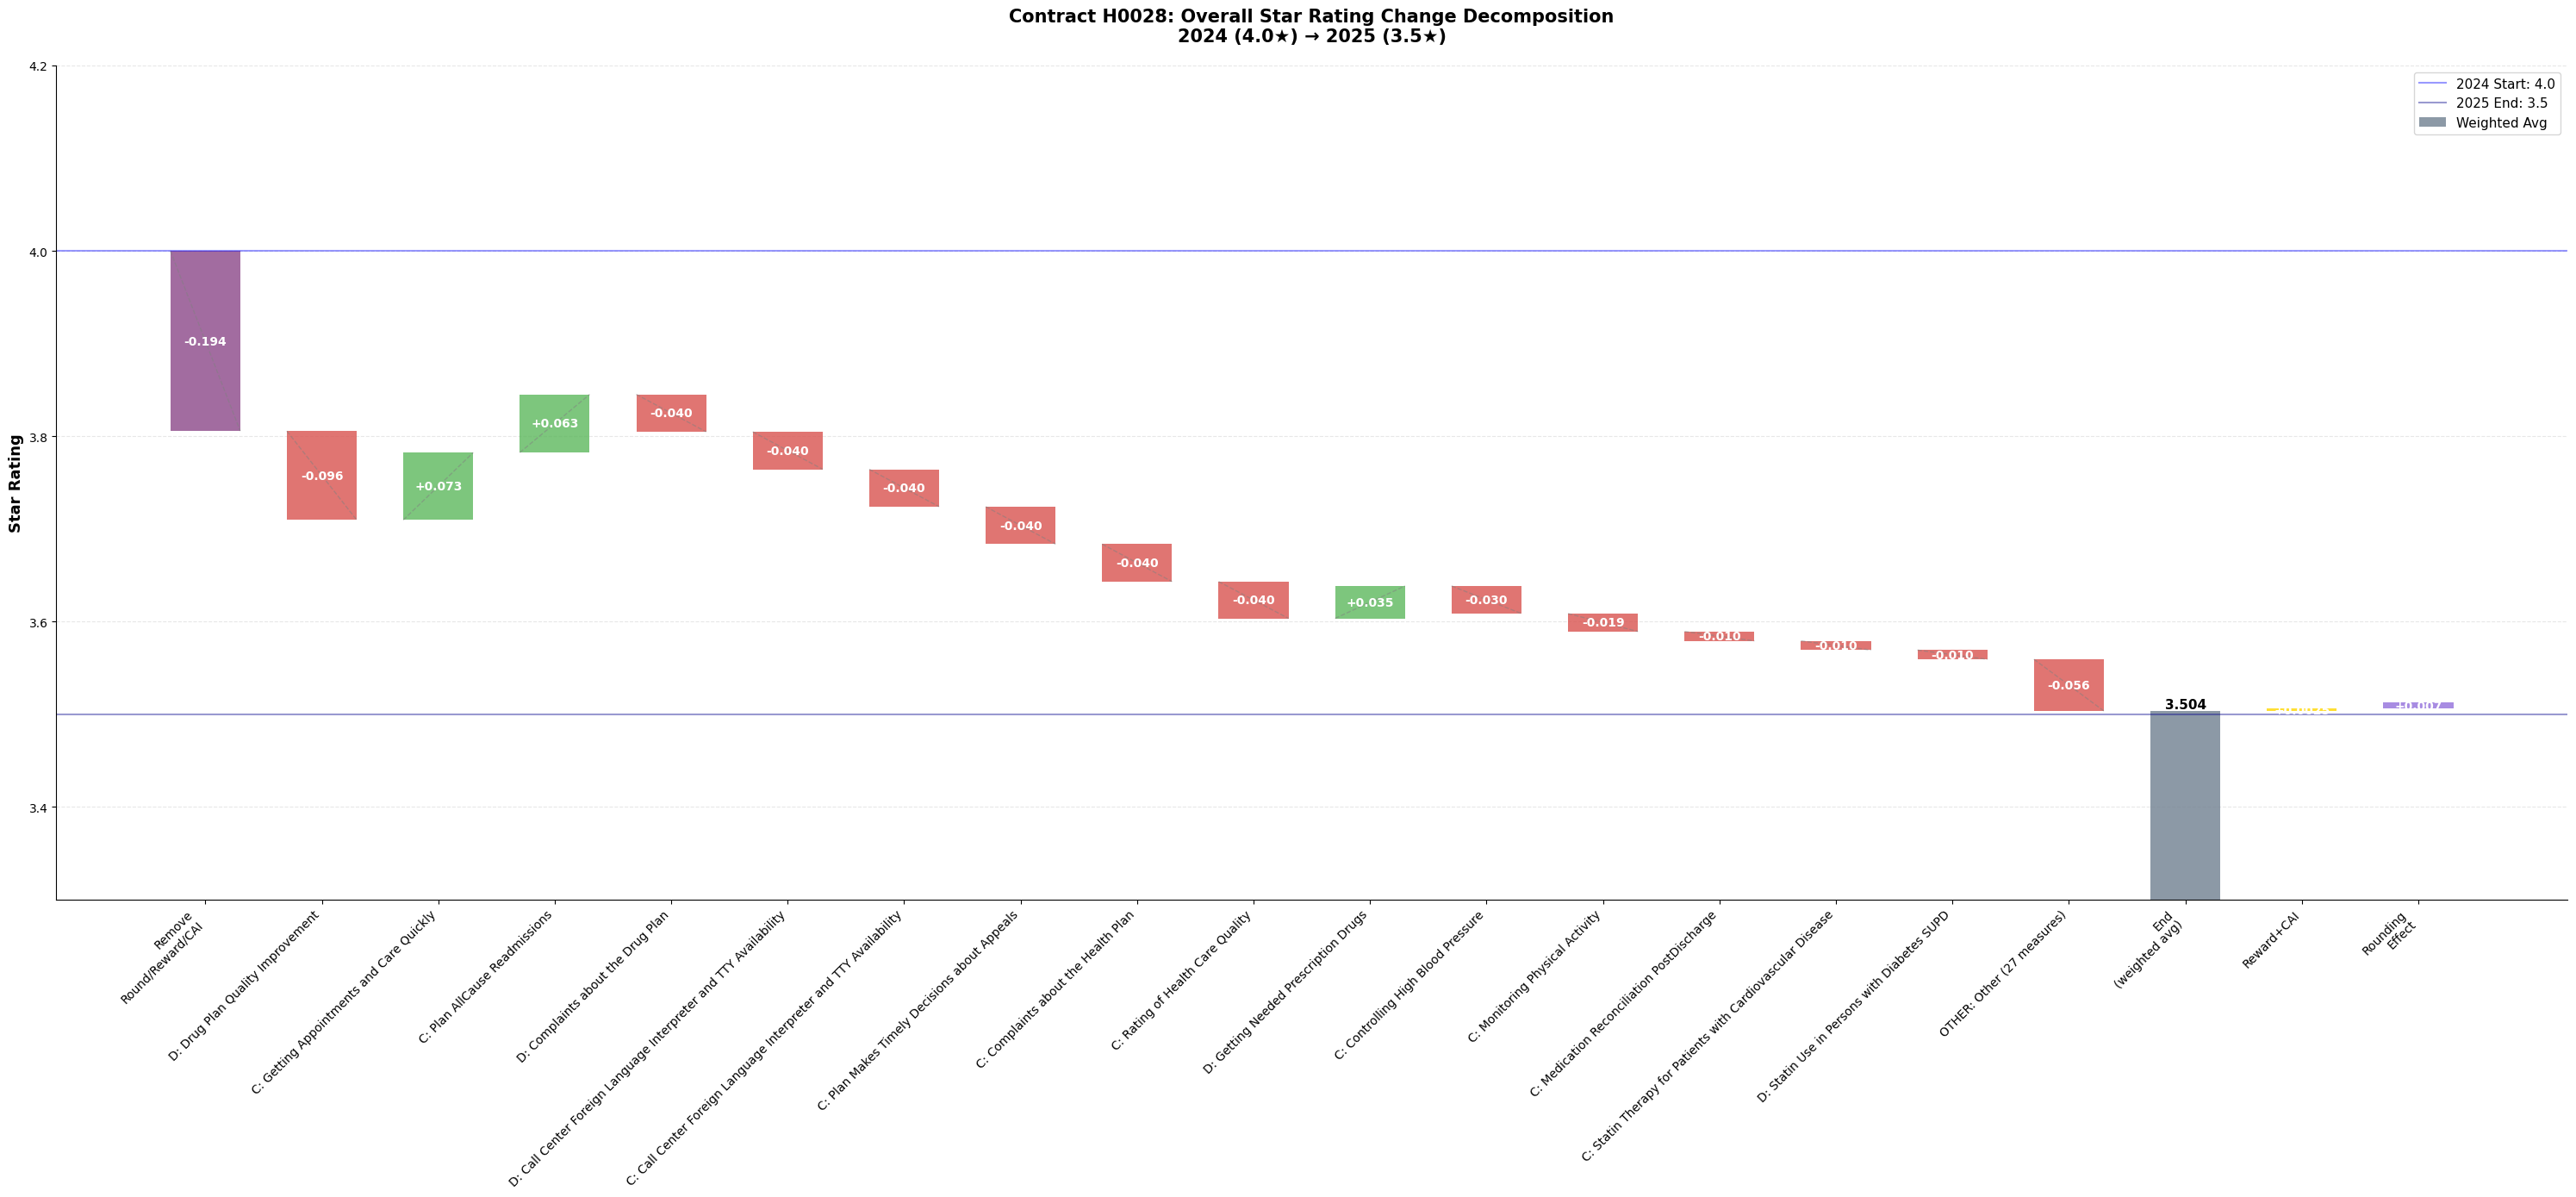

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_contract_waterfall(contract_id: str, df: pd.DataFrame, rating_type: str = "Overall", 
                               top_n: int = 15, show_start_bar: bool = True, show_end_bar: bool = True):
    """
    Create waterfall chart showing the journey from Year 1 Contract Star to Year 2 Contract Star.
    
    Flow: Y1 Rounded Star → Y1 Weighted Avg → [Measure Contributions] → Y2 Weighted Avg → Y2 Reward+CAI → Y2 Rounding → Y2 Rounded Star
    
    Args:
        contract_id: Specific contract to analyze (e.g., "H0028")
        df: DataFrame with measure-level data (final_df)
        rating_type: Which rating to analyze - "Part C", "Part D", or "Overall" (default: "Overall")
        top_n: Number of top contributors to show individually (rest grouped as "Other")
        show_start_bar: Whether to show the starting bar (default: True)
        show_end_bar: Whether to show the ending bar (default: True)
    
    Returns:
        DataFrame with measure-level contributions (sorted by absolute contribution)
    """
    # Validate rating_type
    valid_types = ["Part C", "Part D", "Overall"]
    if rating_type not in valid_types:
        print(f"✗ Invalid rating_type '{rating_type}'. Must be one of: {valid_types}")
        return None
    
    # Map rating type to columns
    inclusion_col_map = {
        "Part C": "Use Measure in Part C",
        "Part D": "Use Measure in Part D",
        "Overall": "Use Measure in Overall"
    }
    weighted_avg_col_map = {
        "Part C": "Weighted Avg Star Part C",
        "Part D": "Weighted Avg Star Part D",
        "Overall": "Weighted Avg Star Overall"
    }
    contract_star_col_map = {
        "Part C": "Part C Contract Star with Reward Factor and CAI",
        "Part D": "Part D Contract Star with Reward Factor and CAI",
        "Overall": "Overall Contract Star with Reward Factor and CAI"
    }
    reward_factor_col_map = {
        "Part C": "Reward Factor Part C",
        "Part D": "Reward Factor Part D",
        "Overall": "Reward Factor Overall"
    }
    cai_mapped_value_col_map = {
        "Part C": "Part_C_CAI_Mapped_Value",
        "Part D": "Part_D_CAI_Mapped_Value",
        "Overall": "Overall_CAI_Mapped_Value"
    }
    
    inclusion_col = inclusion_col_map[rating_type]
    weighted_avg_col = weighted_avg_col_map[rating_type]
    contract_star_col = contract_star_col_map[rating_type]
    reward_factor_col = reward_factor_col_map[rating_type]
    cai_mapped_value_col = cai_mapped_value_col_map[rating_type]
    
    print("=" * 70)
    print(f"CONTRACT WATERFALL: {contract_id} - {rating_type.upper()}")
    print("=" * 70)
    
    # Step 1: Filter to contract and applicable measures
    contract_data = df[
        (df['contract_id'] == contract_id) & 
        (df[inclusion_col] == True)
    ].copy()
    
    if len(contract_data) == 0:
        print(f"\n✗ No {rating_type} data found for contract {contract_id}")
        return None
    
    print(f"\n✓ Found {len(contract_data)} {rating_type} measure-year records for {contract_id}")
    
    # Step 2: Get year-over-year comparison setup
    years = sorted(contract_data['Year'].unique())
    if len(years) < 2:
        print(f"\n✗ Need 2 years of data. Found: {years}")
        return None
    
    year_1, year_2 = years[0], years[1]
    print(f"Comparing: {year_1} → {year_2}")
    
    # Get contract-level values for both years
    y1_contract = contract_data[contract_data['Year'] == year_1].iloc[0]
    y2_contract = contract_data[contract_data['Year'] == year_2].iloc[0]
    
    # Extract key values
    contract_star_y1 = y1_contract[contract_star_col]
    weighted_avg_y1 = y1_contract[weighted_avg_col]
    weighted_avg_y2 = y2_contract[weighted_avg_col]
    reward_factor_y2 = y2_contract[reward_factor_col]
    cai_mapped_value_y2 = y2_contract[cai_mapped_value_col] if pd.notna(y2_contract[cai_mapped_value_col]) else 0.0
    contract_star_y2 = y2_contract[contract_star_col]
    
    # Calculate contributions
    # 1. Un-round and remove reward/CAI (Year 1): from Contract Star Y1 to Weighted Avg Y1
    unround_reward_cai_y1 = weighted_avg_y1 - contract_star_y1
    
    # 2. Measure contributions will be calculated below
    
    # 3. Combined Reward Factor + CAI (Year 2)
    reward_cai_combined_y2 = reward_factor_y2 + cai_mapped_value_y2
    
    # 4. Rounding effect (Year 2): from (Weighted Avg + Reward + CAI) to Contract Star (final rounded)
    rounding_y2 = contract_star_y2 - (weighted_avg_y2 + reward_factor_y2 + cai_mapped_value_y2)
    
    print(f"\nKey values:")
    print(f"  {year_1} Contract Star (rounded w/ reward+CAI): {contract_star_y1:.2f}")
    print(f"  {year_1} Weighted Avg (raw): {weighted_avg_y1:.4f}")
    print(f"  Change to remove rounding/reward/CAI Y1: {unround_reward_cai_y1:+.4f}")
    print(f"\n  {year_2} Weighted Avg (raw): {weighted_avg_y2:.4f}")
    print(f"  {year_2} Reward Factor: {reward_factor_y2:.2f}")
    print(f"  {year_2} CAI: {cai_mapped_value_y2:+.6f}")
    print(f"  {year_2} Combined Reward+CAI: {reward_cai_combined_y2:+.4f}")
    print(f"  {year_2} Weighted Avg + Reward + CAI: {weighted_avg_y2 + reward_factor_y2 + cai_mapped_value_y2:.4f}")
    print(f"  Rounding effect Y2 (on weighted+reward+CAI): {rounding_y2:+.4f}")
    print(f"  {year_2} Contract Star (final rounded): {contract_star_y2:.2f}")
    
    # Recalculate weight sums
    weight_sum_y1 = contract_data[contract_data['Year'] == year_1]['Weight'].sum()
    weight_sum_y2 = contract_data[contract_data['Year'] == year_2]['Weight'].sum()
    
    if weight_sum_y1 == 0 or weight_sum_y2 == 0:
        print(f"\n✗ Weight sum is zero for one or both years")
        return None
    
    print(f"\nWeight sums: {year_1}={weight_sum_y1:.2f}, {year_2}={weight_sum_y2:.2f}")
    
    # Get measure data for each year
    y1_data = contract_data[contract_data['Year'] == year_1][
        ['measure_code', 'measure_name', 'star_rating_numeric', 'Weight']
    ].rename(columns={
        'star_rating_numeric': 'star_y1',
        'Weight': 'weight_y1'
    })
    
    y2_data = contract_data[contract_data['Year'] == year_2][
        ['measure_code', 'measure_name', 'star_rating_numeric', 'Weight']
    ].rename(columns={
        'star_rating_numeric': 'star_y2',
        'Weight': 'weight_y2'
    })
    
    # Merge on measure_code
    measures = y1_data.merge(y2_data, on=['measure_code', 'measure_name'], how='outer')
    
    # Fill NaN for new/dropped measures
    measures['star_y1'] = measures['star_y1'].fillna(0)
    measures['star_y2'] = measures['star_y2'].fillna(0)
    measures['weight_y1'] = measures['weight_y1'].fillna(0)
    measures['weight_y2'] = measures['weight_y2'].fillna(0)
    
    # Calculate measure contributions to weighted average
    measures['performance'] = (measures['weight_y1'] / weight_sum_y1) * (measures['star_y2'] - measures['star_y1'])
    measures['mix'] = ((measures['weight_y2'] / weight_sum_y2) - (measures['weight_y1'] / weight_sum_y1)) * measures['star_y1']
    measures['contribution'] = measures['performance'] + measures['mix']
    
    # Calculate changes for labeling
    measures['star_change'] = measures['star_y2'] - measures['star_y1']
    measures['weight_change'] = measures['weight_y2'] - measures['weight_y1']
    
    # Create measure labels
    measures['measure_prefix'] = measures['measure_code'].str[0]
    measures['measure_label'] = measures['measure_prefix'] + ': ' + measures['measure_name']
    
    # Filter out zero contributions
    measures = measures[measures['contribution'] != 0].copy()
    
    if len(measures) == 0:
        print(f"\n✗ No measures with non-zero contributions")
        return None
    
    print(f"Measures with impact: {len(measures)}")
    
    # Sort by absolute contribution
    measures['abs_contribution'] = measures['contribution'].abs()
    measures = measures.sort_values('abs_contribution', ascending=False)
    
    # Group tail into "Other" if needed
    if len(measures) > top_n:
        top_measures = measures.head(top_n).copy()
        other_measures = measures.iloc[top_n:].copy()
        
        other_row = pd.DataFrame([{
            'measure_code': 'OTHER',
            'measure_name': f'Other ({len(other_measures)} measures)',
            'measure_label': f'OTHER: Other ({len(other_measures)} measures)',
            'contribution': other_measures['contribution'].sum(),
            'performance': other_measures['performance'].sum(),
            'mix': other_measures['mix'].sum(),
            'star_change': None,
            'weight_change': None,
            'star_y1': None,
            'star_y2': None,
            'weight_y1': None,
            'weight_y2': None
        }])
        
        measures_display = pd.concat([top_measures, other_row], ignore_index=True)
        print(f"Showing top {top_n} measures + Other group")
    else:
        measures_display = measures.copy()
    
    # Summary
    total_measure_contribution = measures['contribution'].sum()
    total_change = contract_star_y2 - contract_star_y1
    
    print(f"\nDecomposition:")
    print(f"  Starting ({year_1} Contract Star): {contract_star_y1:.2f}")
    print(f"  Un-round/remove reward/CAI: {unround_reward_cai_y1:+.4f} → Weighted Avg {year_1}")
    print(f"  Measure contributions: {total_measure_contribution:+.4f}")
    print(f"    - Performance: {measures['performance'].sum():+.4f}")
    print(f"    - Mix: {measures['mix'].sum():+.4f}")
    print(f"  → Weighted Avg {year_2}: {weighted_avg_y2:.4f}")
    print(f"  Reward+CAI Y2: {reward_cai_combined_y2:+.4f}")
    print(f"  Rounding effect Y2 (on weighted+reward+CAI): {rounding_y2:+.4f}")
    print(f"  Ending ({year_2} Contract Star): {contract_star_y2:.2f}")
    print(f"Total change: {total_change:+.2f} stars")
    
    # Build waterfall
    measure_labels = measures_display['measure_label'].tolist()
    contributions = measures_display['contribution'].tolist()
    
    # Cumulative - starting from contract_star_y1
    cumulative = [contract_star_y1]
    cumulative.append(cumulative[-1] + unround_reward_cai_y1)  # After un-rounding
    
    for contrib in contributions:
        cumulative.append(cumulative[-1] + contrib)
    
    # After all measures, we're at weighted_avg_y2
    
    # Create figure
    # Calculate number of bars dynamically
    n_bars = 0
    if show_start_bar:
        n_bars += 1
    n_bars += 1  # Unround
    n_bars += len(measure_labels)  # Measures
    n_bars += 1  # End (weighted avg)
    n_bars += 1  # Reward+CAI combined
    n_bars += 1  # Rounding
    if show_end_bar:
        n_bars += 1
    
    fig, ax = plt.subplots(figsize=(max(24, n_bars * 1.5), 14))
    
    # Build labels and positions
    bar_labels = []
    x_positions = []
    bar_idx = 0
    
    # Track positions for cumulative indexing
    cum_idx = 0
    
    # Starting bar (optional)
    if show_start_bar:
        bar_labels.append('Start\n' + str(year_1))
        x_positions.append(bar_idx)
        ax.bar(bar_idx, contract_star_y1, color='#4A90E2', alpha=0.8, width=0.6)
        ax.text(bar_idx, contract_star_y1/2, f'{contract_star_y1:.2f}', 
               ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        bar_idx += 1
    
    # Un-round/remove reward/CAI bar
    bar_labels.append('Remove\nRound/Reward/CAI')
    x_positions.append(bar_idx)
    
    if unround_reward_cai_y1 > 0:
        bottom = cumulative[cum_idx]
        color = '#9370DB'
    else:
        bottom = cumulative[cum_idx + 1]
        color = '#8B4789'
    
    ax.bar(bar_idx, abs(unround_reward_cai_y1), bottom=bottom, color=color, alpha=0.8, width=0.6)
    ax.text(bar_idx, bottom + abs(unround_reward_cai_y1)/2, f'{unround_reward_cai_y1:+.3f}', 
           ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    bar_idx += 1
    cum_idx += 1
    
    # Measure contribution bars (no labels - keeps legend clean)
    for i, contrib in enumerate(contributions):
        bar_labels.append(measure_labels[i])
        x_positions.append(bar_idx)
        cum_idx += 1
        
        if contrib > 0:
            bottom = cumulative[cum_idx - 1]
            color = '#5CB85C'
        else:
            bottom = cumulative[cum_idx]
            color = '#D9534F'
        
        ax.bar(bar_idx, abs(contrib), bottom=bottom, color=color, alpha=0.8, width=0.6)
        ax.text(bar_idx, bottom + abs(contrib)/2, f'{contrib:+.3f}', 
               ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        bar_idx += 1
    
    # End (weighted avg) bar - WITH LABEL for legend
    bar_labels.append('End\n(weighted avg)')
    x_positions.append(bar_idx)
    end_weighted = cumulative[-1]
    ax.bar(bar_idx, abs(end_weighted), bottom=min(0, end_weighted), 
           color='#708090', alpha=0.8, width=0.6, label='Weighted Avg')
    ax.text(bar_idx, end_weighted, f'{end_weighted:.3f}', 
           ha='center', va='bottom' if end_weighted > 0 else 'top', fontsize=11, fontweight='bold')
    bar_idx += 1
    
    # Combined Reward Factor + CAI bar (Y2)
    bar_labels.append('Reward+CAI')
    x_positions.append(bar_idx)
    
    if reward_cai_combined_y2 > 0:
        bottom_combined = end_weighted
        color_combined = '#FFD700'
    else:
        bottom_combined = end_weighted + reward_cai_combined_y2
        color_combined = '#FFA500'
    
    ax.bar(bar_idx, abs(reward_cai_combined_y2), bottom=bottom_combined, 
           color=color_combined, alpha=0.8, width=0.6)
    ax.text(bar_idx, bottom_combined + abs(reward_cai_combined_y2)/2, f'{reward_cai_combined_y2:+.4f}', 
           ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    bar_idx += 1
    
    # Rounding effect bar (Y2) - AFTER reward and CAI
    bar_labels.append('Rounding\nEffect')
    x_positions.append(bar_idx)
    end_after_reward_cai = end_weighted + reward_cai_combined_y2
    
    if rounding_y2 > 0:
        bottom_rounding = end_after_reward_cai
        color_rounding = '#9370DB'
    else:
        bottom_rounding = end_after_reward_cai + rounding_y2
        color_rounding = '#8B4789'
    
    ax.bar(bar_idx, abs(rounding_y2), bottom=bottom_rounding, 
           color=color_rounding, alpha=0.8, width=0.6)
    ax.text(bar_idx, bottom_rounding + abs(rounding_y2)/2, f'{rounding_y2:+.3f}', 
           ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    bar_idx += 1
    
    # Final ending bar (optional)
    if show_end_bar:
        bar_labels.append('End\n' + str(year_2))
        x_positions.append(bar_idx)
        ax.bar(bar_idx, contract_star_y2, color='#4A90E2', alpha=0.8, width=0.6)
        ax.text(bar_idx, contract_star_y2/2, f'{contract_star_y2:.2f}', 
               ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        bar_idx += 1
    
    # Connecting lines (simplified)
    for i in range(len(cumulative) - 1):
        start_x = (1 if show_start_bar else 0) + i
        ax.plot([start_x - 0.3, start_x + 0.3], [cumulative[i], cumulative[i+1]], 
               color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Star Rating', fontsize=13, fontweight='bold')
    ax.set_title(f'Contract {contract_id}: {rating_type} Star Rating Change Decomposition\n{year_1} ({contract_star_y1:.1f}★) → {year_2} ({contract_star_y2:.1f}★)', 
                fontsize=15, fontweight='bold', pad=20)
    
    # Set y-axis range
    y_min = min(contract_star_y1, contract_star_y2, min(cumulative)) - 0.2
    y_max = max(contract_star_y1, contract_star_y2, max(cumulative)) + 0.2
    ax.set_ylim(y_min, y_max)
    
    # Add horizontal reference lines (WITH LABELS for legend)
    ax.axhline(y=contract_star_y1, color='blue', linestyle='-', linewidth=1.5, alpha=0.4, 
               label=f'{year_1} Start: {contract_star_y1:.1f}')
    ax.axhline(y=contract_star_y2, color='darkblue', linestyle='-', linewidth=1.5, alpha=0.4, 
               label=f'{year_2} End: {contract_star_y2:.1f}')
    
    # Simplified legend - only show year lines and weighted avg
    ax.legend(loc='best', fontsize=11)
    
    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return measures_display


# Example usage
use_contract = "H0028"
waterfall_df = create_contract_waterfall(use_contract, final_df, rating_type="Overall", top_n=15, 
                                         show_start_bar=False, show_end_bar=False)

In [204]:
waterfall_df.head()

,measure_code,measure_name,star_y1,weight_y1,star_y2,weight_y2,performance,mix,contribution,star_change,weight_change,measure_prefix,measure_label,abs_contribution
0,D04,Drug Plan Quality Improvement,4.0,5.0,2.0,5.0,-0.092593,-0.003367,-0.095960,-2.0,0.0,D,D: Drug Plan Quality Improvement,0.095960
1,C20,Getting Appointments and Care Quickly,2.0,4.0,4.0,4.0,0.074074,-0.001347,0.072727,2.0,0.0,C,C: Getting Appointments and Care Quickly,0.072727
2,C15,Plan AllCause Readmissions,4.0,1.0,3.0,3.0,-0.009259,0.072054,0.062795,-1.0,2.0,C,C: Plan AllCause Readmissions,0.062795
3,D02,Complaints about the Drug Plan,5.0,4.0,4.0,4.0,-0.037037,-0.003367,-0.040404,-1.0,0.0,D,D: Complaints about the Drug Plan,0.040404
4,D01,Call Center Foreign Language Interpreter and T...,5.0,4.0,4.0,4.0,-0.037037,-0.003367,-0.040404,-1.0,0.0,D,D: Call Center Foreign Language Interpreter an...,0.040404


In [205]:
contract_row = pivoted_df[pivoted_df["contract_id"] == use_contract]
columns = contract_row.columns
cols = ["Year", "contract_id"]
for col in columns:
    if ("Overall" in col and "Reward" in col) or ("Overall Summary" in col):
        cols.append(col)

contract_row = contract_row[cols]
contract_row.head()

,Year,contract_id,Overall Summary,Reward Factor Overall,Overall Contract Star with Reward Factor,Overall Contract Star without Reward Factor,Overall Contract Star with Reward Factor and CAI,Overall Match with Reward,Overall Match without Reward,Overall Match with Reward and CAI
5,2024,H0028,4.0,0.2,4.0,4.0,4.0,True,True,True
6,2025,H0028,3.5,0.0,3.5,3.5,3.5,True,True,True
7,2026,H0028,3.5,0.0,3.5,3.5,3.5,True,True,True


In [206]:
enrollment_df = pd.read_csv("data/other_data/medicare_advantage_and_partd_enrollment_by_contract_parent_mapped.csv")
cols = ["Release Year", "Contract Number", "Enrollment", "Current Owner"]
enrollment_df = enrollment_df[cols]

# Parse year from Release Year (format: "01/01/2025" -> 2025)
enrollment_df['Year'] = pd.to_datetime(enrollment_df['Release Year']).dt.year

# restrict to 2020 or later
enrollment_df = enrollment_df[enrollment_df['Year'] >= 2020]

# Aggregate: sum enrollment by Contract Number and Year
enrollment_df = enrollment_df.groupby(['Contract Number', 'Year', 'Current Owner'], as_index=False).agg({
    'Enrollment': 'sum'
})

# Rename for consistency with other dataframes
enrollment_df = enrollment_df.rename(columns={'Contract Number': 'contract_id'})

print(f"Enrollment aggregated:")
print(f"  Shape: {enrollment_df.shape}")
print(f"  Years: {sorted(enrollment_df['Year'].unique())}")
print(f"  Contracts: {enrollment_df['contract_id'].nunique():,}")
print(f"\nSample:")
enrollment_df.head(10)

Enrollment aggregated:
  Shape: (5837, 4)
  Years: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
  Contracts: 1,214

Sample:


,contract_id,Year,Current Owner,Enrollment
0,90091,2020,UMWA Health and Retirement Funds,46094.0
1,90091,2021,UMWA Health and Retirement Funds,44687.0
2,90091,2022,UMWA Health and Retirement Funds,43928.0
3,90091,2023,UMWA Health and Retirement Funds,42537.0
4,90091,2024,UMWA Health and Retirement Funds,41256.0
5,90091,2025,UMWA Health and Retirement Funds,39889.0
6,E0654,2020,IBT Voluntary Employee Benefits Trust,15292.0
7,E0654,2021,IBT Voluntary Employee Benefits Trust,14143.0
8,E0654,2022,IBT Voluntary Employee Benefits Trust,13778.0
9,E3014,2020,Commonwealth of PA Pub Schools Retirement System,95328.0


In [207]:
# Join enrollment data to pivoted_df (contract-year grain)
print("=" * 60)
print("JOINING ENROLLMENT DATA TO PIVOTED_DF")
print("=" * 60)

# Join enrollment to pivoted_df
pivoted_df_with_enrollment = pivoted_df.merge(
    enrollment_df,
    on=['contract_id', 'Year'],
    how='left'
)

print(f"\nJoin complete:")
print(f"  Contract-year records: {len(pivoted_df_with_enrollment):,}")
print(f"  Records with enrollment: {pivoted_df_with_enrollment['Enrollment'].notna().sum():,}")
print(f"  Records missing enrollment: {pivoted_df_with_enrollment['Enrollment'].isna().sum():,}")

# Check if Current Owner exists
if 'Current Owner' in pivoted_df_with_enrollment.columns:
    print(f"\n✓ Current Owner column found")
    print(f"  Top companies by contract-years:")
    print(pivoted_df_with_enrollment['Current Owner'].value_counts().head(10))
else:
    print(f"\n✗ Current Owner column not found")
    print(f"  Available org columns: {[col for col in pivoted_df_with_enrollment.columns if 'owner' in col.lower() or 'parent' in col.lower() or 'organization' in col.lower()]}")

print(f"\nSample joined data:")
pivoted_df_with_enrollment[['contract_id', 'Year', 'Current Owner', 'Enrollment', 
                             'Overall Contract Star with Reward Factor and CAI']].head(10)

JOINING ENROLLMENT DATA TO PIVOTED_DF

Join complete:
  Contract-year records: 2,415
  Records with enrollment: 1,614
  Records missing enrollment: 801

✓ Current Owner column found
  Top companies by contract-years:
Current Owner
Centene Corporation                183
UnitedHealth Group, Inc.           143
Elevance Health, Inc.               94
CVS Health Corporation              90
Humana Inc.                         86
Devoted Health, Inc.                57
Molina Healthcare, Inc              47
Health Care Service Corporation     43
Mitchell Family Office              23
Independence Health Group           20
Name: count, dtype: int64

Sample joined data:


,contract_id,Year,Current Owner,Enrollment,Overall Contract Star with Reward Factor and CAI
0,E3014,2024,Commonwealth of PA Pub Schools Retirement System,96792.0,NaN
1,E3014,2025,Commonwealth of PA Pub Schools Retirement System,95509.0,NaN
2,E3014,2026,NaN,NaN,NaN
3,H0022,2024,Centene Corporation,10206.0,NaN
4,H0022,2025,Centene Corporation,8616.0,NaN
5,H0028,2024,Humana Inc.,381180.0,4.0
6,H0028,2025,Humana Inc.,367209.0,3.5
7,H0028,2026,NaN,NaN,3.5
8,H0029,2024,Centene Corporation,0.0,NaN
9,H0029,2025,Centene Corporation,17534.0,NaN


COMPANY WATERFALL: Humana Inc. - OVERALL
Comparing 2024 → 2025

✓ Found 71 contract-year records

2024:
  Contracts: 40
  Total enrollment: 6,189,286

2025:
  Contracts: 31
  Total enrollment: 5,807,893

Enrollment-weighted Overall stars:
  2024: 4.3626
  2025: 3.5594
  Change: -0.8032

Contracts in BOTH years: 30
Contracts with impact: 30
Showing top 10 contracts + Other group


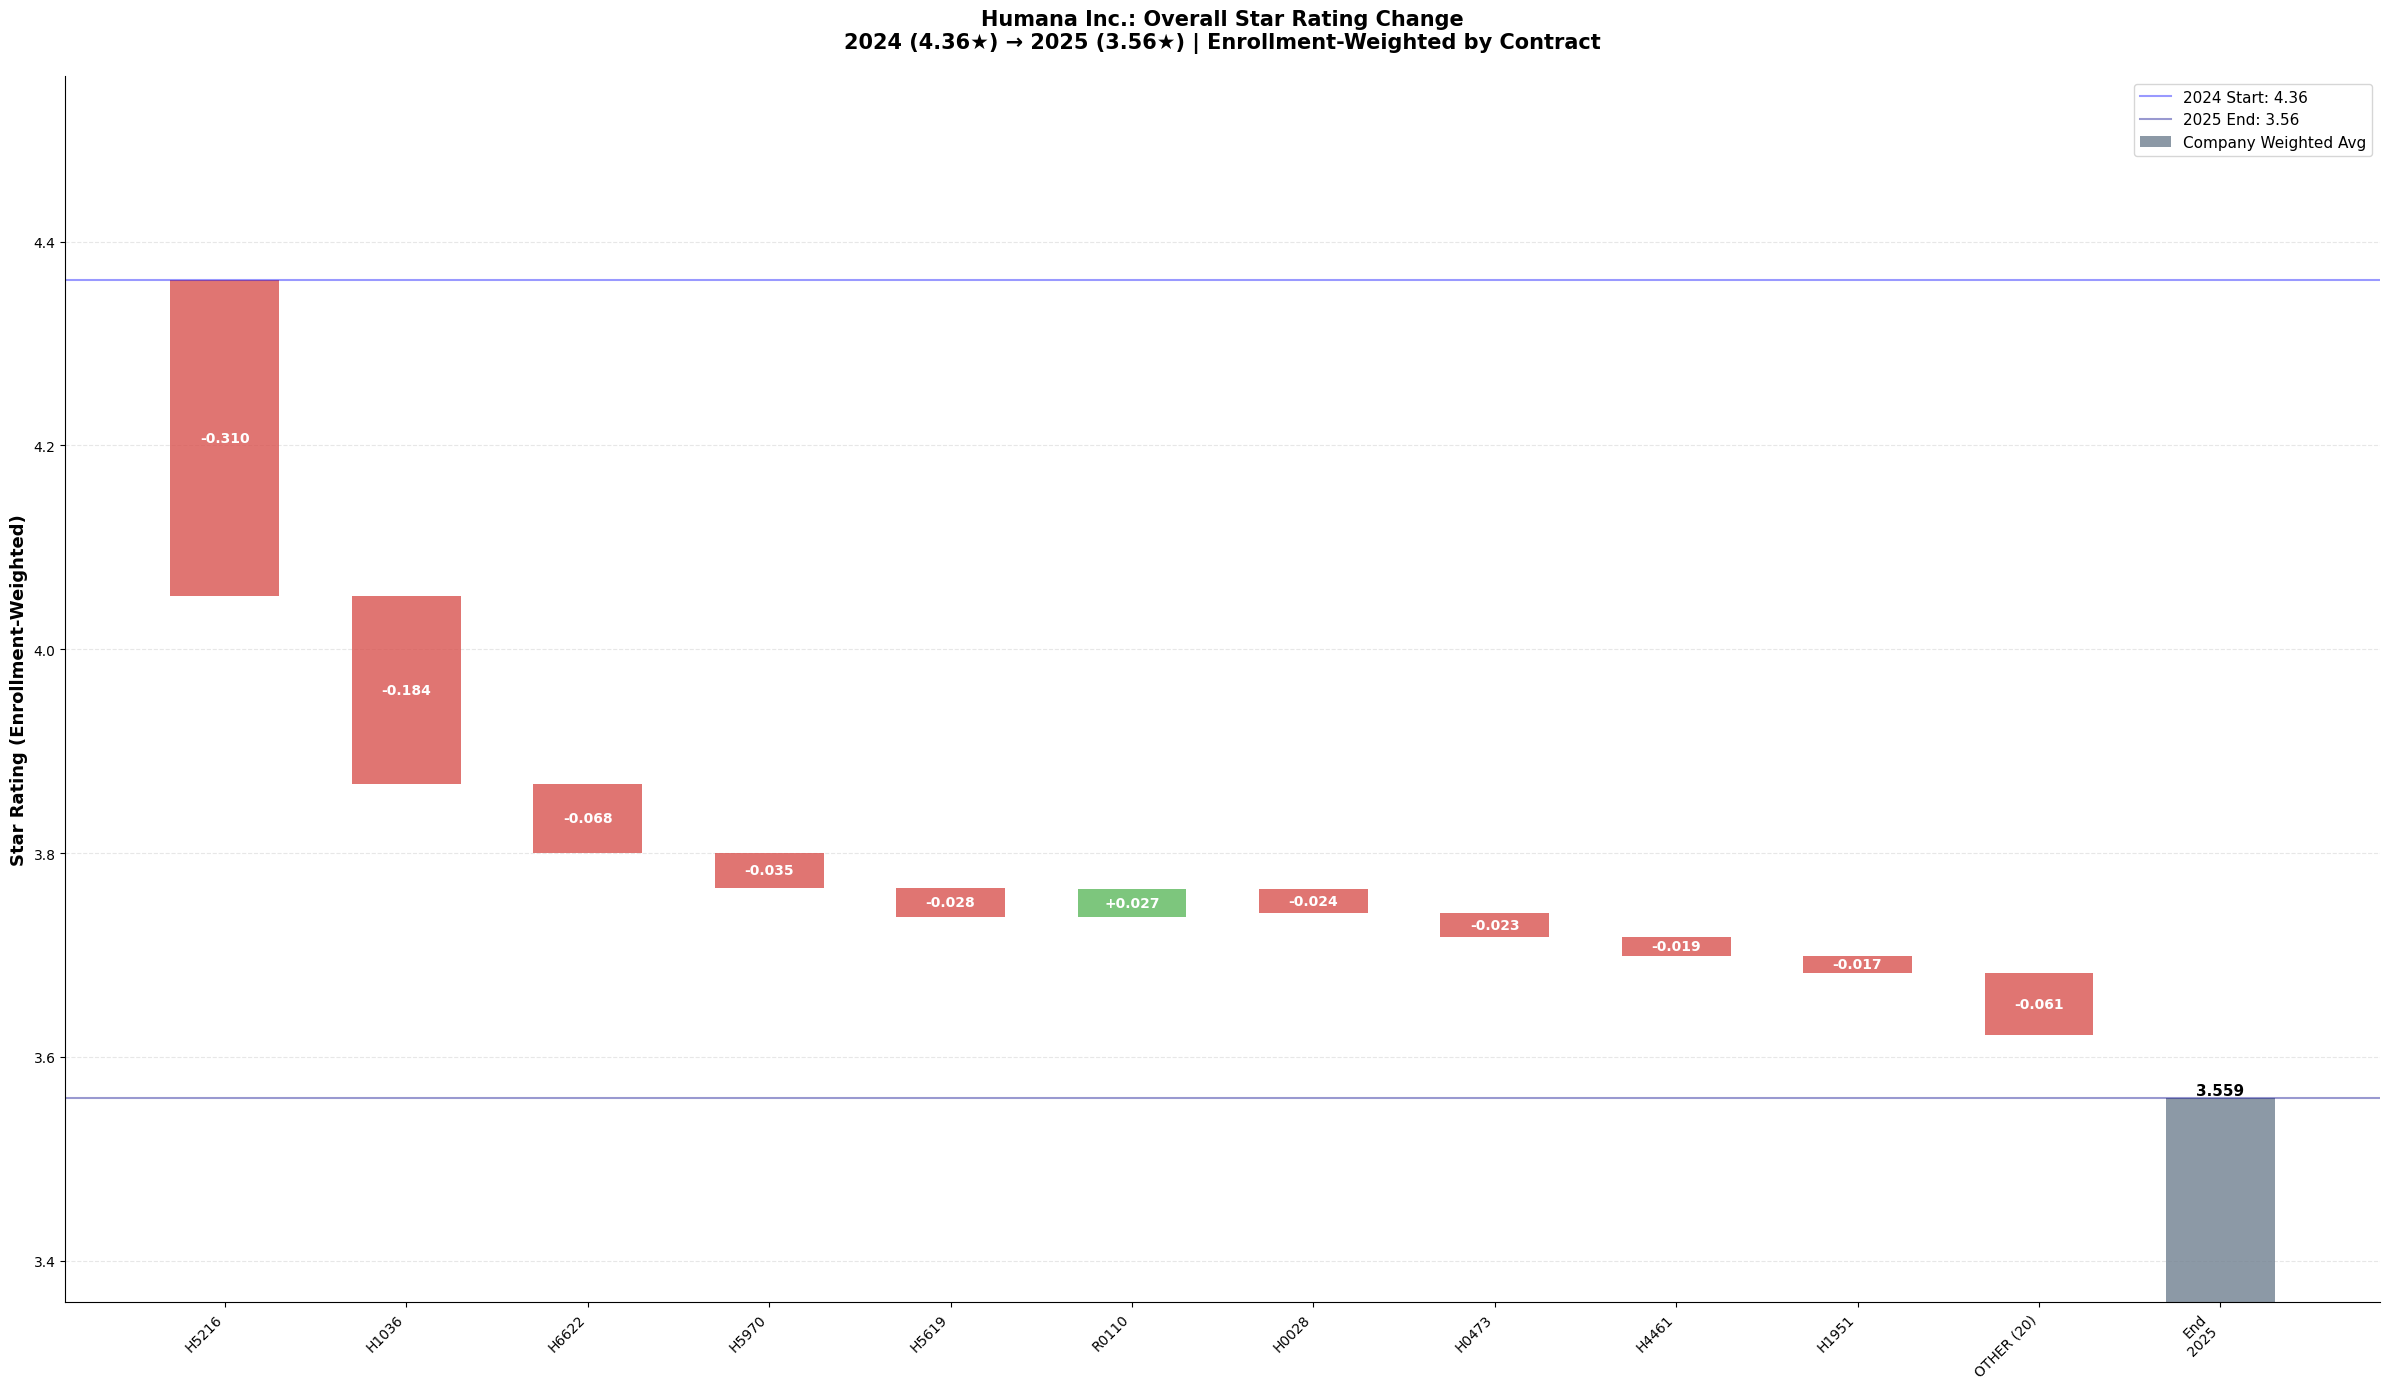


DECOMPOSITION SUMMARY
Total change: -0.8032 stars
  Performance effect: -0.8035
  Mix effect: +0.0623

Top 10 contracts by impact:
  1. H5216: -0.3102 stars
  2. H1036: -0.1842 stars
  3. H6622: -0.0676 stars
  4. H5970: -0.0347 stars
  5. H5619: -0.0281 stars
  6. R0110: +0.0275 stars
  7. H0028: -0.0242 stars
  8. H0473: -0.0229 stars
  9. H4461: -0.0188 stars
  10. H1951: -0.0169 stars


In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_company_waterfall(company_name: str, df: pd.DataFrame, rating_type: str = "Overall",
                              year_1: int = 2024, year_2: int = 2025, top_n: int = 3,
                              show_start_bar: bool = False, show_end_bar: bool = False):
    """
    Create enrollment-weighted waterfall showing company star rating change across contracts.
    Only includes contracts with enrollment and star ratings in BOTH years.
    
    Args:
        company_name: Current Owner name
        df: DataFrame with contract-year data (pivoted_df_with_enrollment)
        rating_type: "Part C", "Part D", or "Overall"
        year_1: Starting year (default: 2024)
        year_2: Ending year (default: 2025)
        top_n: Number of top contract contributors to show individually (default: 3)
        show_start_bar: Whether to show starting bar
        show_end_bar: Whether to show ending bar
    
    Returns:
        Tuple: (contracts_display DataFrame, list of displayed contract IDs)
    """
    # Map rating type to star column
    star_col_map = {
        "Part C": "Part C Contract Star with Reward Factor and CAI",
        "Part D": "Part D Contract Star with Reward Factor and CAI",
        "Overall": "Overall Contract Star with Reward Factor and CAI"
    }
    
    star_col = star_col_map.get(rating_type)
    if not star_col:
        print(f"✗ Invalid rating_type '{rating_type}'")
        return None, []
    
    print("=" * 70)
    print(f"COMPANY WATERFALL: {company_name} - {rating_type.upper()}")
    print(f"Comparing {year_1} → {year_2}")
    print("=" * 70)
    
    # Filter to company and years with valid enrollment and star ratings
    company_data = df[
        (df['Current Owner'] == company_name) &
        (df['Year'].isin([year_1, year_2])) &
        (df['Enrollment'].notna()) &
        (df['Enrollment'] > 0) &
        (df[star_col].notna())
    ].copy()
    
    if len(company_data) == 0:
        print(f"\n✗ No data found for {company_name}")
        return None, []
    
    print(f"\n✓ Found {len(company_data)} contract-year records")
    
    # Calculate enrollment weights for each year
    for year in [year_1, year_2]:
        year_data = company_data[company_data['Year'] == year]
        total_enrollment = year_data['Enrollment'].sum()
        
        if total_enrollment == 0:
            print(f"\n✗ Zero enrollment for {year}")
            return None, []
        
        company_data.loc[company_data['Year'] == year, 'Enrollment_Pct'] = (
            company_data.loc[company_data['Year'] == year, 'Enrollment'] / total_enrollment
        )
        
        print(f"\n{year}:")
        print(f"  Contracts: {len(year_data)}")
        print(f"  Total enrollment: {total_enrollment:,.0f}")
    
    # Calculate enrollment-weighted star rating for each year
    y1_data = company_data[company_data['Year'] == year_1]
    y2_data = company_data[company_data['Year'] == year_2]
    
    company_star_y1 = (y1_data[star_col] * y1_data['Enrollment_Pct']).sum()
    company_star_y2 = (y2_data[star_col] * y2_data['Enrollment_Pct']).sum()
    
    print(f"\nEnrollment-weighted {rating_type} stars:")
    print(f"  {year_1}: {company_star_y1:.4f}")
    print(f"  {year_2}: {company_star_y2:.4f}")
    print(f"  Change: {company_star_y2 - company_star_y1:+.4f}")
    
    # Merge to get both years' data for each contract
    # Use INNER join to only keep contracts present in BOTH years
    contracts = y1_data[['contract_id', 'Contract Name', star_col, 'Enrollment', 'Enrollment_Pct']].rename(columns={
        star_col: 'star_y1',
        'Enrollment': 'enrollment_y1',
        'Enrollment_Pct': 'pct_y1'
    }).merge(
        y2_data[['contract_id', star_col, 'Enrollment', 'Enrollment_Pct']].rename(columns={
            star_col: 'star_y2',
            'Enrollment': 'enrollment_y2',
            'Enrollment_Pct': 'pct_y2'
        }),
        on='contract_id',
        how='inner'  # Only contracts in BOTH years
    )
    
    print(f"\nContracts in BOTH years: {len(contracts)}")
    
    # Calculate contract contributions (performance + mix effect)
    contracts['performance'] = contracts['pct_y1'] * (contracts['star_y2'] - contracts['star_y1'])
    contracts['mix'] = (contracts['pct_y2'] - contracts['pct_y1']) * contracts['star_y1']
    contracts['contribution'] = contracts['performance'] + contracts['mix']
    
    # Filter non-zero contributions
    contracts = contracts[contracts['contribution'] != 0].copy()
    
    if len(contracts) == 0:
        print(f"\n✗ No contracts with non-zero contributions")
        return None, []
    
    print(f"Contracts with impact: {len(contracts)}")
    
    # Sort by absolute contribution
    contracts['abs_contribution'] = contracts['contribution'].abs()
    contracts = contracts.sort_values('abs_contribution', ascending=False)
    
    # Create contract labels (just contract ID)
    contracts['contract_label'] = contracts['contract_id']
    
    # Group tail into "Other" if needed
    if len(contracts) > top_n:
        top_contracts = contracts.head(top_n).copy()
        other_contracts = contracts.iloc[top_n:].copy()
        
        other_row = pd.DataFrame([{
            'contract_id': 'OTHER',
            'Contract Name': f'Other ({len(other_contracts)} contracts)',
            'contract_label': f'OTHER ({len(other_contracts)})',
            'contribution': other_contracts['contribution'].sum(),
            'performance': other_contracts['performance'].sum(),
            'mix': other_contracts['mix'].sum()
        }])
        
        contracts_display = pd.concat([top_contracts, other_row], ignore_index=True)
        print(f"Showing top {top_n} contracts + Other group")
        # Return displayed contract IDs (excluding OTHER)
        displayed_contracts = top_contracts['contract_id'].tolist()
    else:
        contracts_display = contracts.copy()
        displayed_contracts = contracts['contract_id'].tolist()
    
    # Build waterfall visualization
    contract_labels = contracts_display['contract_label'].tolist()
    contributions = contracts_display['contribution'].tolist()
    
    # Cumulative values
    cumulative = [company_star_y1]
    for contrib in contributions:
        cumulative.append(cumulative[-1] + contrib)
    
    # Create figure
    n_bars = len(contract_labels) + 1  # contracts + weighted avg bar
    if show_start_bar:
        n_bars += 1
    if show_end_bar:
        n_bars += 1
    
    fig, ax = plt.subplots(figsize=(max(24, n_bars * 1.5), 14))
    
    bar_labels = []
    x_positions = []
    bar_idx = 0
    
    # Starting bar (optional)
    if show_start_bar:
        bar_labels.append(f'Start\n{year_1}')
        x_positions.append(bar_idx)
        ax.bar(bar_idx, company_star_y1, color='#4A90E2', alpha=0.8, width=0.6)
        ax.text(bar_idx, company_star_y1/2, f'{company_star_y1:.3f}', 
               ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        bar_idx += 1
    
    # Contract contribution bars
    cum_idx = 0
    for i, contrib in enumerate(contributions):
        bar_labels.append(contract_labels[i])
        x_positions.append(bar_idx)
        
        if contrib > 0:
            bottom = cumulative[cum_idx]
            color = '#5CB85C'
        else:
            bottom = cumulative[cum_idx + 1]
            color = '#D9534F'
        
        ax.bar(bar_idx, abs(contrib), bottom=bottom, color=color, alpha=0.8, width=0.6)
        ax.text(bar_idx, bottom + abs(contrib)/2, f'{contrib:+.3f}', 
               ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        bar_idx += 1
        cum_idx += 1
    
    # End (weighted avg) bar
    bar_labels.append(f'End\n{year_2}')
    x_positions.append(bar_idx)
    ax.bar(bar_idx, abs(company_star_y2), bottom=min(0, company_star_y2), 
           color='#708090', alpha=0.8, width=0.6, label='Company Weighted Avg')
    ax.text(bar_idx, company_star_y2, f'{company_star_y2:.3f}', 
           ha='center', va='bottom' if company_star_y2 > 0 else 'top', fontsize=11, fontweight='bold')
    bar_idx += 1
    
    # Final ending bar (optional)
    if show_end_bar:
        bar_labels.append(f'End\n{year_2}')
        x_positions.append(bar_idx)
        ax.bar(bar_idx, company_star_y2, color='#4A90E2', alpha=0.8, width=0.6)
        ax.text(bar_idx, company_star_y2/2, f'{company_star_y2:.3f}', 
               ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        bar_idx += 1
    
    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Star Rating (Enrollment-Weighted)', fontsize=13, fontweight='bold')
    ax.set_title(f'{company_name}: {rating_type} Star Rating Change\n{year_1} ({company_star_y1:.2f}★) → {year_2} ({company_star_y2:.2f}★) | Enrollment-Weighted by Contract', 
                fontsize=15, fontweight='bold', pad=20)
    
    # Set y-axis range
    y_min = min(company_star_y1, company_star_y2, min(cumulative)) - 0.2
    y_max = max(company_star_y1, company_star_y2, max(cumulative)) + 0.2
    ax.set_ylim(y_min, y_max)
    
    # Reference lines
    ax.axhline(y=company_star_y1, color='blue', linestyle='-', linewidth=1.5, alpha=0.4, 
               label=f'{year_1} Start: {company_star_y1:.2f}')
    ax.axhline(y=company_star_y2, color='darkblue', linestyle='-', linewidth=1.5, alpha=0.4, 
               label=f'{year_2} End: {company_star_y2:.2f}')
    
    # Legend
    ax.legend(loc='best', fontsize=11)
    
    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    print(f"\n" + "=" * 70)
    print("DECOMPOSITION SUMMARY")
    print("=" * 70)
    print(f"Total change: {company_star_y2 - company_star_y1:+.4f} stars")
    print(f"  Performance effect: {contracts_display['performance'].sum():+.4f}")
    print(f"  Mix effect: {contracts_display['mix'].sum():+.4f}")
    
    print(f"\nTop {len(displayed_contracts)} contracts by impact:")
    for i, contract_id in enumerate(displayed_contracts, 1):
        contrib = contracts[contracts['contract_id'] == contract_id]['contribution'].values[0]
        print(f"  {i}. {contract_id}: {contrib:+.4f} stars")
    
    return contracts_display, displayed_contracts


# Example usage - Humana (top n contracts displayed and returned)
company = "Humana Inc."
company_waterfall_df, top_n_contracts = create_company_waterfall(
    company, 
    pivoted_df_with_enrollment, 
    rating_type="Overall",
    year_1=2024,
    year_2=2025,
    top_n=10
)

In [209]:
# Display the contracts shown in company waterfall
print(f"Displayed contracts in Humana Inc. waterfall (top {len(top_n_contracts)}):")
for i, contract in enumerate(top_n_contracts, 1):
    contrib = company_waterfall_df[company_waterfall_df['contract_id'] == contract]['contribution'].values[0]
    print(f"  {i}. {contract}: {contrib:+.4f} stars")

print(f"\nGenerating detailed measure-level waterfalls for each...")

Displayed contracts in Humana Inc. waterfall (top 10):
  1. H5216: -0.3102 stars
  2. H1036: -0.1842 stars
  3. H6622: -0.0676 stars
  4. H5970: -0.0347 stars
  5. H5619: -0.0281 stars
  6. R0110: +0.0275 stars
  7. H0028: -0.0242 stars
  8. H0473: -0.0229 stars
  9. H4461: -0.0188 stars
  10. H1951: -0.0169 stars

Generating detailed measure-level waterfalls for each...


DETAILED WATERFALL #1: H5216

CONTRACT WATERFALL: H5216 - OVERALL

✓ Found 127 Overall measure-year records for H5216
Comparing: 2024 → 2025

Key values:
  2024 Contract Star (rounded w/ reward+CAI): 4.50
  2024 Weighted Avg (raw): 4.0714
  Change to remove rounding/reward/CAI Y1: -0.4286

  2025 Weighted Avg (raw): 3.5182
  2025 Reward Factor: 0.00
  2025 CAI: +0.002506
  2025 Combined Reward+CAI: +0.0025
  2025 Weighted Avg + Reward + CAI: 3.5207
  Rounding effect Y2 (on weighted+reward+CAI): -0.0207
  2025 Contract Star (final rounded): 3.50

Weight sums: 2024=98.00, 2025=110.00
Measures with impact: 40
Showing top 15 measures + Other group

Decomposition:
  Starting (2024 Contract Star): 4.50
  Un-round/remove reward/CAI: -0.4286 → Weighted Avg 2024
  Measure contributions: -0.8284
    - Performance: -0.4388
    - Mix: -0.3896
  → Weighted Avg 2025: 3.5182
  Reward+CAI Y2: +0.0025
  Rounding effect Y2 (on weighted+reward+CAI): -0.0207
  Ending (2025 Contract Star): 3.50
Total chang

/var/folders/qy/b4dv4r3j5873r4f5yqghp6tw0000gn/T/ipykernel_47320/4118481362.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measures_display = pd.concat([top_measures, other_row], ignore_index=True)


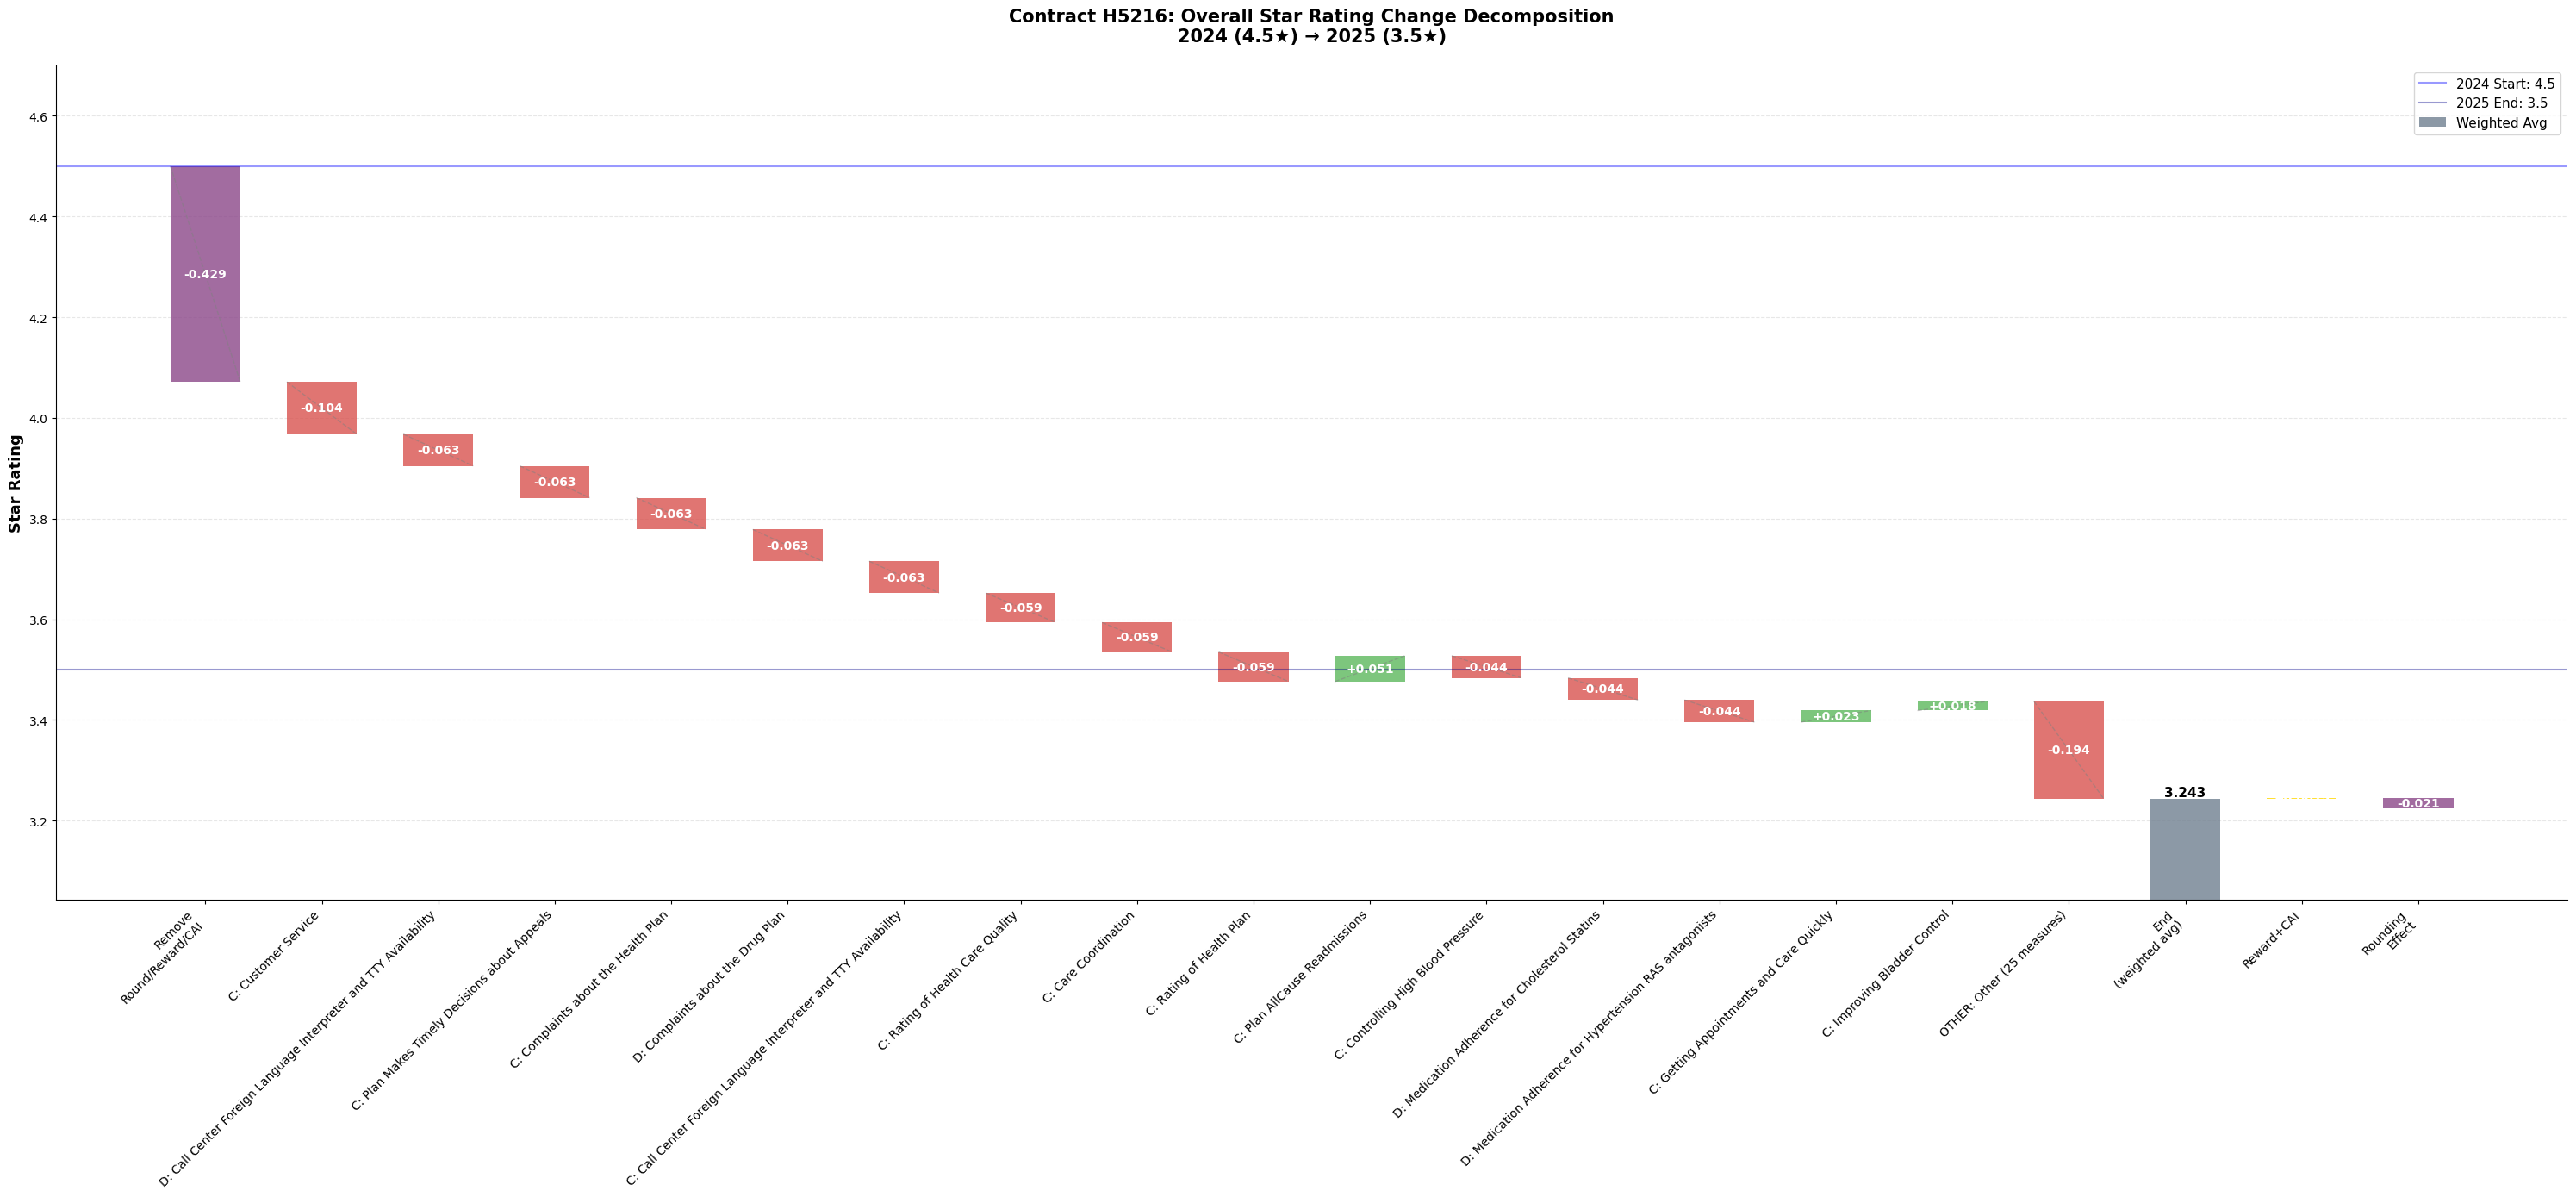

In [210]:
# Contract-specific waterfall for displayed contract #1
print(f"DETAILED WATERFALL #1: {top_n_contracts[0]}\n")
waterfall_1 = create_contract_waterfall(
    top_n_contracts[0], 
    final_df, 
    rating_type="Overall", 
    top_n=15,
    show_start_bar=False, 
    show_end_bar=False
)

DETAILED WATERFALL #2: H1036

CONTRACT WATERFALL: H1036 - OVERALL

✓ Found 129 Overall measure-year records for H1036
Comparing: 2024 → 2025

Key values:
  2024 Contract Star (rounded w/ reward+CAI): 5.00
  2024 Weighted Avg (raw): 4.3980
  Change to remove rounding/reward/CAI Y1: -0.6020

  2025 Weighted Avg (raw): 3.7182
  2025 Reward Factor: 0.00
  2025 CAI: +0.002506
  2025 Combined Reward+CAI: +0.0025
  2025 Weighted Avg + Reward + CAI: 3.7207
  Rounding effect Y2 (on weighted+reward+CAI): -0.2207
  2025 Contract Star (final rounded): 3.50

Weight sums: 2024=108.00, 2025=110.00
Measures with impact: 42
Showing top 15 measures + Other group

Decomposition:
  Starting (2024 Contract Star): 5.00
  Un-round/remove reward/CAI: -0.6020 → Weighted Avg 2024
  Measure contributions: -0.5601
    - Performance: -0.5370
    - Mix: -0.0231
  → Weighted Avg 2025: 3.7182
  Reward+CAI Y2: +0.0025
  Rounding effect Y2 (on weighted+reward+CAI): -0.2207
  Ending (2025 Contract Star): 3.50
Total chan

/var/folders/qy/b4dv4r3j5873r4f5yqghp6tw0000gn/T/ipykernel_47320/4118481362.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measures_display = pd.concat([top_measures, other_row], ignore_index=True)


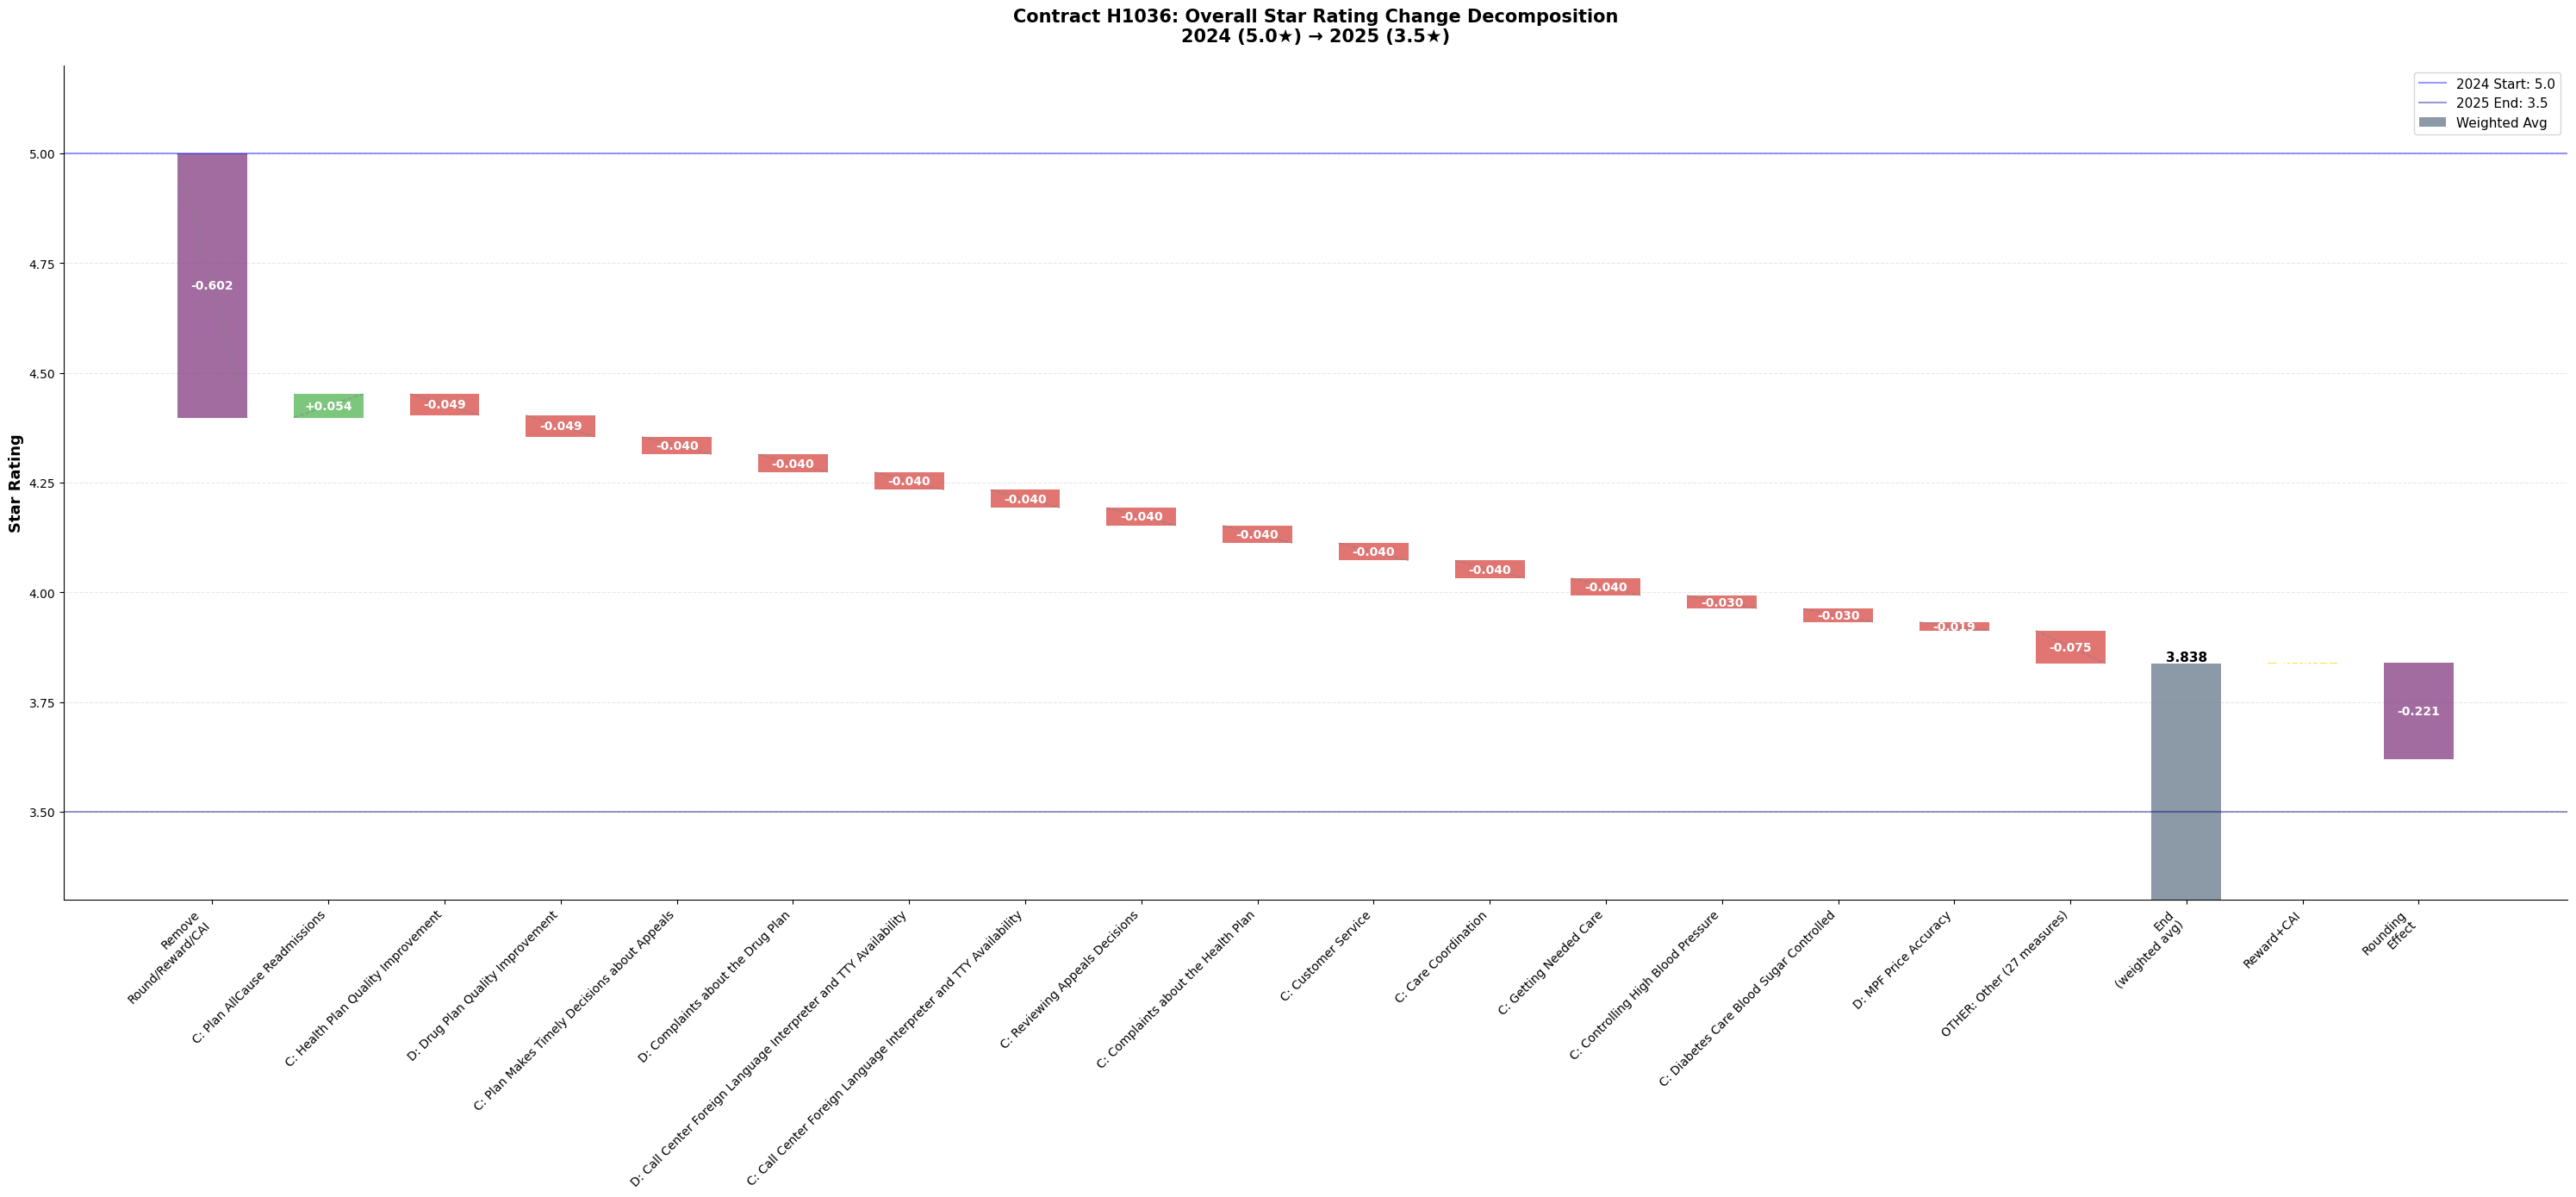

In [211]:
# Contract-specific waterfall for displayed contract #2
print(f"DETAILED WATERFALL #2: {top_n_contracts[1]}\n")
waterfall_2 = create_contract_waterfall(
    top_n_contracts[1], 
    final_df, 
    rating_type="Overall", 
    top_n=15,
    show_start_bar=False, 
    show_end_bar=False
)

DETAILED WATERFALL #3: H6622

CONTRACT WATERFALL: H6622 - OVERALL

✓ Found 129 Overall measure-year records for H6622
Comparing: 2024 → 2025

Key values:
  2024 Contract Star (rounded w/ reward+CAI): 4.00
  2024 Weighted Avg (raw): 3.9167
  Change to remove rounding/reward/CAI Y1: -0.0833

  2025 Weighted Avg (raw): 3.4727
  2025 Reward Factor: 0.00
  2025 CAI: +0.045230
  2025 Combined Reward+CAI: +0.0452
  2025 Weighted Avg + Reward + CAI: 3.5180
  Rounding effect Y2 (on weighted+reward+CAI): -0.0180
  2025 Contract Star (final rounded): 3.50

Weight sums: 2024=108.00, 2025=110.00
Measures with impact: 42
Showing top 15 measures + Other group

Decomposition:
  Starting (2024 Contract Star): 4.00
  Un-round/remove reward/CAI: -0.0833 → Weighted Avg 2024
  Measure contributions: -0.4519
    - Performance: -0.4352
    - Mix: -0.0167
  → Weighted Avg 2025: 3.4727
  Reward+CAI Y2: +0.0452
  Rounding effect Y2 (on weighted+reward+CAI): -0.0180
  Ending (2025 Contract Star): 3.50
Total chan

/var/folders/qy/b4dv4r3j5873r4f5yqghp6tw0000gn/T/ipykernel_47320/4118481362.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measures_display = pd.concat([top_measures, other_row], ignore_index=True)


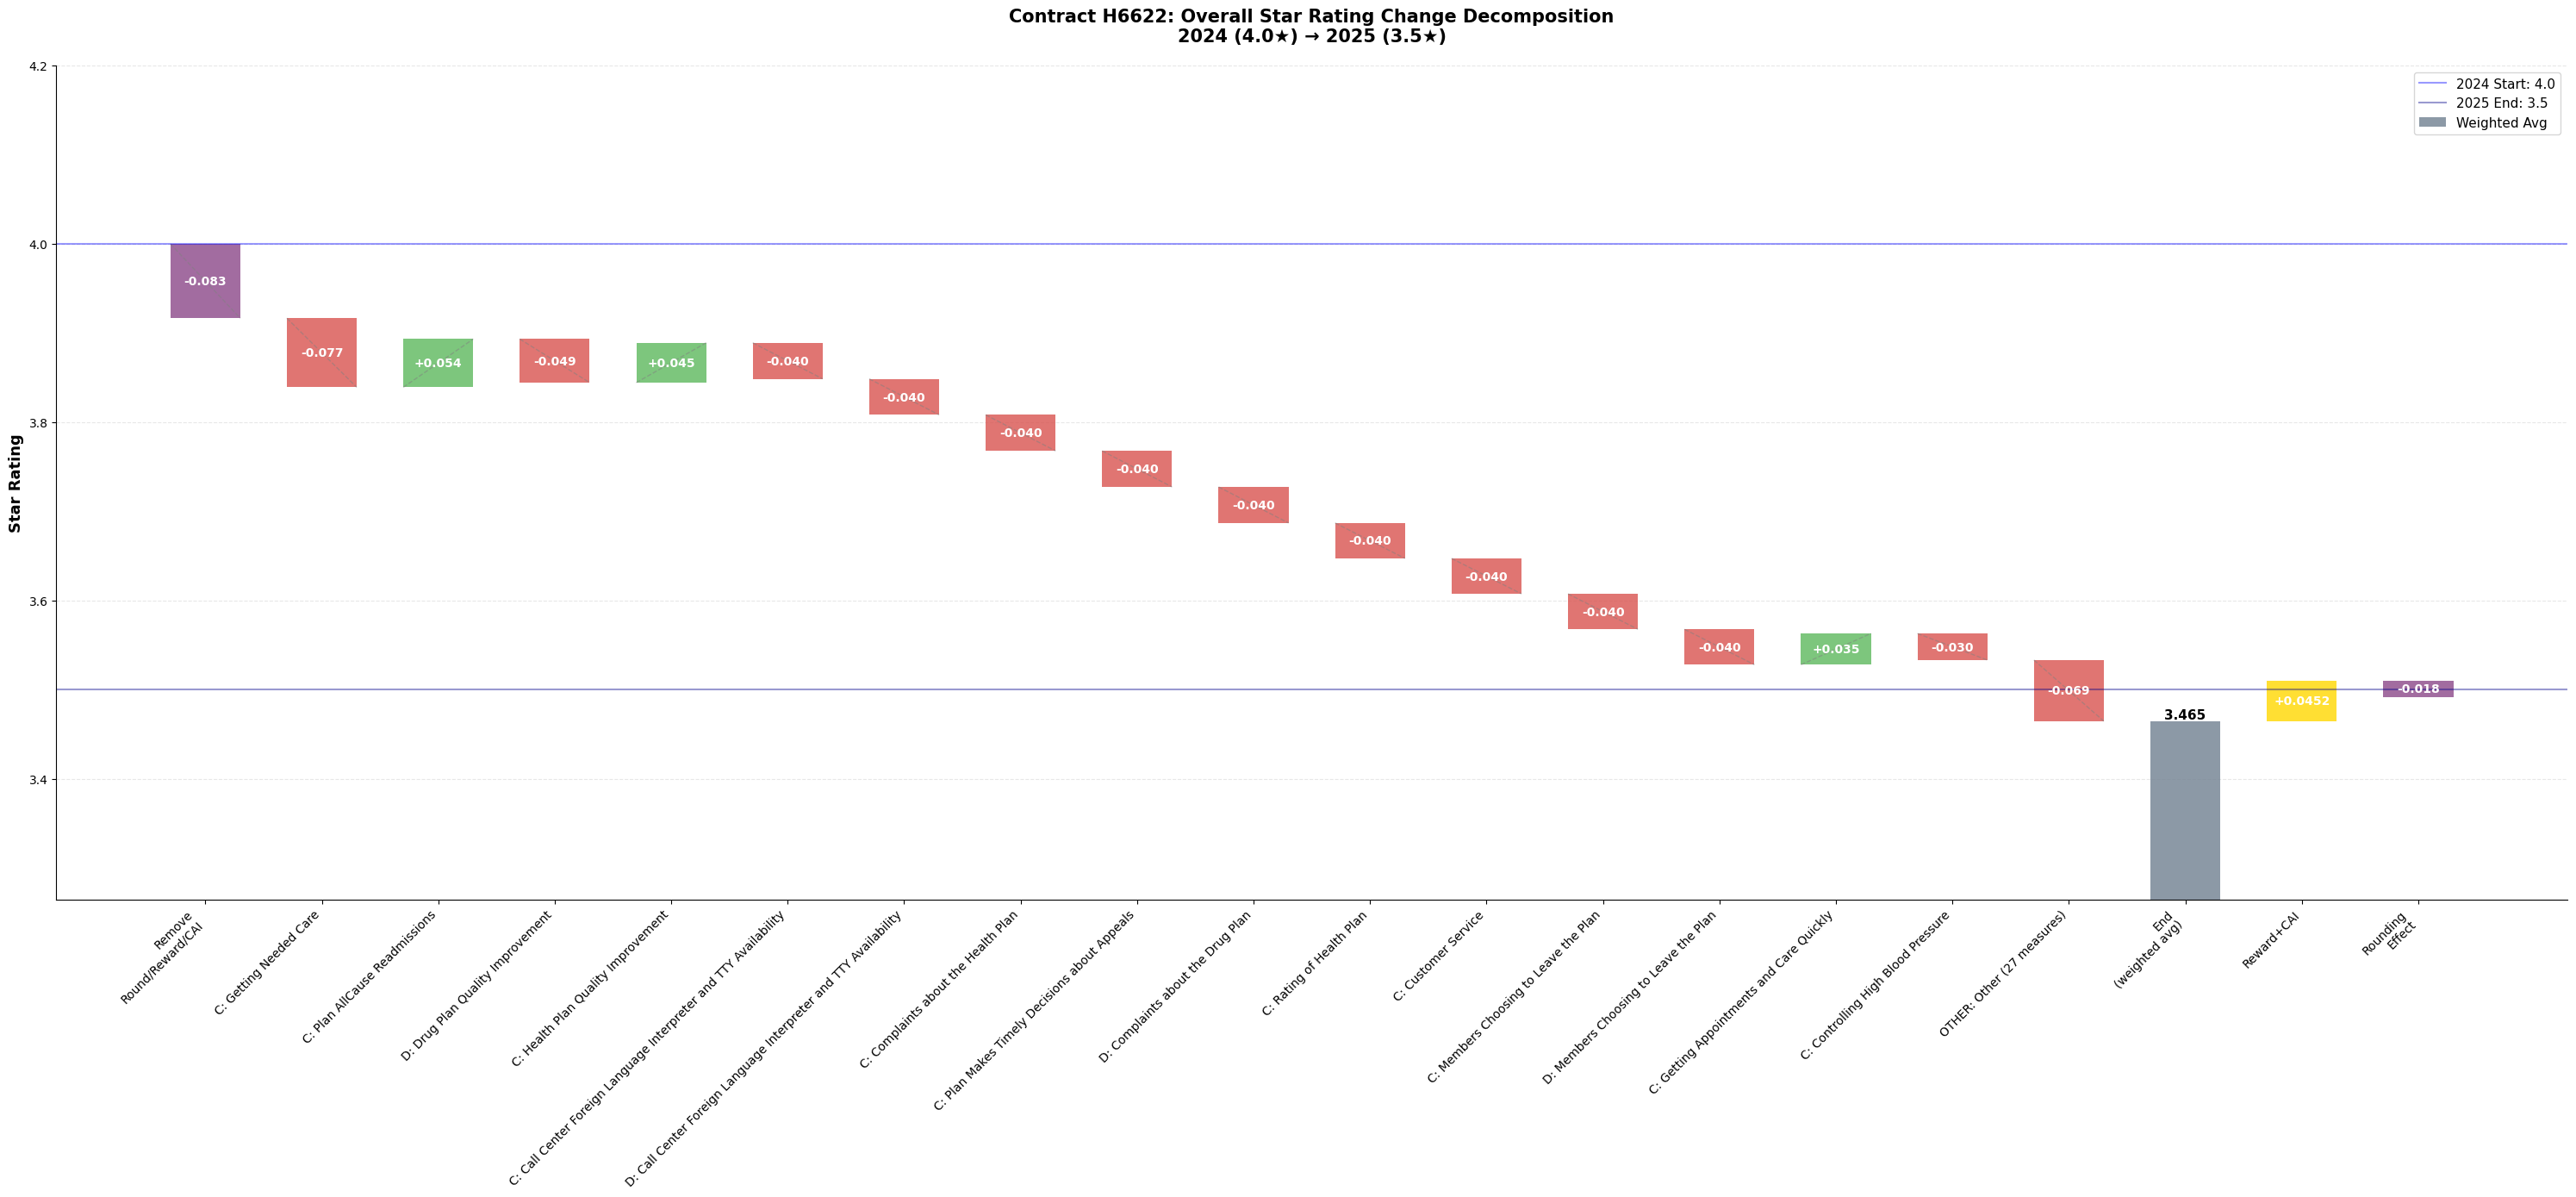

In [212]:
# Contract-specific waterfall for displayed contract #3
print(f"DETAILED WATERFALL #3: {top_n_contracts[2]}\n")
waterfall_3 = create_contract_waterfall(
    top_n_contracts[2], 
    final_df, 
    rating_type="Overall", 
    top_n=15,
    show_start_bar=False, 
    show_end_bar=False
)

In [213]:
final_df = final_df.merge(
    enrollment_df,
    on=['Year', 'contract_id'],
    how="left"
)

In [214]:
def calculate_all_contributions(df: pd.DataFrame, rating_types: list = ["Part C", "Part D", "Overall"]):
    """
    Calculate year-over-year contribution metrics for all contracts and measures.
    Returns a dataframe with measure-level contributions for all contracts.
    """
    # Column mappings
    inclusion_col_map = {
        "Part C": "Use Measure in Part C",
        "Part D": "Use Measure in Part D",
        "Overall": "Use Measure in Overall"
    }
    weighted_avg_col_map = {
        "Part C": "Weighted Avg Star Part C",
        "Part D": "Weighted Avg Star Part D",
        "Overall": "Weighted Avg Star Overall"
    }
    contract_star_col_map = {
        "Part C": "Part C Contract Star with Reward Factor and CAI",
        "Part D": "Part D Contract Star with Reward Factor and CAI",
        "Overall": "Overall Contract Star with Reward Factor and CAI"
    }
    reward_factor_col_map = {
        "Part C": "Reward Factor Part C",
        "Part D": "Reward Factor Part D",
        "Overall": "Reward Factor Overall"
    }
    cai_mapped_value_col_map = {
        "Part C": "Part_C_CAI_Mapped_Value",
        "Part D": "Part_D_CAI_Mapped_Value",
        "Overall": "Overall_CAI_Mapped_Value"
    }
    
    results = []
    
    # Get min year to exclude from calculations
    min_year = df['Year'].min()
    
    # Get unique contracts
    contracts = df['contract_id'].unique()
    
    print(f"Processing {len(contracts)} contracts across {len(rating_types)} rating types...")
    print(f"Excluding year {min_year} (no prior year data)")
    
    for contract_id in contracts:
        contract_data = df[df['contract_id'] == contract_id].copy()
        years = sorted(contract_data['Year'].unique())
        
        # Need at least 2 years
        if len(years) < 2:
            continue
        
        # Process each consecutive year pair
        for i in range(len(years) - 1):
            year_1, year_2 = years[i], years[i + 1]
            
            # Skip if year_2 is the minimum year (no prior data)
            if year_2 == min_year:
                continue
            
            for rating_type in rating_types:
                inclusion_col = inclusion_col_map[rating_type]
                weighted_avg_col = weighted_avg_col_map[rating_type]
                contract_star_col = contract_star_col_map[rating_type]
                reward_factor_col = reward_factor_col_map[rating_type]
                cai_mapped_value_col = cai_mapped_value_col_map[rating_type]
                
                # Filter to applicable measures
                rating_data = contract_data[contract_data[inclusion_col] == True].copy()
                
                if len(rating_data) == 0:
                    continue
                
                # Get year data
                y1_data = rating_data[rating_data['Year'] == year_1]
                y2_data = rating_data[rating_data['Year'] == year_2]
                
                if len(y1_data) == 0 or len(y2_data) == 0:
                    continue
                
                # Get contract-level values
                y1_contract = y1_data.iloc[0]
                y2_contract = y2_data.iloc[0]
                
                contract_star_y1 = y1_contract[contract_star_col]
                weighted_avg_y1 = y1_contract[weighted_avg_col]
                weighted_avg_y2 = y2_contract[weighted_avg_col]
                reward_factor_y2 = y2_contract[reward_factor_col]
                cai_mapped_value_y2 = y2_contract[cai_mapped_value_col] if pd.notna(y2_contract[cai_mapped_value_col]) else 0.0
                contract_star_y2 = y2_contract[contract_star_col]
                
                # Calculate weight sums
                weight_sum_y1 = y1_data['Weight'].sum()
                weight_sum_y2 = y2_data['Weight'].sum()
                
                if weight_sum_y1 == 0 or weight_sum_y2 == 0:
                    continue
                
                # Prepare measure data
                y1_measures = y1_data[
                    ['measure_code', 'measure_name', 'star_rating_numeric', 'Weight']
                ].rename(columns={
                    'star_rating_numeric': 'star_y1',
                    'Weight': 'weight_y1'
                })
                
                y2_measures = y2_data[
                    ['measure_code', 'measure_name', 'star_rating_numeric', 'Weight']
                ].rename(columns={
                    'star_rating_numeric': 'star_y2',
                    'Weight': 'weight_y2'
                })
                
                # Merge measures
                measures = y1_measures.merge(y2_measures, on=['measure_code', 'measure_name'], how='outer')
                measures['star_y1'] = measures['star_y1'].fillna(0)
                measures['star_y2'] = measures['star_y2'].fillna(0)
                measures['weight_y1'] = measures['weight_y1'].fillna(0)
                measures['weight_y2'] = measures['weight_y2'].fillna(0)
                
                # Calculate contributions
                measures['performance'] = (measures['weight_y1'] / weight_sum_y1) * (measures['star_y2'] - measures['star_y1'])
                measures['mix'] = ((measures['weight_y2'] / weight_sum_y2) - (measures['weight_y1'] / weight_sum_y1)) * measures['star_y1']
                measures['contribution'] = measures['performance'] + measures['mix']
                measures['star_change'] = measures['star_y2'] - measures['star_y1']
                measures['weight_change'] = measures['weight_y2'] - measures['weight_y1']
                
                # Get year 1 reward and CAI values
                reward_factor_y1 = y1_contract[reward_factor_col]
                cai_mapped_value_y1 = y1_contract[cai_mapped_value_col] if pd.notna(y1_contract[cai_mapped_value_col]) else 0.0
                
                # Calculate intermediate values
                # Year 1: weighted avg + reward + CAI
                weighted_avg_plus_reward_y1 = weighted_avg_y1 + reward_factor_y1
                weighted_avg_plus_reward_cai_y1 = weighted_avg_y1 + reward_factor_y1 + cai_mapped_value_y1
                
                # Year 2: weighted avg + reward + CAI
                weighted_avg_plus_reward_y2 = weighted_avg_y2 + reward_factor_y2
                weighted_avg_plus_reward_cai_y2 = weighted_avg_y2 + reward_factor_y2 + cai_mapped_value_y2
                
                # Add metadata
                measures['contract_id'] = contract_id
                measures['year_from'] = year_1
                measures['year_to'] = year_2
                measures['rating_type'] = rating_type
                
                # Summary stars (final rounded values)
                measures['contract_star_y1'] = contract_star_y1
                measures['contract_star_y2'] = contract_star_y2
                measures['total_star_change'] = contract_star_y2 - contract_star_y1
                
                # Raw weighted averages (before any adjustments)
                measures['weighted_avg_y1'] = weighted_avg_y1
                measures['weighted_avg_y2'] = weighted_avg_y2
                measures['weighted_avg_change'] = weighted_avg_y2 - weighted_avg_y1
                
                # Reward factors
                measures['reward_factor_y1'] = reward_factor_y1
                measures['reward_factor_y2'] = reward_factor_y2
                measures['reward_factor_change'] = reward_factor_y2 - reward_factor_y1
                
                # CAI values
                measures['cai_y1'] = cai_mapped_value_y1
                measures['cai_y2'] = cai_mapped_value_y2
                measures['cai_change'] = cai_mapped_value_y2 - cai_mapped_value_y1
                
                # Intermediate calculations (before rounding)
                measures['weighted_avg_plus_reward_y1'] = weighted_avg_plus_reward_y1
                measures['weighted_avg_plus_reward_y2'] = weighted_avg_plus_reward_y2
                measures['weighted_avg_plus_reward_cai_y1'] = weighted_avg_plus_reward_cai_y1
                measures['weighted_avg_plus_reward_cai_y2'] = weighted_avg_plus_reward_cai_y2
                
                results.append(measures)
    
    if len(results) == 0:
        print("No valid year-over-year comparisons found")
        return None
    
    # Combine all results
    all_contributions = pd.concat(results, ignore_index=True)
    
    print(f"✓ Calculated contributions for {len(all_contributions)} measure-contract-year-rating combinations")
    print(f"  Unique contracts: {all_contributions['contract_id'].nunique()}")
    print(f"  Year pairs: {all_contributions[['year_from', 'year_to']].drop_duplicates()}")
    
    return all_contributions

# Calculate for all contracts
contribution_df = calculate_all_contributions(final_df)

Processing 954 contracts across 3 rating types...
Excluding year 2024 (no prior year data)
✓ Calculated contributions for 112610 measure-contract-year-rating combinations
  Unique contracts: 710
  Year pairs:     year_from  year_to
0        2024     2025
18       2025     2026


In [215]:
# Create slim output with key columns
slim_contribution_output = contribution_df[[
    # Identifiers
    'contract_id',
    'year_from',
    'year_to',
    'rating_type',
    'measure_code',
    'measure_name',
    
    # Measure-level stars
    'star_y1',
    'star_y2',
    'star_change',
    
    # Measure-level weights
    'weight_y1',
    'weight_y2',
    'weight_change',
    
    # Contributions (KEY METRICS)
    'contribution',
    'performance',
    'mix',
    
    # Contract-level summary stars (final rounded values)
    'contract_star_y1',
    'contract_star_y2',
    'total_star_change',
    
    # Raw weighted averages (before adjustments)
    'weighted_avg_y1',
    'weighted_avg_y2',
    'weighted_avg_change',
    
    # Reward factors
    'reward_factor_y1',
    'reward_factor_y2',
    'reward_factor_change',
    
    # CAI values
    'cai_y1',
    'cai_y2',
    'cai_change',
    
    # Intermediate values (weighted avg + adjustments, before rounding)
    'weighted_avg_plus_reward_y1',
    'weighted_avg_plus_reward_y2',
    'weighted_avg_plus_reward_cai_y1',
    'weighted_avg_plus_reward_cai_y2'
]].copy()

# Sort for easy viewing
slim_contribution_output = slim_contribution_output.sort_values(
    ['contract_id', 'rating_type', 'year_to', 'contribution'],
    ascending=[True, True, True, False]
)

print(f"Slim output created with {len(slim_contribution_output)} rows and {len(slim_contribution_output.columns)} columns")
print(f"\nColumn groups:")
print(f"  Identifiers: 6 columns")
print(f"  Measure stars & weights: 6 columns")
print(f"  Contributions: 3 columns")
print(f"  Summary stars: 3 columns")
print(f"  Weighted averages: 3 columns")
print(f"  Reward factors: 3 columns")
print(f"  CAI values: 3 columns")
print(f"  Intermediate calculations: 4 columns")
print(f"  TOTAL: {len(slim_contribution_output.columns)} columns")

print(f"\nData coverage:")
print(f"  Contracts: {slim_contribution_output['contract_id'].nunique()}")
print(f"  Measures: {slim_contribution_output['measure_code'].nunique()}")
print(f"  Rating types: {slim_contribution_output['rating_type'].unique().tolist()}")

# Show sample with key new columns
print(f"\nSample data (showing key columns):")
sample_cols = ['contract_id', 'year_to', 'rating_type', 'measure_code', 
               'contribution', 'contract_star_y1', 'contract_star_y2',
               'reward_factor_y1', 'reward_factor_y2', 'cai_y1', 'cai_y2']
slim_contribution_output[sample_cols].head(10)

Slim output created with 112610 rows and 31 columns

Column groups:
  Identifiers: 6 columns
  Measure stars & weights: 6 columns
  Contributions: 3 columns
  Summary stars: 3 columns
  Weighted averages: 3 columns
  Reward factors: 3 columns
  CAI values: 3 columns
  Intermediate calculations: 4 columns
  TOTAL: 31 columns

Data coverage:
  Contracts: 710
  Measures: 45
  Rating types: ['Overall', 'Part D', 'Part C']

Sample data (showing key columns):


,contract_id,year_to,rating_type,measure_code,contribution,contract_star_y1,contract_star_y2,reward_factor_y1,reward_factor_y2,cai_y1,cai_y2
9,E3014,2025,Overall,D02,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
10,E3014,2025,Overall,D04,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
11,E3014,2025,Overall,D05,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
12,E3014,2025,Overall,D06,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
13,E3014,2025,Overall,D08,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
14,E3014,2025,Overall,D09,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
15,E3014,2025,Overall,D10,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
16,E3014,2025,Overall,D11,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
17,E3014,2025,Overall,D12,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
31,E3014,2026,Overall,D08,0.116883,NaN,NaN,0.0,0.0,0.0,0.0


In [216]:
slim_contribution_output.to_csv("output/slim_contribution_output.csv", index=False)